In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#sys.path.insert(0, '/Users/Corey4005/Desktop/repos/SCANAnalysis/SCAN-scripts/')#for my windows machine
#sys.path.insert(0, '/Users/coreywalker/Desktop/NOAA/SCANAnalysis/SCAN-scripts/')#for my Macbook 
sys.path.insert(0, '/rhome/cwalker/Desktop/repositories/SCANAnalysis/SCAN-scripts/')#for my Linux Machine

In [2]:
from datasets import SM_VS_ESI_ANOM_READ, SCAN_META_READ, DROUGHT_READ, SCAN_SIG_READ, SOILS_READ, LANDREAD

In [3]:
LANDREAD = LANDREAD.drop('Unnamed: 0', axis=1)

In [4]:
SM_VS_ESI_ANOM_READ

Date    ESI       station  week_x  week_y   2inANOM   4inANOM  \
0     2002-04-30 -0.527  2057:AL:SCAN      18      18 -1.839516 -2.608769   
1     2002-05-21  1.565  2057:AL:SCAN      21      21 -0.349508 -1.356723   
2     2002-05-28  1.484  2057:AL:SCAN      22      22 -0.234778 -0.972001   
3     2002-06-11  0.419  2057:AL:SCAN      24      24 -1.524178 -1.680948   
4     2002-06-18  1.374  2057:AL:SCAN      25      25 -0.737961 -1.484239   
...          ...    ...           ...     ...     ...       ...       ...   
9669  2020-12-02  1.522  2053:AL:SCAN      49      49       NaN -0.038652   
9670  2020-12-09  1.082  2053:AL:SCAN      50      50       NaN -0.628406   
9671  2020-12-16  0.068  2053:AL:SCAN      51      51       NaN -0.564758   
9672  2020-12-23  0.167  2053:AL:SCAN      52      52       NaN -0.662174   
9673  2020-12-30 -0.768  2053:AL:SCAN      53      53       NaN -1.101505   

       8inANOM  20inANOM  40inANOM  
0    -2.434962 -2.084585 -1.598313  
1    -1.702116 -1.692849 -0.663807  
2    -1.546049 -1.441618 -0.890192  
3    -1.660611 -1.608081 -0.872815  
4    -2.253738 -2.101628 -0.901292  
...        ...       ...       ...  
9669  0.551961  0.416028 -1.223196  
9670  0.522642  0.541675 -0.954042  
9671  0.286017  0.215204 -0.923545  
9672  0.122894 -0.009764  0.495781  
9673  1.154264  0.418541  1.125623  

[9674 rows x 10 columns]

In [5]:
#create percent rank of sm anomalies 
SM_VS_ESI_ANOM_READ['2in_pr'] = SM_VS_ESI_ANOM_READ['2inANOM'].rank(pct=True) * 100.0
SM_VS_ESI_ANOM_READ['4in_pr'] = SM_VS_ESI_ANOM_READ['4inANOM'].rank(pct=True) * 100.0
SM_VS_ESI_ANOM_READ['8in_pr'] = SM_VS_ESI_ANOM_READ['8inANOM'].rank(pct=True) * 100.0
SM_VS_ESI_ANOM_READ['20in_pr'] = SM_VS_ESI_ANOM_READ['20inANOM'].rank(pct=True) * 100.0
SM_VS_ESI_ANOM_READ['40in_pr'] = SM_VS_ESI_ANOM_READ['40inANOM'].rank(pct=True) * 100.0

In [6]:
def droughtLabel(percent_rank):
    #this function takes in a percent rank (float) and returns a drought category (float)
    if (percent_rank <= 30.0) & (percent_rank>=21.0):
        return 0.0
    elif (percent_rank > 30.0):
        return np.nan
    elif (percent_rank <= 20.0) & (percent_rank>=11.0):
        return 1.0
    elif (percent_rank <= 10.0) & (percent_rank>=6.0):
        return 2.0
    elif (percent_rank <=5.0) & (percent_rank>=3.0):
        return 3.0
    elif (percent_rank <=3.0):
        return 4.0

In [7]:
#get the drought category for percent rank (DC) for soil moisture stations (SMS)
SM_VS_ESI_ANOM_READ['2inSMSDC'] = SM_VS_ESI_ANOM_READ['2in_pr'].apply(droughtLabel)
SM_VS_ESI_ANOM_READ['4inSMSDC'] = SM_VS_ESI_ANOM_READ['4in_pr'].apply(droughtLabel)
SM_VS_ESI_ANOM_READ['8inSMSDC'] = SM_VS_ESI_ANOM_READ['8in_pr'].apply(droughtLabel)
SM_VS_ESI_ANOM_READ['20inSMSDC']= SM_VS_ESI_ANOM_READ['20in_pr'].apply(droughtLabel)
SM_VS_ESI_ANOM_READ['40inSMSDC']= SM_VS_ESI_ANOM_READ['40in_pr'].apply(droughtLabel)

In [8]:
#what is the average ESI for each drought category?
depths = []
category = []
averageESI = []

for i in ['2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC', '40inSMSDC']:
    droughtFrame = SM_VS_ESI_ANOM_READ[[i, "ESI"]]
    for j in droughtFrame[i].unique():
        categoryFrame = droughtFrame[droughtFrame[i]==j]
        if np.isnan(j):
            pass
        else:
            avgESI = categoryFrame['ESI'].mean()
            depths.append(i)
            category.append(j)
            averageESI.append(avgESI)

df = pd.DataFrame()
df['depth'] = depths
df['category']=category
df['meanESI']=averageESI

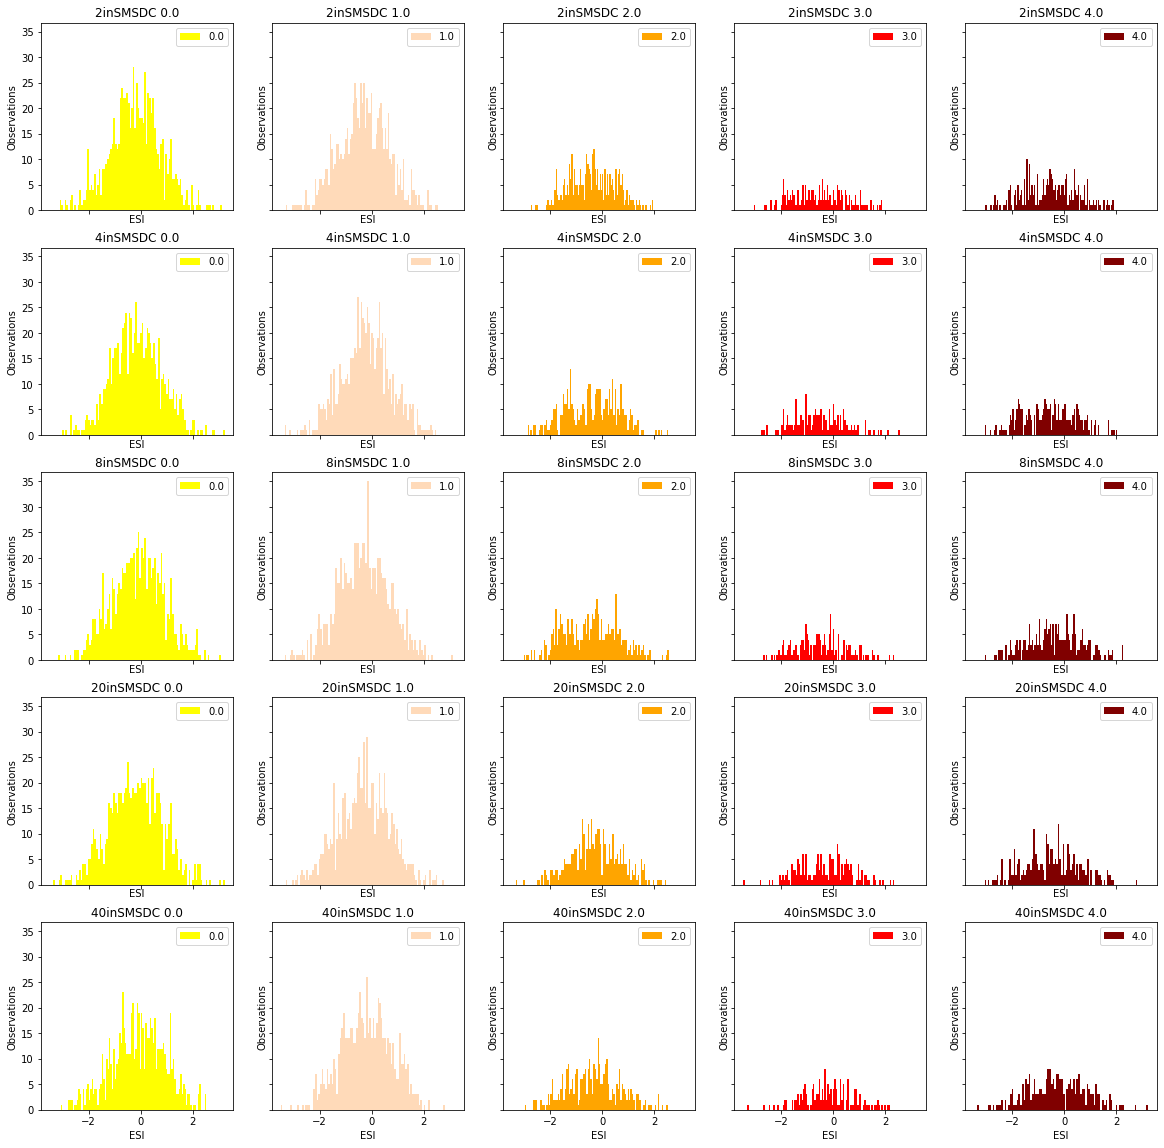

In [9]:
#what is the variability for each category?
fig, ax = plt.subplots(figsize=(20,20),nrows=5, ncols=5, sharey=True, sharex=True)
axes = ax.flatten()
count = 0
colorKey = {0:"yellow",1:"peachpuff",2:"orange",3:"red",4:"maroon"}
for i in ['2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC', '40inSMSDC']:
    droughtFrame = SM_VS_ESI_ANOM_READ[[i, "ESI"]]
    for c in [0.0, 1.0, 2.0, 3.0, 4.0]:
        categoryFrame=droughtFrame[droughtFrame[i]==c]
        if np.isnan(c):
            pass
        else:
            axes[count].hist(categoryFrame['ESI'], label=c, bins=100, color=colorKey.get(c))
            axes[count].legend()
            axes[count].set_title(i + " " + str(c))
            axes[count].set_ylabel("Observations")
            axes[count].set_xlabel("ESI")
            count+=1
          

In [10]:
df.sort_values(["depth", "category"], inplace=True)

Text(0.5, 0, 'Drought Category')

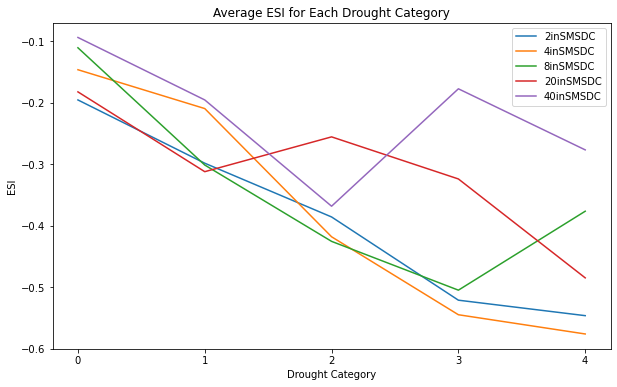

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
for i in ['2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC', '40inSMSDC']:
    depthFrame = df[df['depth']==i]
    plotFrame = depthFrame.set_index('category')
    ax.plot(plotFrame['meanESI'], label=i)
    ax.legend()
ax.xaxis.set_ticks([0,1,2,3,4])
ax.set_title("Average ESI for Each Drought Category")
ax.set_ylabel("ESI")
ax.set_xlabel("Drought Category")

In [12]:
scanTriplets = SCAN_META_READ[['station', 'Station Name']]

In [13]:
DROUGHT_READ.rename(columns={'station_names':'Station Name', 'date':'Date'}, inplace=True)

In [14]:
drought_data = DROUGHT_READ.merge(scanTriplets, on='Station Name')

In [15]:
DM_test = drought_data[drought_data['station']=='2056:AL:SCAN']
ESI_test = SM_VS_ESI_ANOM_READ[SM_VS_ESI_ANOM_READ['station']=='2056:AL:SCAN']
SMSDM_test = SM_VS_ESI_ANOM_READ[SM_VS_ESI_ANOM_READ['station']=='2056:AL:SCAN']
ESI_test['Date']=pd.to_datetime(ESI_test['Date'], format='%Y-%m-%d')
SMSDM_test['Date']=pd.to_datetime(SMSDM_test['Date'], format='%Y-%m-%d')

/tmp/ipykernel_18989/3058360447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ESI_test['Date']=pd.to_datetime(ESI_test['Date'], format='%Y-%m-%d')
/tmp/ipykernel_18989/3058360447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SMSDM_test['Date']=pd.to_datetime(SMSDM_test['Date'], format='%Y-%m-%d')


In [16]:
#set the index
DM_test.set_index('Date', inplace=True)
ESI_test.set_index('Date', inplace=True)
SMSDM_test.set_index('Date', inplace=True)

In [17]:
#lets look at drought year 
DM_test = DM_test[(DM_test.index.year==2012) | (DM_test.index.year==2013)]
ESI_test = ESI_test[(ESI_test.index.year==2012)|(ESI_test.index.year==2013)]
SMSDM_test = SMSDM_test[(SMSDM_test.index.year==2012)|(SMSDM_test.index.year==2013)]

In [18]:
DM_test.sort_index(inplace=True)
ESI_test.sort_index(inplace=True)
SMSDM_test.sort_index(inplace=True)

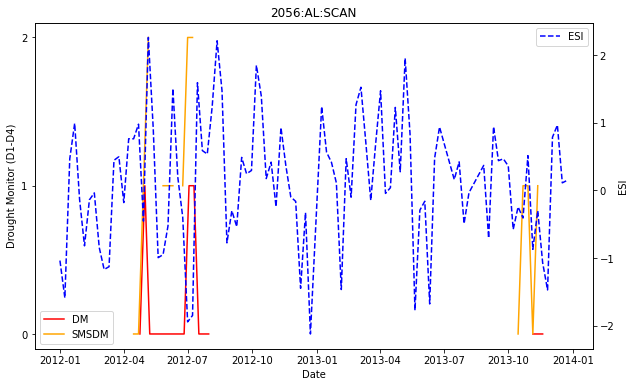

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(DM_test['Category'], label='DM', color='red')
ax.plot()
ax2 = ax.twinx()
ax2.plot(ESI_test['ESI'], label='ESI', linestyle='dashed', color='blue')
ax2.legend()
ax.set_ylabel('Drought Monitor (D1-D4)')
ax2.set_ylabel('ESI')
ax.set_xlabel('Date')
ax.set_title(DM_test['station'].unique().item())
ax.plot(SMSDM_test['4inSMSDC'], label="SMSDM", color='orange')
ax.legend(loc='lower left')
ax.yaxis.set_ticks([0,1,2])

In [20]:
SMSDM_test

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2012-01-01 -1.036  2056:AL:SCAN      52      52  0.530074  0.773755  0.901517   
2012-01-08 -1.587  2056:AL:SCAN       1       1 -1.129205 -0.240322  0.653609   
2012-01-15  0.468  2056:AL:SCAN       2       2  0.607961  0.629268  1.104360   
2012-01-22  0.993  2056:AL:SCAN       3       3  0.137346  0.442041  1.572774   
2012-01-29 -0.133  2056:AL:SCAN       4       4  0.576963  0.714880  1.379145   
...           ...           ...     ...     ...       ...       ...       ...   
2013-11-26 -1.470  2056:AL:SCAN      48      48 -1.189684 -0.243622 -2.253057   
2013-12-03  0.788  2056:AL:SCAN      49      49 -1.167394 -0.160547 -1.002094   
2013-12-10  0.966  2056:AL:SCAN      50      50  0.123019  0.591791 -0.861794   
2013-12-17  0.113  2056:AL:SCAN      51      51  0.256049  0.540199 -0.427590   
2013-12-24  0.150  2056:AL:SCAN      52      52 -0.384387  0.439368 -0.120292   

            20inANOM  40inANOM     2in_pr     4in_pr     8in_pr    20in_pr  \
Date                                                                         
2012-01-01  0.398306  1.263294  66.677599  77.002967  82.548998  62.741899   
2012-01-08  0.331736  1.538225  13.392369  39.659895  73.469162  59.484698   
2012-01-15  0.340749  1.342732  69.935498  70.623145  88.506256  59.957246   
2012-01-22  0.285516  1.345538  52.629277  63.558548  96.966006  57.493249   
2012-01-29  0.468891  1.394955  68.743850  74.503538  94.474588  65.948470   
...              ...       ...        ...        ...        ...        ...   
2013-11-26 -0.765908       NaN  11.916475  39.557179   0.996567  21.703420   
2013-12-03  0.101743       NaN  12.419372  42.353344  15.867567  49.662466   
2013-12-10  0.564228       NaN  52.038920  69.322073  19.577013  69.846985   
2013-12-17  0.392162       NaN  56.761780  67.381876  32.211272  62.274977   
2013-12-24  0.362260       NaN  35.148136  63.455832  42.719522  60.924842   

              40in_pr  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  
Date                                                                       
2012-01-01  92.298303       NaN       NaN       NaN        NaN        NaN  
2012-01-08  96.753326       1.0       NaN       NaN        NaN        NaN  
2012-01-15  93.848407       NaN       NaN       NaN        NaN        NaN  
2012-01-22  93.897229       NaN       NaN       NaN        NaN        NaN  
2012-01-29  94.751617       NaN       NaN       NaN        NaN        NaN  
...               ...       ...       ...       ...        ...        ...  
2013-11-26        NaN       1.0       NaN       4.0        0.0        NaN  
2013-12-03        NaN       1.0       NaN       1.0        NaN        NaN  
2013-12-10        NaN       NaN       NaN       1.0        NaN        NaN  
2013-12-17        NaN       NaN       NaN       NaN        NaN        NaN  
2013-12-24        NaN       NaN       NaN       NaN        NaN        NaN  

[99 rows x 19 columns]

In [21]:
#now we are goin to test cumulative fall for drought 2007
DM_test = drought_data[drought_data['station']=='2078:AL:SCAN']
ESI_test = SM_VS_ESI_ANOM_READ[SM_VS_ESI_ANOM_READ['station']=='2078:AL:SCAN']
SMSDM_test = SM_VS_ESI_ANOM_READ[SM_VS_ESI_ANOM_READ['station']=='2078:AL:SCAN']

In [22]:
DM_test.set_index('Date', inplace=True)
ESI_test.set_index('Date', inplace=True)
SMSDM_test.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

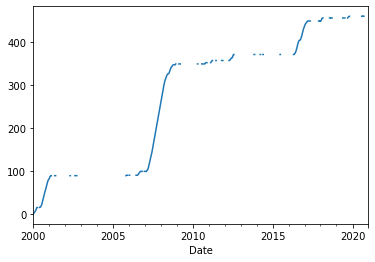

In [23]:
DM_test['Category'].cumsum().plot()

In [24]:
#fixing datetime
ESI_test.index = pd.to_datetime(ESI_test.index)

<AxesSubplot:xlabel='Date'>

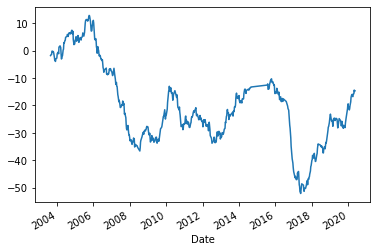

In [25]:
ESI_test['ESI'].cumsum().plot()

In [26]:
#fixing datetime
SMSDM_test.index = pd.to_datetime(SMSDM_test.index)

Text(0.5, 0, 'Date')

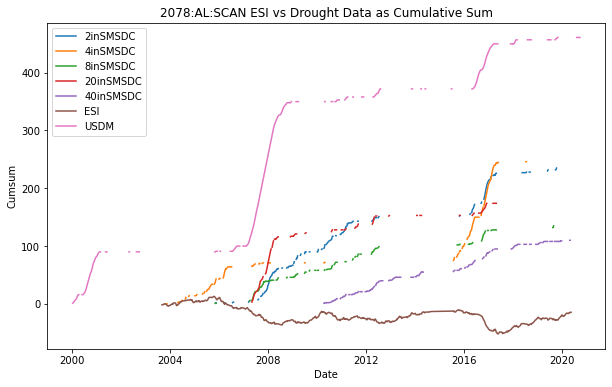

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(SMSDM_test['2inSMSDC'].cumsum(), label='2inSMSDC')
ax.plot(SMSDM_test['4inSMSDC'].cumsum(), label='4inSMSDC')
ax.plot(SMSDM_test['8inSMSDC'].cumsum(), label='8inSMSDC')
ax.plot(SMSDM_test['20inSMSDC'].cumsum(), label='20inSMSDC')
ax.plot(SMSDM_test['40inSMSDC'].cumsum(), label='40inSMSDC')
ax.plot(ESI_test['ESI'].cumsum(), label='ESI')
ax.plot(DM_test['Category'].cumsum(), label='USDM')
ax.legend()
ax.set_title('2078:AL:SCAN ESI vs Drought Data as Cumulative Sum')
ax.set_ylabel('Cumsum')
ax.set_xlabel('Date')

Text(0.5, 1.0, '2078:AL:SCAN Drought Categroy vs ESI Raw Data')

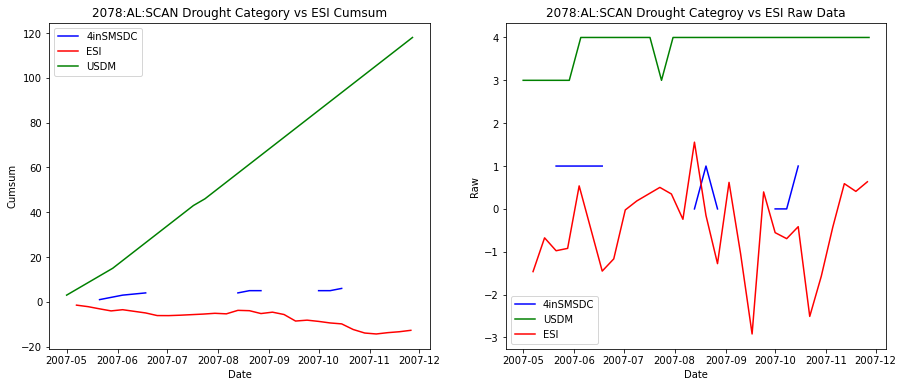

In [28]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)
ax[0].plot(SMSDM_test[(SMSDM_test.index.month>=5) & (SMSDM_test.index.month<=11) & (SMSDM_test.index.year==2007)]['4inSMSDC'].cumsum(), label='4inSMSDC', color='blue')
ax[0].plot(ESI_test[(ESI_test.index.month>=5) & (ESI_test.index.month<=11) & (ESI_test.index.year==2007)]['ESI'].cumsum(), label='ESI', color='red')
ax[0].plot(DM_test[(DM_test.index.month>=5) & (DM_test.index.month<=11) & (DM_test.index.year==2007)]['Category'].cumsum(), label='USDM', color='green')
ax[0].legend()
ax[1].plot(SMSDM_test[(SMSDM_test.index.month>=5) & (SMSDM_test.index.month<=11) & (SMSDM_test.index.year==2007)]['4inSMSDC'], label='4inSMSDC', color='blue')
ax[1].plot(DM_test[(DM_test.index.month>=5) & (DM_test.index.month<=11) & (DM_test.index.year==2007)]['Category'], label='USDM', color='green')
ax[1].plot(ESI_test[(ESI_test.index.month>=5) & (ESI_test.index.month<=11) & (ESI_test.index.year==2007)]['ESI'], label='ESI', color='red')
ax[1].legend()
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Cumsum')
ax[0].set_title('2078:AL:SCAN Drought Category vs ESI Cumsum')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Raw')
ax[1].set_title('2078:AL:SCAN Drought Categroy vs ESI Raw Data')

In [29]:
DM_test[(DM_test.index.month>=5) & (DM_test.index.month<=11) & (DM_test.index.year==2007)]

point  Category Station Name       station
Date                                                                       
2007-05-01  POINT (-86.60236 34.89375)       3.0   Bragg Farm  2078:AL:SCAN
2007-05-08  POINT (-86.60236 34.89375)       3.0   Bragg Farm  2078:AL:SCAN
2007-05-15  POINT (-86.60236 34.89375)       3.0   Bragg Farm  2078:AL:SCAN
2007-05-22  POINT (-86.60236 34.89375)       3.0   Bragg Farm  2078:AL:SCAN
2007-05-29  POINT (-86.60236 34.89375)       3.0   Bragg Farm  2078:AL:SCAN
2007-06-05  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-06-12  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-06-19  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-06-26  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-07-03  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-07-10  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-07-17  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-07-24  POINT (-86.60236 34.89375)       3.0   Bragg Farm  2078:AL:SCAN
2007-07-31  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-08-07  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-08-14  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-08-21  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-08-28  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-09-04  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-09-11  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-09-18  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-09-25  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-10-02  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-10-09  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-10-16  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-10-23  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-10-30  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-11-06  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-11-13  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-11-20  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN
2007-11-27  POINT (-86.60236 34.89375)       4.0   Bragg Farm  2078:AL:SCAN

Text(0, 0.5, 'Drought Category')

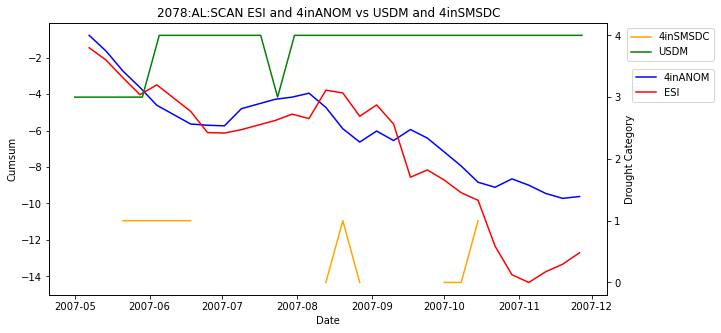

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(SMSDM_test[(SMSDM_test.index.month>=5) & (SMSDM_test.index.month<=11) & (SMSDM_test.index.year==2007)]['4inANOM'].cumsum(), label='4inANOM', color='blue')
ax.plot(ESI_test[(ESI_test.index.month>=5) & (ESI_test.index.month<=11) & (ESI_test.index.year==2007)]['ESI'].cumsum(), label='ESI', color='red')
ax2=ax.twinx()
ax2.plot(SMSDM_test[(SMSDM_test.index.month>=5) & (SMSDM_test.index.month<=11) & (SMSDM_test.index.year==2007)]['4inSMSDC'], label='4inSMSDC', color='orange')
ax2.plot(DM_test[(DM_test.index.month>=5) & (DM_test.index.month<=11) & (DM_test.index.year==2007)]['Category'], label='USDM', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Cumsum')
ax.set_title('2078:AL:SCAN ESI and 4inANOM vs USDM and 4inSMSDC')
ax2.legend(bbox_to_anchor=(1.20, 1.0), loc='upper right')
ax.legend(bbox_to_anchor=(1.20, 0.85), loc='upper right')
ax2.yaxis.set_ticks([0, 1, 2, 3, 4])
ax2.set_ylabel('Drought Category')

<AxesSubplot:xlabel='Date'>

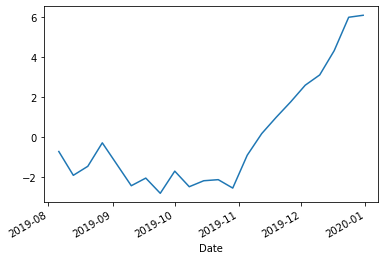

In [31]:
ESI_test[(ESI_test.index.month >= 8) & (ESI_test.index.year==2019)]['ESI'].cumsum().plot()

<AxesSubplot:xlabel='Date'>

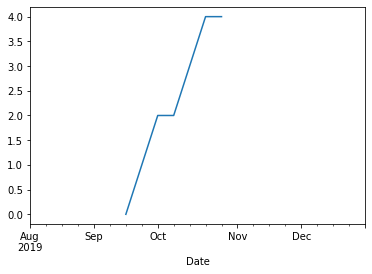

In [32]:
DM_test[(DM_test.index.month >= 8) & (DM_test.index.year==2019)]['Category'].cumsum().plot() 

In [33]:
DM_test[(DM_test.index.month >= 8) & (DM_test.index.year==2019)]['Category'].cumsum()

Date
2019-08-06    NaN
2019-08-13    NaN
2019-08-20    NaN
2019-08-27    NaN
2019-09-03    NaN
2019-09-10    NaN
2019-09-17    0.0
2019-09-24    1.0
2019-10-01    2.0
2019-10-08    2.0
2019-10-15    3.0
2019-10-22    4.0
2019-10-29    4.0
2019-11-05    NaN
2019-11-12    NaN
2019-11-19    4.0
2019-11-26    NaN
2019-12-03    NaN
2019-12-10    NaN
2019-12-17    NaN
2019-12-24    NaN
2019-12-31    NaN
Name: Category, dtype: float64

<AxesSubplot:xlabel='Date'>

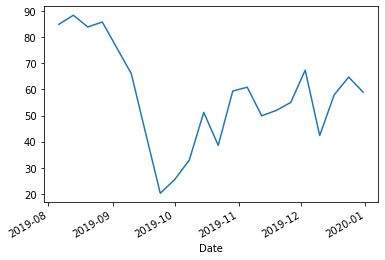

In [34]:
SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2019)]['4in_pr'].plot()

<AxesSubplot:xlabel='Date'>

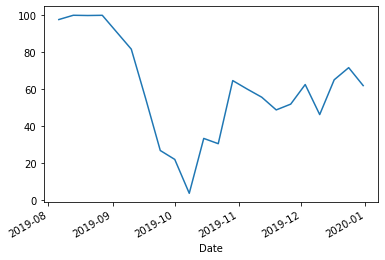

In [35]:
SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2019)]['2in_pr'].plot()

In [36]:
SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2019)]

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2019-08-06 -0.731  2078:AL:SCAN      32      32  1.638670  0.991352 -0.100813   
2019-08-13 -1.194  2078:AL:SCAN      33      33  2.173916  1.104749 -2.118304   
2019-08-20  0.452  2078:AL:SCAN      34      34  2.108838  0.962681 -0.703471   
2019-08-27  1.177  2078:AL:SCAN      35      35  2.167247  1.012472 -1.753205   
2019-09-10 -2.151  2078:AL:SCAN      37      37  0.897431  0.506653  1.942781   
2019-09-17  0.383  2078:AL:SCAN      38      38  0.194134 -0.140454  2.001121   
2019-09-24 -0.763  2078:AL:SCAN      39      39 -0.651359 -0.855910  1.437879   
2019-10-01  1.111  2078:AL:SCAN      40      40 -0.808681 -0.684659  1.663948   
2019-10-08 -0.781  2078:AL:SCAN      41      41 -1.686217 -0.455703  1.833979   
2019-10-15  0.300  2078:AL:SCAN      42      42 -0.441484  0.091895  2.687446   
2019-10-22  0.054  2078:AL:SCAN      43      43 -0.532558 -0.270118  2.638313   
2019-10-29 -0.422  2078:AL:SCAN      44      44  0.473818  0.331959  3.128107   
2019-11-05  1.648  2078:AL:SCAN      45      45  0.346782  0.373267  3.217924   
2019-11-12  1.085  2078:AL:SCAN      46      46  0.218887  0.055735  3.132563   
2019-11-19  0.818  2078:AL:SCAN      47      47  0.029107  0.115012  3.174321   
2019-11-26  0.774  2078:AL:SCAN      48      48  0.116703  0.201244  3.334867   
2019-12-03  0.834  2078:AL:SCAN      49      49  0.417570  0.539178  3.397499   
2019-12-10  0.516  2078:AL:SCAN      50      50 -0.049747 -0.160756  3.207148   
2019-12-17  1.217  2078:AL:SCAN      51      51  0.482187  0.290726  3.119388   
2019-12-24  1.676  2078:AL:SCAN      52      52  0.646147  0.475630  2.733857   
2019-12-31  0.100  2078:AL:SCAN       1       1  0.401044  0.319532  2.393086   

            20inANOM  40inANOM     2in_pr     4in_pr     8in_pr    20in_pr  \
Date                                                                         
2019-08-06  0.823698 -0.569001  97.398054  84.866469  43.450338  80.186769   
2019-08-13       NaN -0.485669  99.704821  88.335996   1.428413        NaN   
2019-08-20  0.686324 -0.547122  99.573631  83.862132  24.128004  74.392439   
2019-08-27  0.750613 -0.322283  99.682956  85.745264   3.454767  77.160216   
2019-09-10  0.243146 -0.663474  81.447469  66.000913  99.069870  55.591809   
2019-09-17  0.007580 -0.749250  54.597136  43.038119  99.169527  46.253375   
2019-09-24 -0.099714 -0.680483  26.833935  20.246519  95.371498  42.664266   
2019-10-01 -0.286388 -0.766384  22.029081  25.542114  97.730041  36.318632   
2019-10-08 -0.402388 -0.742904   3.771728  32.926273  98.638025  32.673267   
2019-10-15 -0.371822 -0.694718  33.344266  51.175531  99.723176  33.629613   
2019-10-22 -0.550864 -0.832584  30.501804  38.575668  99.712103  28.015302   
2019-10-29 -0.024252 -0.847313  64.502023  59.335768  99.800687  45.173267   
2019-11-05  0.418401 -0.763529  59.921286  60.819448  99.878197  63.568857   
2019-11-12  0.230141 -0.755399  55.559200  49.885871  99.811759  55.130513   
2019-11-19  0.263402 -0.754537  48.704493  51.928783  99.833905  56.615662   
2019-11-26  0.351520 -0.625090  51.820269  54.987446  99.966781  60.452295   
2019-12-03  1.286121 -0.285215  62.381109  67.336225  99.988927  93.260576   
2019-12-10  0.753359 -0.876095  46.190008  42.341931  99.867124  77.272727   
2019-12-17  1.063235 -0.679014  64.928392  57.897740  99.789614  88.006301   
2019-12-24  0.912708 -0.756922  71.476987  64.688427  99.734249  83.010801   
2019-12-31  0.918163 -0.852820  61.801684  58.902077  99.623519  83.202070   

              40in_pr  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  
Date                                                                       
2019-08-06  29.842549       NaN       NaN       NaN        NaN        0.0  
2019-08-13  32.478945       NaN       NaN       4.0        NaN        NaN  
2019-08-20  30.562675       NaN       NaN       0.0

Text(0.5, 1.0, '2078:AL:SCAN Flash Drought Event')

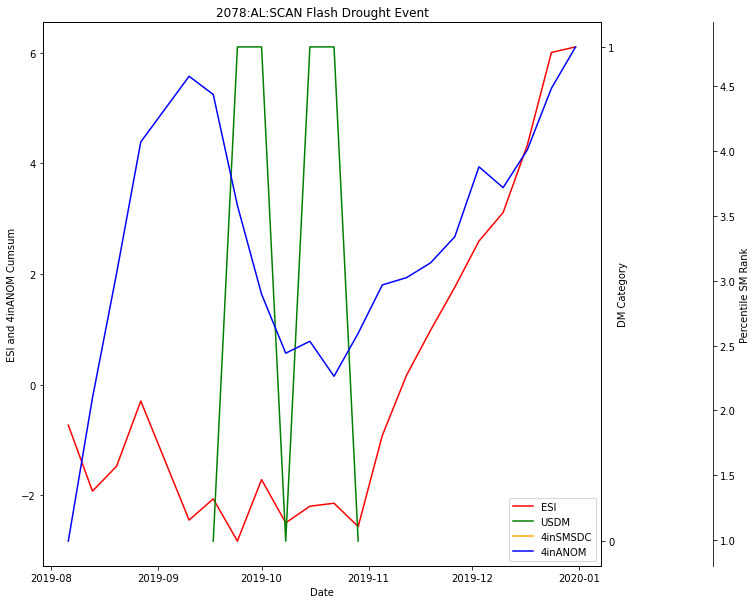

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
esi, = ax.plot(ESI_test[(ESI_test.index.month >= 8) & (ESI_test.index.year==2019)]['ESI'].cumsum(), label="ESI", color='red')
ax2 = ax.twinx()
ax2.yaxis.set_ticks([0, 1, 2, 3, 4])
ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.2))
dm, = ax2.plot(DM_test[(DM_test.index.month >= 8) & (DM_test.index.year==2019)]['Category'], label="USDM", color='green')
smdm, = ax2.plot(SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2019)]['4inSMSDC'], label="4inSMSDC", color='orange')
sm4, = ax3.plot(SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2019)]['4inANOM'].cumsum(), label="4inANOM", color='blue')

#smdm2, = ax2.plot(SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2019)]['2inSMSDC'], label="2inSMDC", color='yellow')
ax.legend(handles=[esi, dm, smdm, sm4], loc='lower right')
ax.set_xlabel('Date')
ax2.set_ylabel('DM Category')
ax3.set_ylabel('Percentile SM Rank')
ax.set_ylabel('ESI and 4inANOM Cumsum')
ax.set_title('2078:AL:SCAN Flash Drought Event')

In [38]:
SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2019)]['4inSMSDC']

Date
2019-08-06    NaN
2019-08-13    NaN
2019-08-20    NaN
2019-08-27    NaN
2019-09-10    NaN
2019-09-17    NaN
2019-09-24    NaN
2019-10-01    0.0
2019-10-08    NaN
2019-10-15    NaN
2019-10-22    NaN
2019-10-29    NaN
2019-11-05    NaN
2019-11-12    NaN
2019-11-19    NaN
2019-11-26    NaN
2019-12-03    NaN
2019-12-10    NaN
2019-12-17    NaN
2019-12-24    NaN
2019-12-31    NaN
Name: 4inSMSDC, dtype: float64

Text(0.5, 1.0, '2078:AL:SCAN Flash Drought Event')

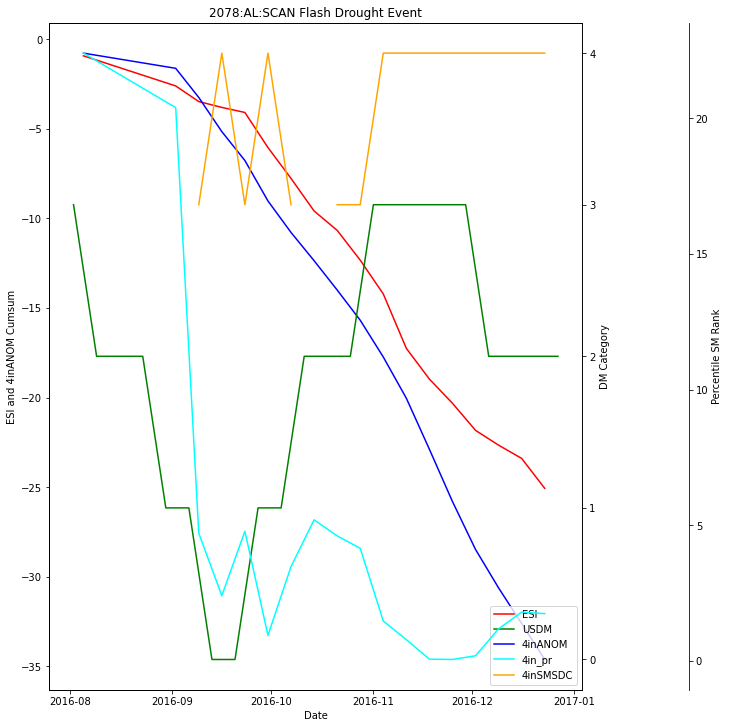

In [39]:
fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)
esi, = ax.plot(ESI_test[(ESI_test.index.month >= 8) & (ESI_test.index.year==2016)]['ESI'].cumsum(), label="ESI", color='red')
ax2 = ax.twinx()
ax2.set_yticks([0, 1, 2, 3, 4]) 
ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.2))
dm, = ax2.plot(DM_test[(DM_test.index.month >= 8) & (DM_test.index.year==2016)]['Category'], label="USDM", color='green')
smdm, = ax2.plot(SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2016)]['4inSMSDC'], label="4inSMSDC", color='orange')
sm4, = ax.plot(SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2016)]['4inANOM'].cumsum(), label="4inANOM", color='blue')
smpr4, = ax3.plot(SMSDM_test[(SMSDM_test.index.month >= 8) & (SMSDM_test.index.year==2016)]['4in_pr'], label="4in_pr", color='cyan')
ax.legend(handles=[esi, dm, sm4, smpr4, smdm], loc='lower right')
ax.set_xlabel('Date')
ax2.set_ylabel('DM Category')
ax3.set_ylabel('Percentile SM Rank')
ax.set_ylabel('ESI and 4inANOM Cumsum')
ax.set_title('2078:AL:SCAN Flash Drought Event')

In [40]:
ESI_test

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2003-08-27 -1.783  2078:AL:SCAN      35      35       NaN       NaN       NaN   
2003-09-10  0.396  2078:AL:SCAN      37      37  2.164270  0.998736  1.390679   
2003-09-17  0.035  2078:AL:SCAN      38      38  1.314586  0.670494  0.635382   
2003-09-24  1.165  2078:AL:SCAN      39      39  1.862839  0.846438  1.246991   
2003-10-01  0.046  2078:AL:SCAN      40      40  1.779189  0.627369  1.333774   
...           ...           ...     ...     ...       ...       ...       ...   
2020-04-15 -0.105  2078:AL:SCAN      16      16  1.448394  0.598713  3.116271   
2020-04-22  0.244  2078:AL:SCAN      17      17  1.529283  0.737754  3.218922   
2020-04-29  1.244  2078:AL:SCAN      18      18  1.442555  0.962767  3.190488   
2020-05-06 -0.487  2078:AL:SCAN      19      19  0.851080  0.384983  2.874805   
2020-05-13  0.253  2078:AL:SCAN      20      20  1.735319  0.712805       NaN   

            20inANOM  40inANOM     2in_pr     4in_pr     8in_pr    20in_pr  \
Date                                                                         
2003-08-27       NaN       NaN        NaN        NaN        NaN        NaN   
2003-09-10  2.639969  1.948964  99.661091  85.140379  94.662828  99.966247   
2003-09-17  2.320282  1.586560  93.254619  72.380735  72.727273  99.842484   
2003-09-24  2.889176  1.446026  98.720892  79.833371  91.828147  99.988749   
2003-10-01  2.580136  1.672270  98.283590  70.554668  93.422655  99.954995   
...              ...       ...        ...        ...        ...        ...   
2020-04-15  1.197821 -0.174465  95.331803  69.550331  99.778541  91.415392   
2020-04-22  1.277831 -0.579650  96.239204  75.450810  99.889270  93.103060   
2020-04-29  1.020041 -0.582725  95.244342  83.884958  99.844978  86.701170   
2020-05-06  0.996195 -0.444693  79.731059  61.321616  99.756395  85.924842   
2020-05-13  1.206543 -0.558616  98.108670  74.355170        NaN  91.629163   

              40in_pr  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  
Date                                                                       
2003-08-27        NaN       NaN       NaN       NaN        NaN        NaN  
2003-09-10  99.279873       NaN       NaN       NaN        NaN        NaN  
2003-09-17  97.253753       NaN       NaN       NaN        NaN        NaN  
2003-09-24  95.483950       NaN       NaN       NaN        NaN        NaN  
2003-10-01  98.047113       NaN       NaN       NaN        NaN        NaN  
...               ...       ...       ...       ...        ...        ...  
2020-04-15  42.646161       NaN       NaN       NaN        NaN        NaN  
2020-04-22  29.537410       NaN       NaN       NaN        NaN        0.0  
2020-04-29  29.464177       NaN       NaN       NaN        NaN        0.0  
2020-05-06  33.894788       NaN       NaN       NaN        NaN        NaN  
2020-05-13  30.117173       NaN       NaN       NaN        NaN        NaN  

[706 rows x 19 columns]

In [41]:
drought_data['Date']=pd.to_datetime(drought_data['Date'])

In [42]:
drought_data.set_index('Date', inplace=True)

In [43]:
flash_2019 = drought_data[(drought_data.index.year==2019)&(drought_data.index.month>=8)]

In [44]:
SM_VS_ESI_ANOM_READ['Date']=pd.to_datetime(SM_VS_ESI_ANOM_READ['Date'])

In [45]:
SM_VS_ESI_ANOM_READ.set_index('Date', inplace=True)

In [46]:
SM_ESI_flash_2019 = SM_VS_ESI_ANOM_READ[(SM_VS_ESI_ANOM_READ.index.year==2019)&(SM_VS_ESI_ANOM_READ.index.month>=8)]

In [47]:
SM_ESI_flash_2019

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2019-08-06  0.581  2057:AL:SCAN      32      32 -0.320020  0.553622  0.785686   
2019-08-13  0.210  2057:AL:SCAN      33      33 -0.262023  0.853190  0.985721   
2019-08-20 -0.333  2057:AL:SCAN      34      34 -1.076246  0.525206  0.761227   
2019-08-27 -0.945  2057:AL:SCAN      35      35 -0.780767  0.251437  0.542510   
2019-09-03 -1.315  2057:AL:SCAN      36      36 -0.866953  0.155705  0.471759   
...           ...           ...     ...     ...       ...       ...       ...   
2019-12-03 -0.640  2053:AL:SCAN      49      49  1.150144  1.130342  1.101391   
2019-12-10  0.140  2053:AL:SCAN      50      50  1.031959  0.992935  1.385743   
2019-12-17  0.213  2053:AL:SCAN      51      51  0.535768  0.429769  0.578262   
2019-12-24  1.394  2053:AL:SCAN      52      52  0.778315  0.916498  1.048247   
2019-12-31 -0.644  2053:AL:SCAN       1       1  1.073521  1.284879  1.138990   

            20inANOM  40inANOM     2in_pr     4in_pr     8in_pr    20in_pr  \
Date                                                                         
2019-08-06  0.961752  1.143419  37.279983  67.792741  78.651312  84.777228   
2019-08-13  0.998732  1.210929  39.198644  80.015978  84.962906  85.969847   
2019-08-20  1.012649  1.018275  14.649612  66.697101  77.854058  86.374887   
2019-08-27  0.906686  0.841734  22.750629  56.493951  69.084265  82.740774   
2019-09-03  0.566161  0.510153  20.454794  53.332572  66.050271  69.903240   
...              ...       ...        ...        ...        ...        ...   
2019-12-03  0.734631  1.250638  89.625014  89.226204  88.461964  76.462646   
2019-12-10  0.975073  1.056672  85.995408  84.923533  94.607463  85.182268   
2019-12-17  0.550751  0.735964  66.950913  63.102031  70.479460  69.273177   
2019-12-24  0.353277  0.566720  76.801137  82.321388  87.000332  60.587309   
2019-12-31  0.789787  0.596466  87.460370  92.581602  89.458532  78.921017   

              40in_pr  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  
Date                                                                       
2019-08-06  89.271329       NaN       NaN       NaN        NaN        NaN  
2019-08-13  91.212010       NaN       NaN       NaN        NaN        NaN  
2019-08-20  85.316734       1.0       NaN       NaN        NaN        NaN  
2019-08-27  78.908825       0.0       NaN       NaN        NaN        NaN  
2019-09-03  65.897718       NaN       NaN       NaN        NaN        NaN  
...               ...       ...       ...       ...        ...        ...  
2019-12-03  92.029782       NaN       NaN       NaN        NaN        NaN  
2019-12-10  86.451849       NaN       NaN       NaN        NaN        NaN  
2019-12-17  74.551446       NaN       NaN       NaN        NaN        NaN  
2019-12-24  67.838399       NaN       NaN       NaN        NaN        NaN  
2019-12-31  69.126083       NaN       NaN       NaN        NaN        NaN  

[343 rows x 19 columns]

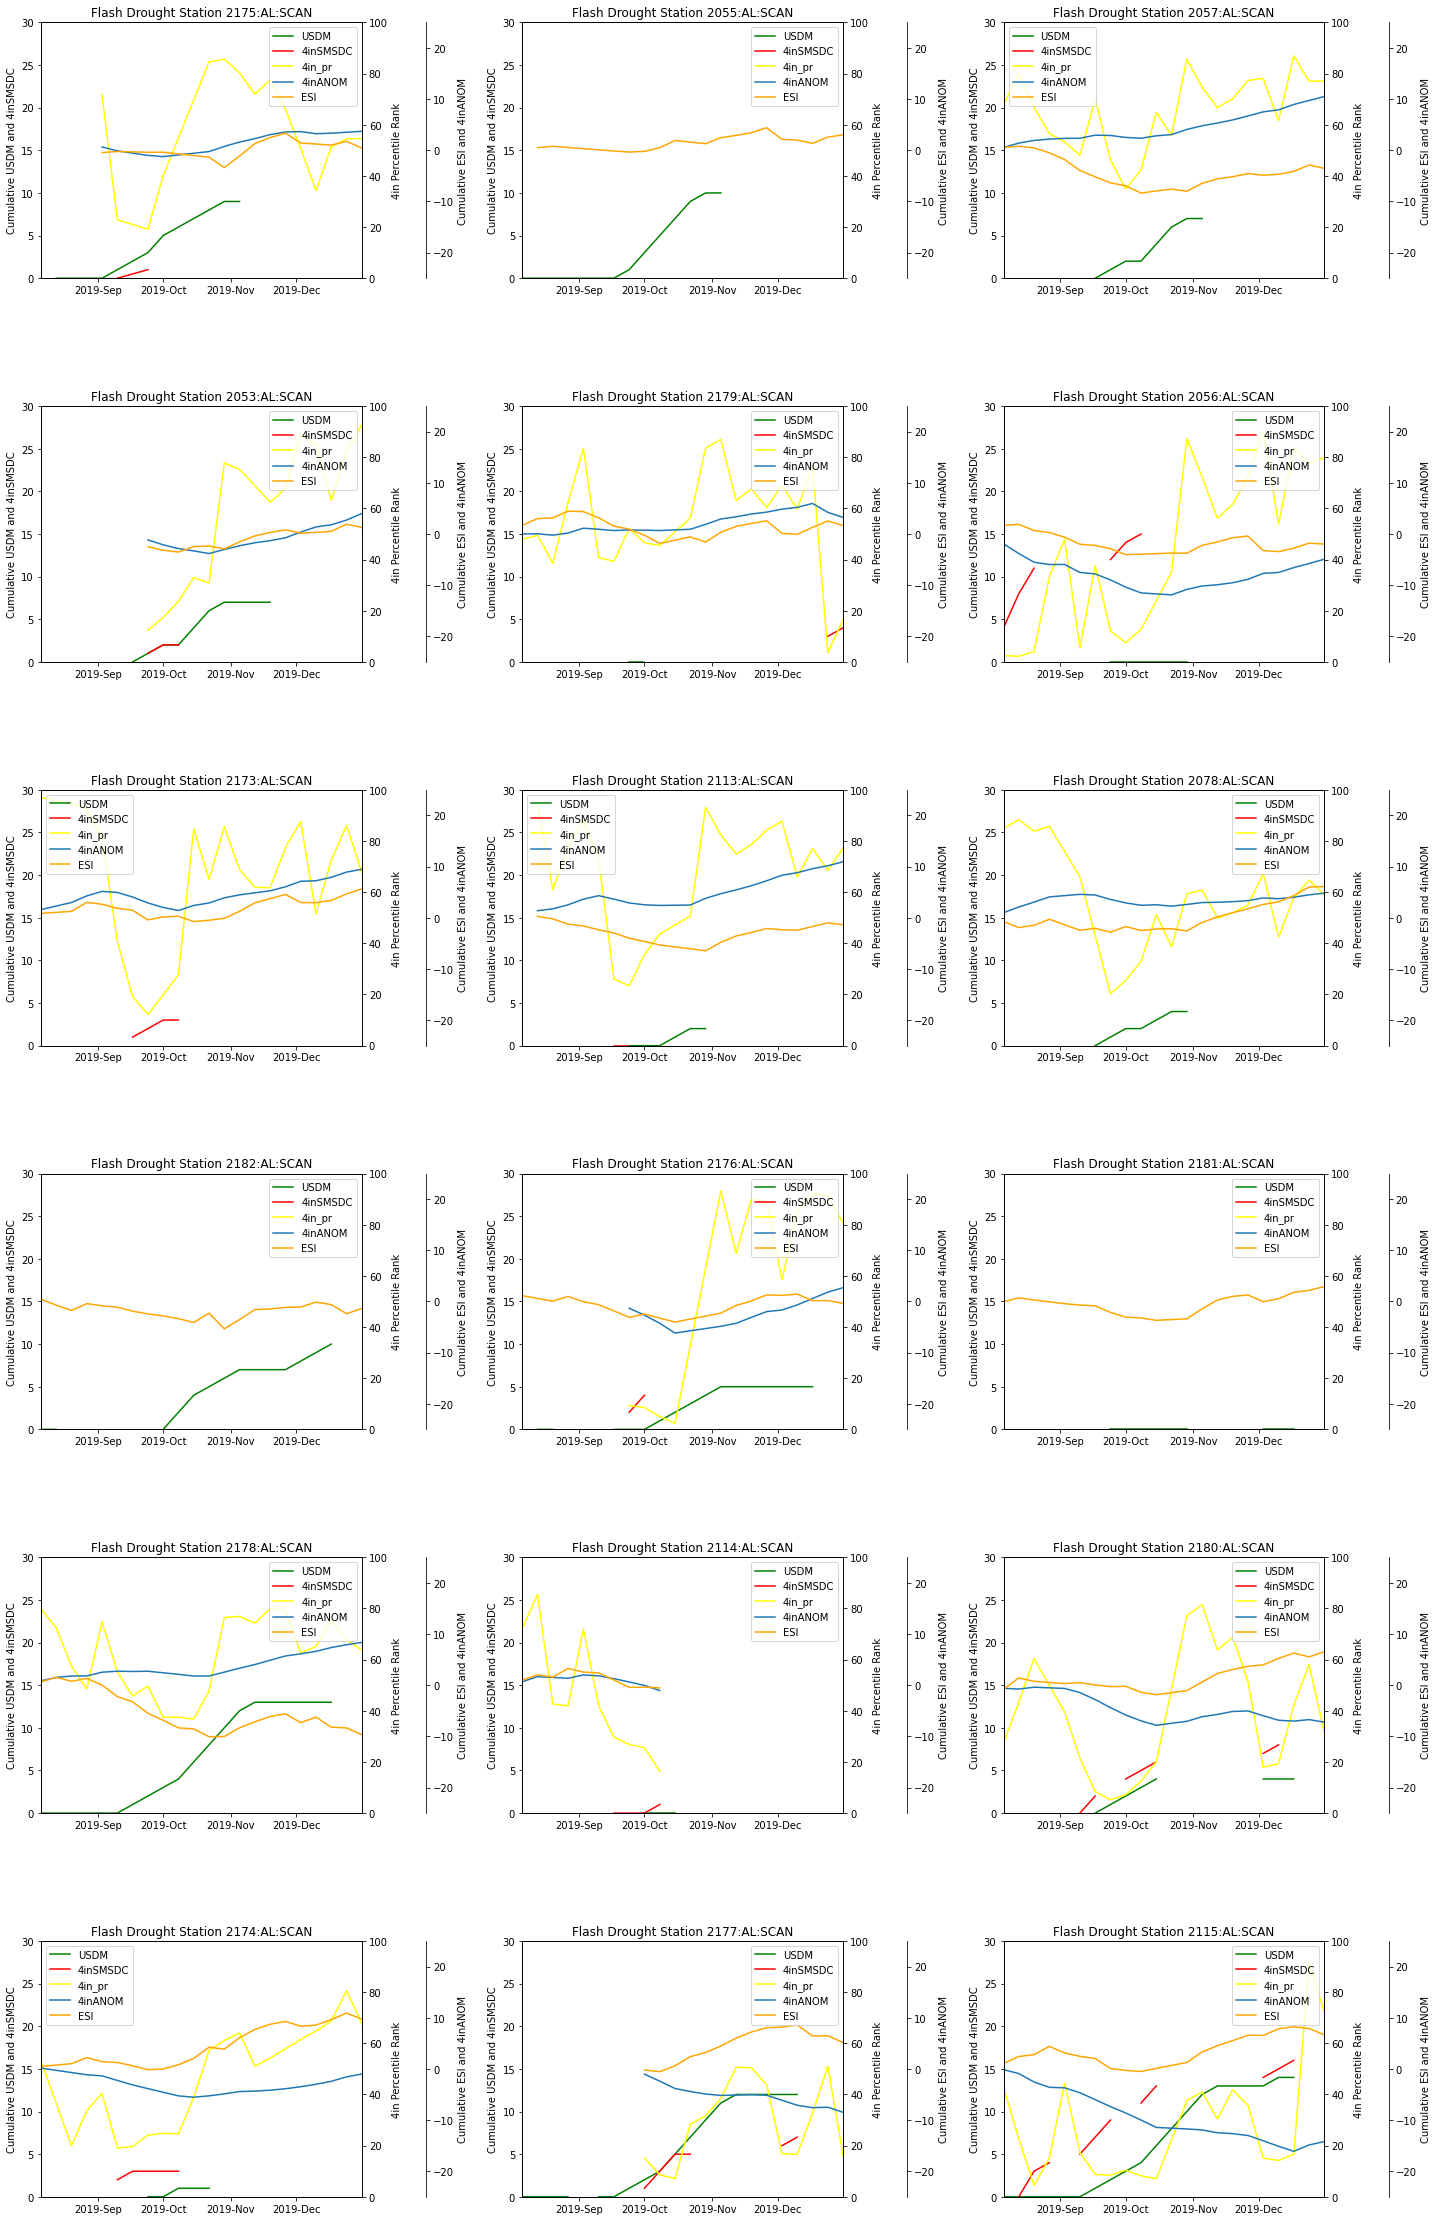

In [48]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(23,40), nrows=6, ncols=3)
axes = ax.flatten()
count = 0
for s in flash_2019['station'].unique():
    USDM = flash_2019[flash_2019['station']==s]['Category']
    xticks = [month for month in USDM.index.month]
    USDM_h, = axes[count].plot(USDM.cumsum(), label='USDM', color='green')
    axes[count].set_xlim(USDM.index[0], USDM.index[-1])
    axes[count].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[count].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    axes[count].set_title('Flash Drought Station '+ s)
    axes[count].set_ylabel('Cumulative USDM and 4inSMSDC')
    
    #plot the actual sm drought category
    sm4inDC = SM_ESI_flash_2019[SM_ESI_flash_2019['station']==s]['4inSMSDC']
    smdc, = axes[count].plot(sm4inDC.cumsum(), label='4inSMSDC', color='red')
    axes[count].set_ylim(0, 30)
    
    #now lets plot pr for sm
    axes2 = axes[count].twinx()
    smpr, = axes2.plot(SM_ESI_flash_2019[SM_ESI_flash_2019['station']==s]['4in_pr'], label='4in_pr', color='yellow')
    axes2.set_ylim(0,100)
    axes2.set_ylabel('4in Percentile Rank')
    
    #now lets plot SM cumsum
    axes3 = axes[count].twinx()
    axes3.spines.right.set_position(("axes", 1.2))
    sms4ANOM, = axes3.plot(SM_ESI_flash_2019[SM_ESI_flash_2019['station']==s]['4inANOM'].cumsum(), label='4inANOM')
    axes3.set_ylim(-25,25)
    
    #now lets plot ESI cumsum
    ESI, = axes3.plot(SM_ESI_flash_2019[SM_ESI_flash_2019['station']==s]['ESI'].cumsum(), label='ESI', color='orange')
    axes3.legend(handles=[USDM_h, smdc, smpr, sms4ANOM, ESI])
    axes3.set_ylabel('Cumulative ESI and 4inANOM')
    count+=1
plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [49]:
SM_ESI_flash_2019.reset_index(inplace=True)

In [50]:
flash_2019.reset_index(inplace=True)

In [51]:
combined = SM_ESI_flash_2019.merge(flash_2019, on=['station', 'Date'])

In [52]:
combined.set_index('Date', inplace=True)

In [53]:
df = combined[(combined.index.month>=8)&(combined.index.month<=12)]
df.columns

Index(['ESI', 'station', 'week_x', 'week_y', '2inANOM', '4inANOM', '8inANOM',
       '20inANOM', '40inANOM', '2in_pr', '4in_pr', '8in_pr', '20in_pr',
       '40in_pr', '2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC', '40inSMSDC',
       'point', 'Category', 'Station Name'],
      dtype='object')

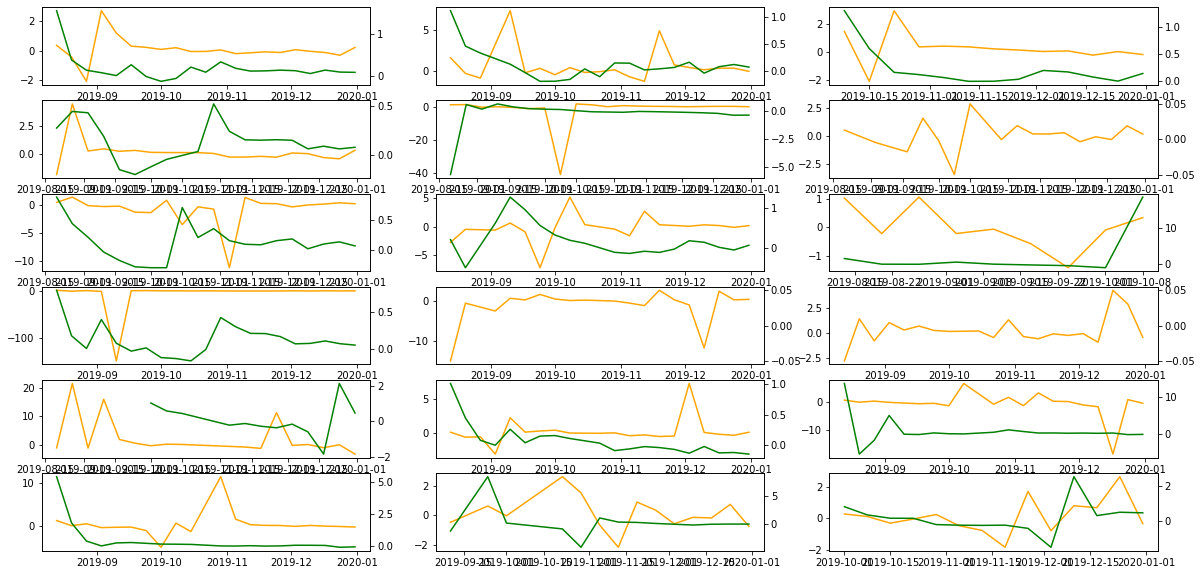

In [54]:
fig, ax = plt.subplots(figsize=(20,10), nrows=6, ncols=3)
axes=ax.flatten()
count=0
for s in df['station'].unique():
    station = df[df['station']==s]
    station = station[['ESI', '2inANOM', '4inANOM', '8inANOM',
       '20inANOM', '40inANOM', '2in_pr', '4in_pr', '8in_pr', '20in_pr',
       '40in_pr', '2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC', '40inSMSDC', 'Category',]]
    station['ESI']=station['ESI'].cumsum().pct_change()
    axes[count].plot(station['ESI'], label='ESI pct change', color='orange')
    axes2 = axes[count].twinx()
    axes2.plot(station['4inANOM'].cumsum().pct_change(), label='4inANOM',color='green')
    count+=1

In [55]:
df['ESI']=df['ESI'].pct_change()

In [56]:
df

ESI       station  week_x  week_y   2inANOM   4inANOM  \
Date                                                                     
2019-08-06       NaN  2057:AL:SCAN      32      32 -0.320020  0.553622   
2019-08-13 -0.638554  2057:AL:SCAN      33      33 -0.262023  0.853190   
2019-08-20 -2.585714  2057:AL:SCAN      34      34 -1.076246  0.525206   
2019-08-27  1.837838  2057:AL:SCAN      35      35 -0.780767  0.251437   
2019-09-03  0.391534  2057:AL:SCAN      36      36 -0.866953  0.155705   
...              ...           ...     ...     ...       ...       ...   
2019-12-03 -2.245136  2053:AL:SCAN      49      49  1.150144  1.130342   
2019-12-10 -1.218750  2053:AL:SCAN      50      50  1.031959  0.992935   
2019-12-17  0.521429  2053:AL:SCAN      51      51  0.535768  0.429769   
2019-12-24  5.544601  2053:AL:SCAN      52      52  0.778315  0.916498   
2019-12-31 -1.461980  2053:AL:SCAN       1       1  1.073521  1.284879   

             8inANOM  20inANOM  40inANOM     2in_pr  ...    20in_pr  \
Date                                                 ...              
2019-08-06  0.785686  0.961752  1.143419  37.279983  ...  84.777228   
2019-08-13  0.985721  0.998732  1.210929  39.198644  ...  85.969847   
2019-08-20  0.761227  1.012649  1.018275  14.649612  ...  86.374887   
2019-08-27  0.542510  0.906686  0.841734  22.750629  ...  82.740774   
2019-09-03  0.471759  0.566161  0.510153  20.454794  ...  69.903240   
...              ...       ...       ...        ...  ...        ...   
2019-12-03  1.101391  0.734631  1.250638  89.625014  ...  76.462646   
2019-12-10  1.385743  0.975073  1.056672  85.995408  ...  85.182268   
2019-12-17  0.578262  0.550751  0.735964  66.950913  ...  69.273177   
2019-12-24  1.048247  0.353277  0.566720  76.801137  ...  60.587309   
2019-12-31  1.138990  0.789787  0.596466  87.460370  ...  78.921017   

              40in_pr  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  \
Date                                                                        
2019-08-06  89.271329       NaN       NaN       NaN        NaN        NaN   
2019-08-13  91.212010       NaN       NaN       NaN        NaN        NaN   
2019-08-20  85.316734       1.0       NaN       NaN        NaN        NaN   
2019-08-27  78.908825       0.0       NaN       NaN        NaN        NaN   
2019-09-03  65.897718       NaN       NaN       NaN        NaN        NaN   
...               ...       ...       ...       ...        ...        ...   
2019-12-03  92.029782       NaN       NaN       NaN        NaN        NaN   
2019-12-10  86.451849       NaN       NaN       NaN        NaN        NaN   
2019-12-17  74.551446       NaN       NaN       NaN        NaN        NaN   
2019-12-24  67.838399       NaN       NaN       NaN        NaN        NaN   
2019-12-31  69.126083       NaN       NaN       NaN        NaN        NaN   

                              point  Category Station Name  
Date                                                        
2019-08-06  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
2019-08-13  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
2019-08-20  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
2019-08-27  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
2019-09-03  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
...                             ...       ...          ...  
2019-12-03   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-10   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-17   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-24   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-31   POINT (-86.53333 34.9)       NaN        Wtars  

[343 rows x 22 columns]

In [57]:
drought_data

point  Category Station Name       station
Date                                                                       
2000-01-04  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-01-11  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-01-18  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-01-25  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-02-01  POINT (-85.51818 33.33168)       1.0      Wedowee  2175:AL:SCAN
...                                ...       ...          ...           ...
2020-12-01  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-08  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-15  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-22  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-29  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN

[19728 rows x 4 columns]

In [58]:
df = SM_VS_ESI_ANOM_READ.merge(drought_data, on=['station','Date'])

df

In [59]:
import seaborn as sns

In [60]:
df

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2002-04-30 -0.527  2057:AL:SCAN      18      18 -1.839516 -2.608769 -2.434962   
2002-05-21  1.565  2057:AL:SCAN      21      21 -0.349508 -1.356723 -1.702116   
2002-05-28  1.484  2057:AL:SCAN      22      22 -0.234778 -0.972001 -1.546049   
2002-06-11  0.419  2057:AL:SCAN      24      24 -1.524178 -1.680948 -1.660611   
2002-06-18  1.374  2057:AL:SCAN      25      25 -0.737961 -1.484239 -2.253738   
...           ...           ...     ...     ...       ...       ...       ...   
2019-12-03 -0.640  2053:AL:SCAN      49      49  1.150144  1.130342  1.101391   
2019-12-10  0.140  2053:AL:SCAN      50      50  1.031959  0.992935  1.385743   
2019-12-17  0.213  2053:AL:SCAN      51      51  0.535768  0.429769  0.578262   
2019-12-24  1.394  2053:AL:SCAN      52      52  0.778315  0.916498  1.048247   
2019-12-31 -0.644  2053:AL:SCAN       1       1  1.073521  1.284879  1.138990   

            20inANOM  40inANOM     2in_pr  ...    20in_pr    40in_pr  \
Date                                       ...                         
2002-04-30 -2.084585 -1.598313   2.459823  ...   1.901440   4.357378   
2002-05-21 -1.692849 -0.663807  36.405379  ...   4.466697  26.913219   
2002-05-28 -1.441618 -0.890192  40.024052  ...   7.684518  18.943000   
2002-06-11 -1.608081 -0.872815   5.914507  ...   5.569307  19.602099   
2002-06-18 -2.101628 -0.901292  23.854816  ...   1.822682  18.674478   
...              ...       ...        ...  ...        ...        ...   
2019-12-03  0.734631  1.250638  89.625014  ...  76.462646  92.029782   
2019-12-10  0.975073  1.056672  85.995408  ...  85.182268  86.451849   
2019-12-17  0.550751  0.735964  66.950913  ...  69.273177  74.551446   
2019-12-24  0.353277  0.566720  76.801137  ...  60.587309  67.838399   
2019-12-31  0.789787  0.596466  87.460370  ...  78.921017  69.126083   

            2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  \
Date                                                             
2002-04-30       4.0       4.0       4.0        4.0        3.0   
2002-05-21       NaN       2.0       3.0        3.0        0.0   
2002-05-28       NaN       1.0       NaN        2.0        1.0   
2002-06-11       NaN       3.0       3.0        NaN        1.0   
2002-06-18       0.0       2.0       4.0        4.0        1.0   
...              ...       ...       ...        ...        ...   
2019-12-03       NaN       NaN       NaN        NaN        NaN   
2019-12-10       NaN       NaN       NaN        NaN        NaN   
2019-12-17       NaN       NaN       NaN        NaN        NaN   
2019-12-24       NaN       NaN       NaN        NaN        NaN   
2019-12-31       NaN       NaN       NaN        NaN        NaN   

                              point  Category Station Name  
Date                                                        
2002-04-30  POINT (-86.55 34.78333)       0.0     AAMU-JTG  
2002-05-21  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
2002-05-28  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
2002-06-11  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
2002-06-18  POINT (-86.55 34.78333)       NaN     AAMU-JTG  
...                             ...       ...          ...  
2019-12-03   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-10   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-17   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-24   POINT (-86.53333 34.9)       NaN        Wtars  
2019-12-31   POINT (-86.53333 34.9)       NaN        Wtars  

[1949 rows x 22 columns]

In [61]:
drought_data[(drought_data['station']=='2057:AL:SCAN')&(drought_data.index.year>=2004)&(drought_data.index.month>=4)]

point  Category Station Name       station
Date                                                                    
2004-04-06  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2004-04-13  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2004-04-20  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2004-04-27  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2004-05-04  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
...                             ...       ...          ...           ...
2020-12-01  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2020-12-08  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2020-12-15  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2020-12-22  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2020-12-29  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN

[667 rows x 4 columns]

In [62]:
SM_VS_ESI_ANOM_READ[(SM_VS_ESI_ANOM_READ['station']=='2057:AL:SCAN')&(SM_VS_ESI_ANOM_READ.index.year==2004)]

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2004-01-01 -0.191  2057:AL:SCAN       1       1  0.307374 -0.827580 -0.540777   
2004-01-08  1.332  2057:AL:SCAN       2       2 -0.283798 -1.078127 -1.020622   
2004-01-15  0.574  2057:AL:SCAN       3       3 -0.102735 -1.174363 -1.009023   
2004-01-22 -0.361  2057:AL:SCAN       4       4 -0.141601 -1.201839 -0.997620   
2004-01-29 -0.336  2057:AL:SCAN       5       5  0.056995 -1.153986 -0.946312   
2004-02-05 -0.378  2057:AL:SCAN       6       6 -0.264735 -1.852535 -1.287358   
2004-02-12  0.622  2057:AL:SCAN       7       7  0.129697 -0.856487 -0.807563   
2004-02-26 -0.108  2057:AL:SCAN       9       9 -0.424931 -1.762096 -0.939458   
2004-03-04  0.320  2057:AL:SCAN      10      10  0.322596 -0.937536  0.218877   
2004-03-11 -0.845  2057:AL:SCAN      11      11  0.304249 -0.506040  0.323889   
2004-03-18  0.186  2057:AL:SCAN      12      12 -0.653925 -1.541691  0.167704   
2004-03-25 -1.601  2057:AL:SCAN      13      13 -0.330178 -1.174369  0.118098   
2004-04-01 -1.018  2057:AL:SCAN      14      14 -0.796736 -1.748899 -1.457664   
2004-04-08  0.812  2057:AL:SCAN      15      15 -0.620206 -1.632929 -0.679830   
2004-04-15  1.860  2057:AL:SCAN      16      16 -0.214799 -1.081060 -0.518601   
2004-04-22  0.366  2057:AL:SCAN      17      17 -0.399838 -1.210466 -0.577810   
2004-04-29  0.089  2057:AL:SCAN      18      18  0.236358 -0.663291 -0.369915   
2004-05-06  0.035  2057:AL:SCAN      19      19  1.011528 -0.432241 -0.129527   
2004-05-13  0.851  2057:AL:SCAN      20      20  0.074174 -1.148645 -0.715241   
2004-05-27  0.514  2057:AL:SCAN      22      22  0.285674 -1.001319 -0.494834   
2004-06-10  0.894  2057:AL:SCAN      24      24  0.237167 -0.538410  0.848350   
2004-06-24  1.991  2057:AL:SCAN      26      26 -0.552528 -0.821732 -0.003018   
2004-07-01  1.898  2057:AL:SCAN      27      27  0.581833  0.207504  0.672230   
2004-07-15  1.010  2057:AL:SCAN      29      29 -0.589365 -1.243833 -0.157517   
2004-07-22  0.749  2057:AL:SCAN      30      30  0.137165 -0.258807  0.283622   
2004-07-29  1.577  2057:AL:SCAN      31      31  0.109007 -0.253220  0.139936   
2004-08-05  1.123  2057:AL:SCAN      32      32  0.288094 -0.200566  0.203272   
2004-08-12 -0.748  2057:AL:SCAN      33      33 -0.798337 -0.930145 -0.350589   
2004-08-19  0.255  2057:AL:SCAN      34      34 -0.612359 -0.975788 -0.464766   
2004-08-26  0.907  2057:AL:SCAN      35      35 -0.451244 -1.113317 -0.597269   
2004-09-09 -0.914  2057:AL:SCAN      37      37 -0.344349 -0.655412 -0.101192   
2004-09-16  0.781  2057:AL:SCAN      38      38 -1.179236 -1.036804 -0.400654   
2004-09-23 -0.053  2057:AL:SCAN      39      39  0.448018 -0.352166  0.072416   
2004-09-30  1.272  2057:AL:SCAN      40      40 -0.685064 -1.115365 -0.467523   
2004-10-07  0.382  2057:AL:SCAN      41      41 -1.076916 -1.364852 -0.593323   
2004-10-21  0.429  2057:AL:SCAN      43      43  0.281147 -0.594001  0.057417   
2004-10-28  0.093  2057:AL:SCAN      44      44  0.098236 -0.645193 -0.226229   
2004-11-04 -0.314  2057:AL:SCAN      45      45  0.632043 -0.084307  0.080180   
2004-11-11 -0.344  2057:AL:SCAN      46      46  0.223975 -0.478405 -0.047238   
2004-11-18  0.959  2057:AL:SCAN      47      47  0.667512 -0.048567  0.198431   
2004-12-02  1.231  2057:AL:SCAN      49      49  1.326138 -0.024435  0.184716   
2004-12-09  1.777  2057:AL:SCAN      50      50  1.469810  0.313222  0.421648   
2004-12-16  0.127  2057:AL:SCAN      51      51  0.822045 -0.387495  0.209296   
2004-12-23 -0.221  2057:AL:SCAN      52      52  0.128715 -0.869965 -0.139583   

            20inANOM  40inANOM     2in_pr     4in_pr     8in_pr    20in_pr  \
Date                                                                         
2004-01-01 -0.784039  0.020601  58.357932  20.874230  28.778651  21.174617   
2004-01-08 -1.579950 -0.122693  38.493495  14.094955 

In [63]:
df.index.year.unique()

Int64Index([2002, 2008, 2013, 2019], dtype='int64', name='Date')

In [64]:
for s in SM_VS_ESI_ANOM_READ['station'].unique():
    #grab the station data for the ESI frame
    station_esi=SM_VS_ESI_ANOM_READ[SM_VS_ESI_ANOM_READ['station']==s]
    
    #grab the station data for the drought frame
    station_dm = drought_data[drought_data['station']==s]
    for y in station_esi.index.year.unique():
        #get the year frame for the ESI station frame 
        ESIyearFrame = station[station.index.year==y]
        
        #get the year frame for the drought monitor station frame
        DMyearFrame = station_dm[station_dm.index.year==y]
        
        #get the monthFrame for the ESI
        for m in ESIyearFrame.index.month.unique():
            ESImonthFrame=ESIyearFrame[ESIyearFrame.index.month==m]
            DMmonthFrame=DMyearFrame[DMyearFrame.index.month==m]
            
            #print out each day
            print(ESImonthFrame, DMmonthFrame)

            ESI   2inANOM   4inANOM   8inANOM  20inANOM  40inANOM     2in_pr  \
Date                                                                           
2019-09-24  NaN -0.159274 -1.152774 -0.180746  1.095121 -0.882577  42.647863   

              4in_pr     8in_pr    20in_pr    40in_pr  2inSMSDC  4inSMSDC  \
Date                                                                        
2019-09-24  12.39443  40.504927  88.760126  19.235933       NaN       1.0   

            8inSMSDC  20inSMSDC  40inSMSDC  Category  
Date                                                  
2019-09-24       NaN        NaN        1.0       1.0                                 point  Category Station Name       station
Date                                                                    
2019-09-03  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2019-09-10  POINT (-86.55 34.78333)       NaN     AAMU-JTG  2057:AL:SCAN
2019-09-17  POINT (-86.55 34.78333)       0.0     AAMU-JTG  2057:AL:SC

2019-12-31       NaN       NaN        NaN        NaN       NaN                                   point  Category Station Name       station
Date                                                                      
2019-12-03  POINT (-86.16557 34.4448)       NaN       Hodges  2055:AL:SCAN
2019-12-10  POINT (-86.16557 34.4448)       NaN       Hodges  2055:AL:SCAN
2019-12-17  POINT (-86.16557 34.4448)       NaN       Hodges  2055:AL:SCAN
2019-12-24  POINT (-86.16557 34.4448)       NaN       Hodges  2055:AL:SCAN
2019-12-31  POINT (-86.16557 34.4448)       NaN       Hodges  2055:AL:SCAN
            ESI   2inANOM   4inANOM   8inANOM  20inANOM  40inANOM     2in_pr  \
Date                                                                           
2019-09-24  NaN -0.159274 -1.152774 -0.180746  1.095121 -0.882577  42.647863   

              4in_pr     8in_pr    20in_pr    40in_pr  2inSMSDC  4inSMSDC  \
Date                                                                        
2019-09-24  12.

                 ESI   2inANOM   4inANOM   8inANOM  20inANOM  40inANOM  \
Date                                                                     
2019-12-03 -0.784314  1.150144  1.130342  1.101391  0.734631  1.250638   
2019-12-10  0.795455  1.031959  0.992935  1.385743  0.975073  1.056672   
2019-12-17  0.674051  0.535768  0.429769  0.578262  0.550751  0.735964   
2019-12-24  2.635161  0.778315  0.916498  1.048247  0.353277  0.566720   
2019-12-31 -0.334893  1.073521  1.284879  1.138990  0.789787  0.596466   

               2in_pr     4in_pr     8in_pr    20in_pr    40in_pr  2inSMSDC  \
Date                                                                          
2019-12-03  89.625014  89.226204  88.461964  76.462646  92.029782       NaN   
2019-12-10  85.995408  84.923533  94.607463  85.182268  86.451849       NaN   
2019-12-17  66.950913  63.102031  70.479460  69.273177  74.551446       NaN   
2019-12-24  76.801137  82.321388  87.000332  60.587309  67.838399       NaN   
2019-12

2019-12-31       NaN       NaN        NaN        NaN       NaN                                point  Category Station Name       station
Date                                                                   
2019-12-03  POINT (-86.53333 34.9)       NaN        Wtars  2053:AL:SCAN
2019-12-10  POINT (-86.53333 34.9)       NaN        Wtars  2053:AL:SCAN
2019-12-17  POINT (-86.53333 34.9)       NaN        Wtars  2053:AL:SCAN
2019-12-24  POINT (-86.53333 34.9)       NaN        Wtars  2053:AL:SCAN
2019-12-31  POINT (-86.53333 34.9)       NaN        Wtars  2053:AL:SCAN


In [65]:
drought_data

point  Category Station Name       station
Date                                                                       
2000-01-04  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-01-11  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-01-18  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-01-25  POINT (-85.51818 33.33168)       2.0      Wedowee  2175:AL:SCAN
2000-02-01  POINT (-85.51818 33.33168)       1.0      Wedowee  2175:AL:SCAN
...                                ...       ...          ...           ...
2020-12-01  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-08  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-15  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-22  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN
2020-12-29  POINT (-85.74802 32.43455)       NaN     Tuskegee  2115:AL:SCAN

[19728 rows x 4 columns]

In [66]:
drought_data=drought_data.sort_index()
SM_VS_ESI_ANOM_READ.sort_index()

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2002-02-12 -1.326  2053:AL:SCAN       7       7  0.834835 -0.643664  0.542349   
2002-02-19 -1.577  2053:AL:SCAN       8       8  0.164259 -1.027176  0.290153   
2002-02-26 -1.735  2053:AL:SCAN       9       9  0.106221 -1.050136  0.179310   
2002-03-05 -0.752  2053:AL:SCAN      10      10 -0.309406 -1.455401  0.104532   
2002-03-12 -2.121  2053:AL:SCAN      11      11 -0.113839 -1.455137  0.076642   
...           ...           ...     ...     ...       ...       ...       ...   
2020-12-30  0.047  2115:AL:SCAN      53      53 -0.707107 -0.707107 -0.707107   
2020-12-30  0.266  2177:AL:SCAN      53      53       NaN       NaN       NaN   
2020-12-30  0.208  2175:AL:SCAN      53      53       NaN       NaN       NaN   
2020-12-30 -1.000  2173:AL:SCAN      53      53       NaN       NaN       NaN   
2020-12-30 -0.768  2053:AL:SCAN      53      53       NaN -1.101505  1.154264   

            20inANOM  40inANOM     2in_pr     4in_pr     8in_pr    20in_pr  \
Date                                                                         
2002-02-12 -0.382594 -1.350406  78.965781  26.774709  69.073192  33.190819   
2002-02-19 -0.570702 -0.278074  53.503881  15.373202  59.273613  27.351485   
2002-02-26 -0.718167 -1.268593  51.350169  14.802556  54.722622  23.278578   
2002-03-05 -1.160224 -1.585050  37.640757   6.893403  51.699701  12.207471   
2002-03-12 -1.003007 -1.445378  44.233082   6.904816  50.603477  15.706571   
...              ...       ...        ...        ...        ...        ...   
2020-12-30 -0.707107 -0.707107  24.920739  24.743209  23.856716  23.829883   
2020-12-30       NaN       NaN        NaN        NaN        NaN        NaN   
2020-12-30       NaN       NaN        NaN        NaN        NaN        NaN   
2020-12-30       NaN       NaN        NaN        NaN        NaN        NaN   
2020-12-30  0.418541  1.125623        NaN  13.558548  89.912524  63.602610   

              40in_pr  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  
Date                                                                       
2002-02-12   7.896985       NaN       0.0       NaN        NaN        2.0  
2002-02-19  39.423898       NaN       1.0       NaN        0.0        NaN  
2002-02-26   9.325034       NaN       1.0       NaN        0.0        2.0  
2002-03-05   4.638106       NaN       2.0       NaN        1.0        3.0  
2002-03-12   6.505554       NaN       2.0       NaN        1.0        2.0  
...               ...       ...       ...       ...        ...        ...  
2020-12-30  25.503479       0.0       0.0       0.0        0.0        0.0  
2020-12-30        NaN       NaN       NaN       NaN        NaN        NaN  
2020-12-30        NaN       NaN       NaN       NaN        NaN        NaN  
2020-12-30        NaN       NaN       NaN       NaN        NaN        NaN  
2020-12-30  88.770902       NaN       1.0       NaN        NaN        NaN  

[9674 rows x 19 columns]

In [67]:
drought_data.reset_index(inplace=True)
SM_VS_ESI_ANOM_READ.reset_index(inplace=True)

In [68]:
combined = pd.merge_asof(SM_VS_ESI_ANOM_READ.sort_values('Date'), drought_data.sort_values('Date'), on='Date', by='station', tolerance=pd.Timedelta(7, unit="d"), allow_exact_matches=True)

In [69]:
combined[~combined['point'].isnull()]

Date    ESI       station  week_x  week_y   2inANOM   4inANOM  \
0    2002-02-12 -1.326  2053:AL:SCAN       7       7  0.834835 -0.643664   
1    2002-02-19 -1.577  2053:AL:SCAN       8       8  0.164259 -1.027176   
2    2002-02-26 -1.735  2053:AL:SCAN       9       9  0.106221 -1.050136   
3    2002-03-05 -0.752  2053:AL:SCAN      10      10 -0.309406 -1.455401   
4    2002-03-12 -2.121  2053:AL:SCAN      11      11 -0.113839 -1.455137   
...         ...    ...           ...     ...     ...       ...       ...   
9669 2020-12-30  0.047  2115:AL:SCAN      53      53 -0.707107 -0.707107   
9670 2020-12-30  0.266  2177:AL:SCAN      53      53       NaN       NaN   
9671 2020-12-30  0.208  2175:AL:SCAN      53      53       NaN       NaN   
9672 2020-12-30 -1.000  2173:AL:SCAN      53      53       NaN       NaN   
9673 2020-12-30 -0.768  2053:AL:SCAN      53      53       NaN -1.101505   

       8inANOM  20inANOM  40inANOM  ...    20in_pr    40in_pr  2inSMSDC  \
0     0.542349 -0.382594 -1.350406  ...  33.190819   7.896985       NaN   
1     0.290153 -0.570702 -0.278074  ...  27.351485  39.423898       NaN   
2     0.179310 -0.718167 -1.268593  ...  23.278578   9.325034       NaN   
3     0.104532 -1.160224 -1.585050  ...  12.207471   4.638106       NaN   
4     0.076642 -1.003007 -1.445378  ...  15.706571   6.505554       NaN   
...        ...       ...       ...  ...        ...        ...       ...   
9669 -0.707107 -0.707107 -0.707107  ...  23.829883  25.503479       0.0   
9670       NaN       NaN       NaN  ...        NaN        NaN       NaN   
9671       NaN       NaN       NaN  ...        NaN        NaN       NaN   
9672       NaN       NaN       NaN  ...        NaN        NaN       NaN   
9673  1.154264  0.418541  1.125623  ...  63.602610  88.770902       NaN   

      4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC                       point  \
0          0.0       NaN        NaN        2.0      POINT (-86.53333 34.9)   
1          1.0       NaN        0.0        NaN      POINT (-86.53333 34.9)   
2          1.0       NaN        0.0        2.0      POINT (-86.53333 34.9)   
3          2.0       NaN        1.0        3.0      POINT (-86.53333 34.9)   
4          2.0       NaN        1.0        2.0      POINT (-86.53333 34.9)   
...        ...       ...        ...        ...                         ...   
9669       0.0       0.0        0.0        0.0  POINT (-85.74802 32.43455)   
9670       NaN       NaN        NaN        NaN  POINT (-86.05253 32.28393)   
9671       NaN       NaN        NaN        NaN  POINT (-85.51818 33.33168)   
9672       NaN       NaN        NaN        NaN  POINT (-87.98685 34.81982)   
9673       1.0       NaN        NaN        NaN      POINT (-86.53333 34.9)   

      Category  Station Name  
0          NaN         Wtars  
1          NaN         Wtars  
2          NaN         Wtars  
3          NaN         Wtars  
4          0.0         Wtars  
...        ...           ...  
9669       NaN      Tuskegee  
9670       NaN   Broad Acres  
9671       NaN       Wedowee  
9672       NaN  Isbell Farms  
9673       NaN         Wtars  

[9674 rows x 23 columns]

In [70]:
combined.set_index('Date', inplace=True)
combined.sort_index(inplace=True)

In [71]:
stations = {}
for y in combined.index.year.unique():
    #get the unique year
    yearFrame = combined[combined.index.year==y]
    
    for s in yearFrame.station.unique():
        #in that year, get each station and create new data
        station = yearFrame[yearFrame['station']==s]
        station['ESI_cumsum']=station['ESI'].cumsum()
        station['ESI_pc']=station['ESI'].pct_change()*100.0
        station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
        station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
        station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
        station.reset_index(inplace=True)
        stations[s+str(y)]=station

/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum_pc']=station['ESI'].cumsum().pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

/tmp/ipykernel_18989/2299267856.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inANOM_cumsum']=station['4inANOM'].cumsum()*100.0
/tmp/ipykernel_18989/2299267856.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['4inpc']=station['4in_pr'].diff()/station['4in_pr'].abs().shift()*100.0
/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/2299267856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_cumsum']=station['ESI'].cumsum()
/tmp/ipykernel_18989/2299267856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station['ESI_pc']=station['ESI'].pct_change()*100.0
/tmp/ipykernel_18989/2299267856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [72]:
df = pd.concat(stations, axis=0)

In [73]:
df.set_index('Date', inplace=True)

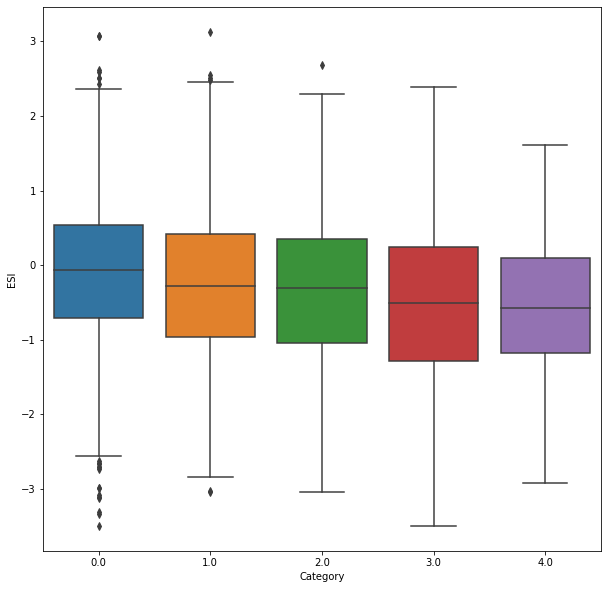

In [74]:
fig, ax=plt.subplots(figsize=(10,10))
g = sns.boxplot(data=df, x='Category', y='ESI')

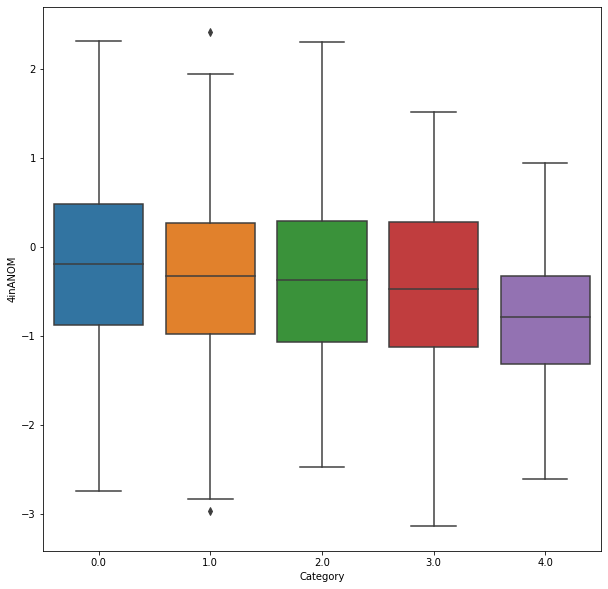

In [75]:
fig, ax=plt.subplots(figsize=(10,10))
g = sns.boxplot(data=df, x='Category', y='4inANOM')

In [76]:
#now for 8-11 months
good_months = df[(df.index.get_level_values('Date').month>=9)&(df.index.get_level_values('Date').month<=11)]

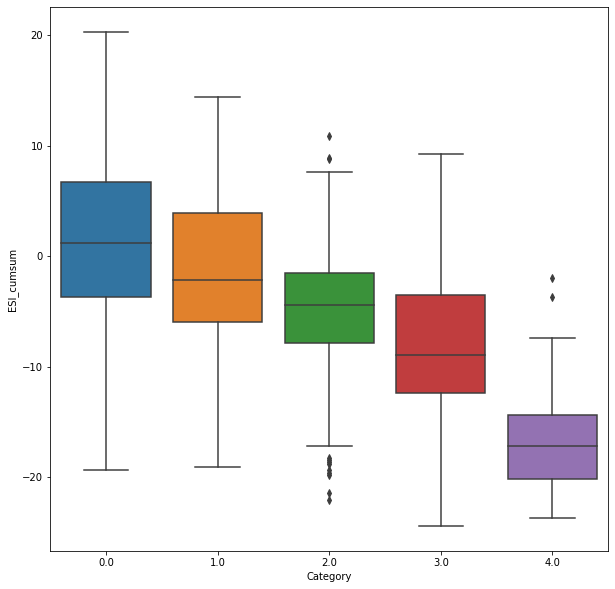

In [77]:
fig, ax=plt.subplots(figsize=(10,10))
g = sns.boxplot(data=good_months, x='Category', y='ESI_cumsum')

In [78]:
df['ESI_bin'] = pd.qcut(df['ESI'],30)

Text(0.5, 0, 'ESI Bin')

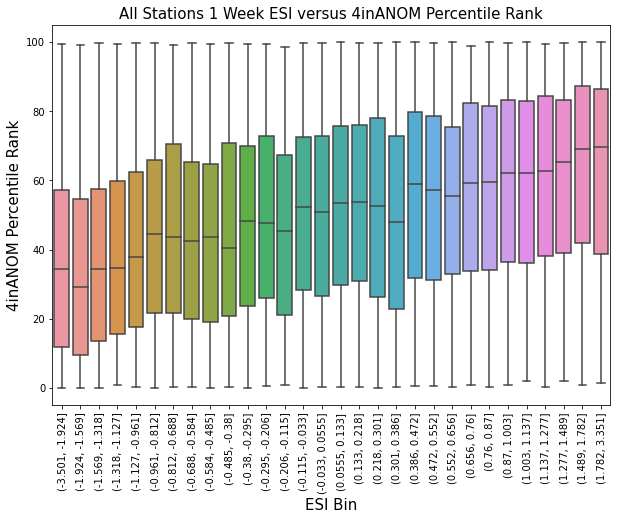

In [79]:
fig, ax=plt.subplots(figsize=(10,7))
g = sns.boxplot(data=df, x='ESI_bin', y='4in_pr', ax=ax)
plt.xticks(rotation=90)
ax.set_title('All Stations 1 Week ESI versus 4inANOM Percentile Rank', fontsize=15)
ax.set_ylabel('4inANOM Percentile Rank', fontsize=15)
ax.set_xlabel('ESI Bin', fontsize=15)

In [80]:
good_months = df[(df.index.get_level_values('Date').month>=9)&(df.index.get_level_values('Date').month<=11)]

Text(0.5, 0, 'ESI Bin')

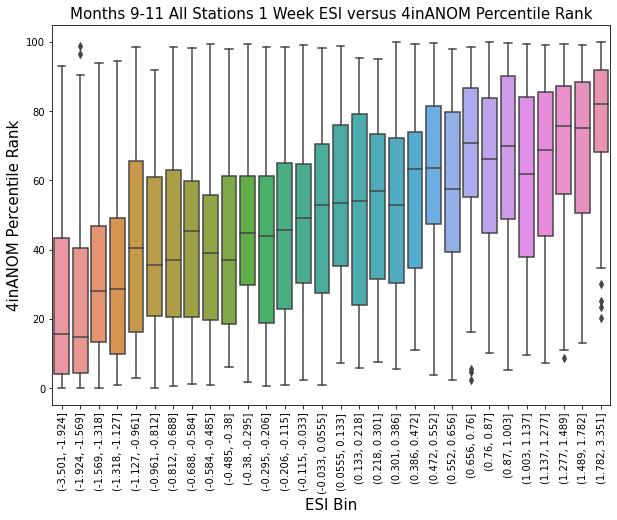

In [81]:
fig, ax=plt.subplots(figsize=(10,7))
g = sns.boxplot(data=good_months, x='ESI_bin', y='4in_pr', ax=ax)
plt.xticks(rotation=90)
ax.set_title('Months 9-11 All Stations 1 Week ESI versus 4inANOM Percentile Rank', fontsize=15)
ax.set_ylabel('4inANOM Percentile Rank', fontsize=15)
ax.set_xlabel('ESI Bin', fontsize=15)

Text(0.5, 0, 'ESI Bin')

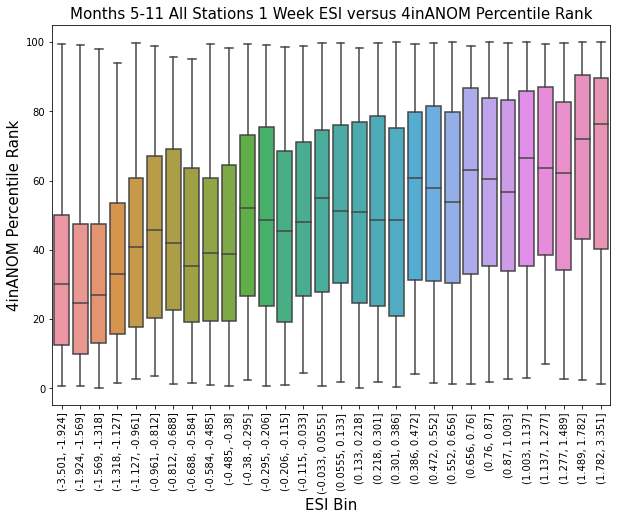

In [82]:
may_oct = df[(df.index.get_level_values('Date').month>=5)&(df.index.get_level_values('Date').month<=10)]
fig, ax=plt.subplots(figsize=(10,7))
g = sns.boxplot(data=may_oct, x='ESI_bin', y='4in_pr', ax=ax)
plt.xticks(rotation=90)
ax.set_title('Months 5-11 All Stations 1 Week ESI versus 4inANOM Percentile Rank', fontsize=15)
ax.set_ylabel('4inANOM Percentile Rank', fontsize=15)
ax.set_xlabel('ESI Bin', fontsize=15)

Text(0.5, 0, 'ESI Bin')

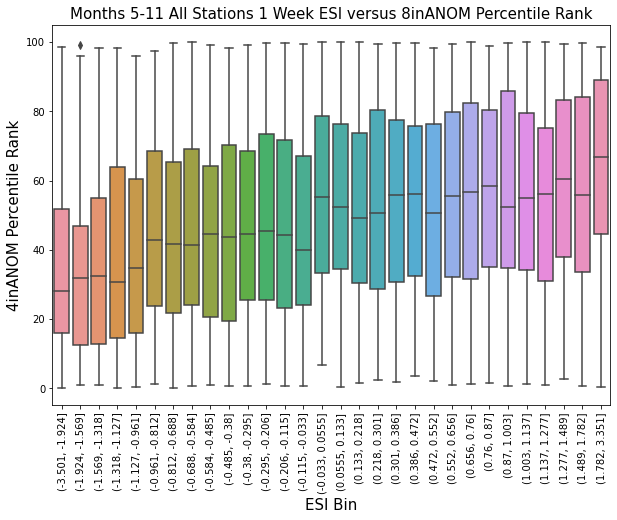

In [83]:
fig, ax=plt.subplots(figsize=(10,7))
g = sns.boxplot(data=may_oct, x='ESI_bin', y='40in_pr', ax=ax)
plt.xticks(rotation=90)
ax.set_title('Months 5-11 All Stations 1 Week ESI versus 8inANOM Percentile Rank', fontsize=15)
ax.set_ylabel('4inANOM Percentile Rank', fontsize=15)
ax.set_xlabel('ESI Bin', fontsize=15)

<AxesSubplot:xlabel='ESI_cumsum', ylabel='4in_pr'>

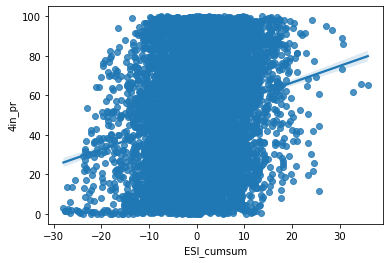

In [84]:
sns.regplot(x='ESI_cumsum', y='4in_pr', data=df)

In [85]:
df['ESI_cumsum_bin'] = pd.qcut(df['ESI_cumsum'],30)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '(-3.501, -1.924]'),
  Text(1, 0, '(-1.924, -1.569]'),
  Text(2, 0, '(-1.569, -1.318]'),
  Text(3, 0, '(-1.318, -1.127]'),
  Text(4, 0, '(-1.127, -0.961]'),
  Text(5, 0, '(-0.961, -0.812]'),
  Text(6, 0, '(-0.812, -0.688]'),
  Text(7, 0, '(-0.688, -0.584]'),
  Text(8, 0, '(-0.584, -0.485]'),
  Text(9, 0, '(-0.485, -0.38]'),
  Text(10, 0, '(-0.38, -0.295]'),
  Text(11, 0, '(-0.295, -0.206]'),
  Text(12, 0, '(-0.206, -0.115]'),
  Text(13, 0, '(-0.115, -0.033]'),
  Text(14, 0, '(-0.033, 0.0555]'),
  Text(15, 0, '(0.0555, 0.133]'),
  Text(16, 0, '(0.133, 0.218]'),
  Text(17, 0, '(0.218, 0.301]'),
  Text(18, 0, '(0.301, 0.386]'),
  Text(19, 0, '(0.386, 0.472]'),
  Text(20, 0, '(0.472, 0.552]'),
  Text(21, 0, '(0.552, 0.656]'),
  Text(22, 0, '(0.656, 0.76]'),
  Text(23, 0, '(0.76, 0.87]'),
  Text(24, 0, '(0.87, 1.003]'),
  Text(25, 0, '(1.003,

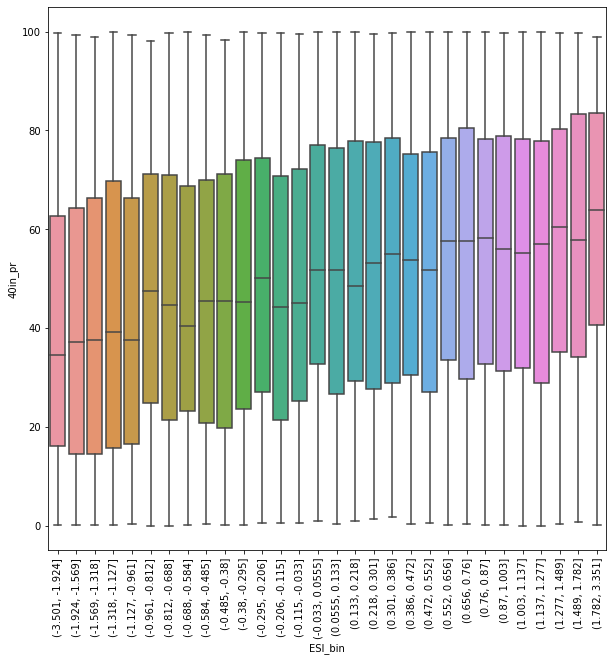

In [86]:
fig, ax=plt.subplots(figsize=(10,10))
g = sns.boxplot(data=df, x='ESI_bin', y='40in_pr', ax=ax)
plt.xticks(rotation=90)

In [87]:
good_months = df[(df.index.month>=9)&(df.index.month<=11)]
good_months['ESI_bin'] = pd.qcut(good_months['ESI'],30)

/tmp/ipykernel_18989/3425253894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_months['ESI_bin'] = pd.qcut(good_months['ESI'],30)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '(-3.477, -1.995]'),
  Text(1, 0, '(-1.995, -1.647]'),
  Text(2, 0, '(-1.647, -1.39]'),
  Text(3, 0, '(-1.39, -1.21]'),
  Text(4, 0, '(-1.21, -1.055]'),
  Text(5, 0, '(-1.055, -0.891]'),
  Text(6, 0, '(-0.891, -0.736]'),
  Text(7, 0, '(-0.736, -0.618]'),
  Text(8, 0, '(-0.618, -0.5]'),
  Text(9, 0, '(-0.5, -0.391]'),
  Text(10, 0, '(-0.391, -0.299]'),
  Text(11, 0, '(-0.299, -0.216]'),
  Text(12, 0, '(-0.216, -0.146]'),
  Text(13, 0, '(-0.146, -0.048]'),
  Text(14, 0, '(-0.048, 0.042]'),
  Text(15, 0, '(0.042, 0.129]'),
  Text(16, 0, '(0.129, 0.209]'),
  Text(17, 0, '(0.209, 0.296]'),
  Text(18, 0, '(0.296, 0.382]'),
  Text(19, 0, '(0.382, 0.468]'),
  Text(20, 0, '(0.468, 0.543]'),
  Text(21, 0, '(0.543, 0.636]'),
  Text(22, 0, '(0.636, 0.743]'),
  Text(23, 0, '(0.743, 0.839]'),
  Text(24, 0, '(0.839, 0.954]'),
  Text(25, 0, '(0.954, 1.1

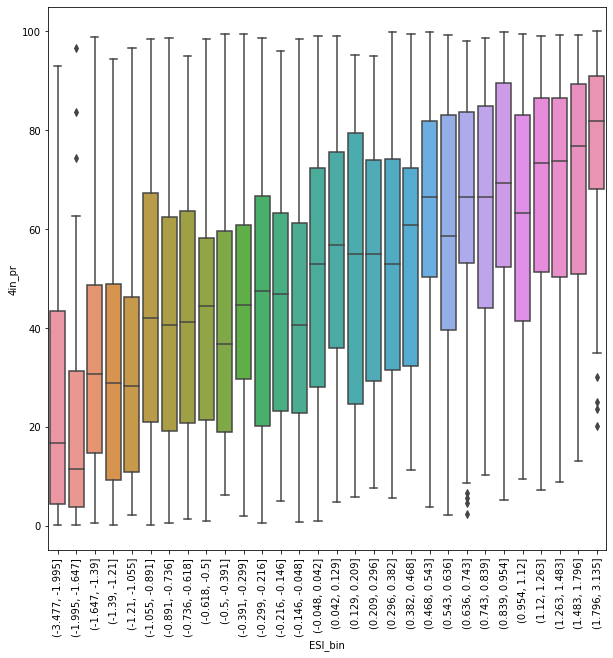

In [88]:
fig, ax=plt.subplots(figsize=(10,10))
g = sns.boxplot(data=good_months, x='ESI_bin', y='4in_pr', ax=ax)
plt.xticks(rotation=90)

In [89]:
summer_months=df[(df.index.month>=6)&(df.index.month<=9)]
summer_months['ESI_bin'] = pd.qcut(summer_months['ESI'],30)

/tmp/ipykernel_18989/1020472137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_months['ESI_bin'] = pd.qcut(summer_months['ESI'],30)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '(-3.501, -1.961]'),
  Text(1, 0, '(-1.961, -1.602]'),
  Text(2, 0, '(-1.602, -1.343]'),
  Text(3, 0, '(-1.343, -1.177]'),
  Text(4, 0, '(-1.177, -0.988]'),
  Text(5, 0, '(-0.988, -0.82]'),
  Text(6, 0, '(-0.82, -0.702]'),
  Text(7, 0, '(-0.702, -0.578]'),
  Text(8, 0, '(-0.578, -0.468]'),
  Text(9, 0, '(-0.468, -0.353]'),
  Text(10, 0, '(-0.353, -0.269]'),
  Text(11, 0, '(-0.269, -0.165]'),
  Text(12, 0, '(-0.165, -0.085]'),
  Text(13, 0, '(-0.085, 0.0078]'),
  Text(14, 0, '(0.0078, 0.088]'),
  Text(15, 0, '(0.088, 0.174]'),
  Text(16, 0, '(0.174, 0.278]'),
  Text(17, 0, '(0.278, 0.353]'),
  Text(18, 0, '(0.353, 0.437]'),
  Text(19, 0, '(0.437, 0.507]'),
  Text(20, 0, '(0.507, 0.607]'),
  Text(21, 0, '(0.607, 0.703]'),
  Text(22, 0, '(0.703, 0.793]'),
  Text(23, 0, '(0.793, 0.904]'),
  Text(24, 0, '(0.904, 1.01]'),
  Text(25, 0, '(1.01,

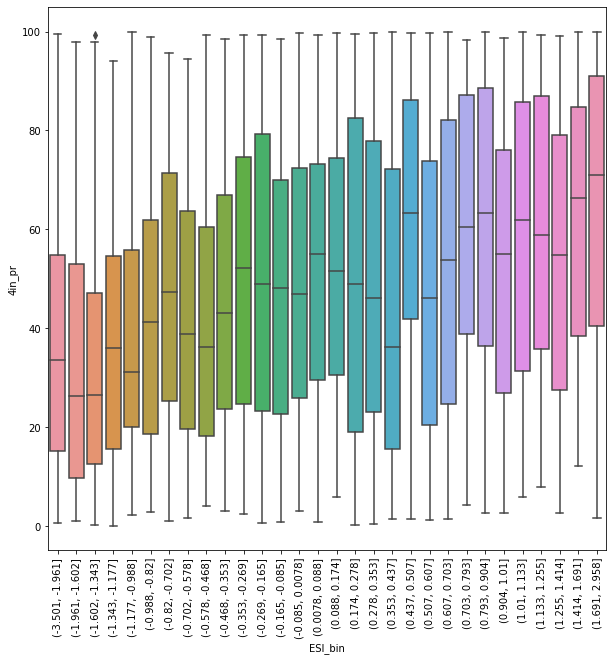

In [90]:
fig, ax=plt.subplots(figsize=(10,10))
g = sns.boxplot(data=summer_months, x='ESI_bin', y='4in_pr', ax=ax)
plt.xticks(rotation=90)

In [91]:
sigs = {}
for s in df['station'].unique():
    #get the stationframe from the main dataset
    stationFrame=df[df['station']==s]
    
    #get the signigigance df at the same station
    sigdf = SCAN_SIG_READ[SCAN_SIG_READ['station']==s]
    
    for m in sigdf['Month'].unique():
        #get the stationFrame where sigFrame == m for station s
        monthStation = stationFrame[stationFrame.index.month==m]
        sigs[s+str(m)]=monthStation
        

In [92]:
newdf = pd.concat(sigs, axis=0)

In [93]:
newdf

ESI       station  week_x  week_y   2inANOM  \
              Date                                                        
2053:AL:SCAN4 2002-04-02 -0.435  2053:AL:SCAN      14      14  0.724556   
              2002-04-09 -0.163  2053:AL:SCAN      15      15  0.318988   
              2002-04-16 -0.484  2053:AL:SCAN      16      16  0.158151   
              2002-04-23 -1.498  2053:AL:SCAN      17      17 -0.756754   
              2002-04-30  0.554  2053:AL:SCAN      18      18 -0.873574   
...                         ...           ...     ...     ...       ...   
2181:AL:SCAN2 2019-02-26  0.198  2181:AL:SCAN       9       9  0.347273   
              2020-02-05  0.198  2181:AL:SCAN       6       6  1.809272   
              2020-02-12 -0.841  2181:AL:SCAN       7       7  1.302807   
              2020-02-19 -0.469  2181:AL:SCAN       8       8  1.087912   
              2020-02-26  1.661  2181:AL:SCAN       9       9  1.041819   

                           4inANOM   8inANOM  20inANOM  40inANOM     2in_pr  \
              Date                                                            
2053:AL:SCAN4 2002-04-02  0.095368  0.720884 -0.133735 -0.241910  74.723953   
              2002-04-09 -0.067437  0.484996 -0.619942  0.189875  58.740571   
              2002-04-16  0.072646  0.665487 -0.431747  0.349802  53.350825   
              2002-04-23 -0.837206  0.346158 -0.322725  0.079589  23.330054   
              2002-04-30 -1.832470  0.071150 -0.237434  0.021554  20.225210   
...                            ...       ...       ...       ...        ...   
2181:AL:SCAN2 2019-02-26       NaN  0.006028 -1.179529 -0.079067  59.954083   
              2020-02-05       NaN  1.576041  1.187023  1.614214  98.381983   
              2020-02-12       NaN  1.016485  1.558269  1.662730  93.025036   
              2020-02-19       NaN  1.355394  0.411302  0.946471  87.810211   
              2020-02-26       NaN  1.392552  0.183447  1.208351  86.432710   

                          ...                       point  Category  \
              Date        ...                                         
2053:AL:SCAN4 2002-04-02  ...      POINT (-86.53333 34.9)       NaN   
              2002-04-09  ...      POINT (-86.53333 34.9)       NaN   
              2002-04-16  ...      POINT (-86.53333 34.9)       NaN   
              2002-04-23  ...      POINT (-86.53333 34.9)       0.0   
              2002-04-30  ...      POINT (-86.53333 34.9)       0.0   
...                       ...                         ...       ...   
2181:AL:SCAN2 2019-02-26  ...  POINT (-87.55277 31.10923)       NaN   
              2020-02-05  ...  POINT (-87.55277 31.10923)       0.0   
              2020-02-12  ...  POINT (-87.55277 31.10923)       NaN   
              2020-02-19  ...  POINT (-87.55277 31.10923)       NaN   
              2020-02-26  ...  POINT (-87.55277 31.10923)       NaN   

                               Station Name  ESI_cumsum      ESI_pc  \
              Date                                                    
2053:AL:SCAN4 2002-04-02              Wtars      -6.540 -130.938834   
              2002-04-09              Wtars      -6.703  -62.528736   
              2002-04-16              Wtars      -7.187  196.932515   
              2002-04-23              Wtars      -8.685  209.504132   
              2002-04-30              Wtars      -8.131 -136.982644   
...                                     ...         ...         ...   
2181:AL:SCAN2 2019-02-26  Perdido Riv Farms       0.523 -110.448549   
              2020-02-05  Perdido Riv Farms      -0.712  -76.230492   
              2020-02-12  Perdido Riv Farms      -1.553 -524.747475   
              2020-02-19  Perdido Riv Farms      -2.022  -44.233056   
              2020-02-26  Perdido Riv Farms      -0.361 -454.157783   

                          ESI_cumsum_pc  4inANOM_cumsum      4inpc  \
              Date                                                   
2053:AL:SCAN4 2002-04-02       7.125

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '(-3.501, -1.924]'),
  Text(1, 0, '(-1.924, -1.569]'),
  Text(2, 0, '(-1.569, -1.318]'),
  Text(3, 0, '(-1.318, -1.127]'),
  Text(4, 0, '(-1.127, -0.961]'),
  Text(5, 0, '(-0.961, -0.812]'),
  Text(6, 0, '(-0.812, -0.688]'),
  Text(7, 0, '(-0.688, -0.584]'),
  Text(8, 0, '(-0.584, -0.485]'),
  Text(9, 0, '(-0.485, -0.38]'),
  Text(10, 0, '(-0.38, -0.295]'),
  Text(11, 0, '(-0.295, -0.206]'),
  Text(12, 0, '(-0.206, -0.115]'),
  Text(13, 0, '(-0.115, -0.033]'),
  Text(14, 0, '(-0.033, 0.0555]'),
  Text(15, 0, '(0.0555, 0.133]'),
  Text(16, 0, '(0.133, 0.218]'),
  Text(17, 0, '(0.218, 0.301]'),
  Text(18, 0, '(0.301, 0.386]'),
  Text(19, 0, '(0.386, 0.472]'),
  Text(20, 0, '(0.472, 0.552]'),
  Text(21, 0, '(0.552, 0.656]'),
  Text(22, 0, '(0.656, 0.76]'),
  Text(23, 0, '(0.76, 0.87]'),
  Text(24, 0, '(0.87, 1.003]'),
  Text(25, 0, '(1.003,

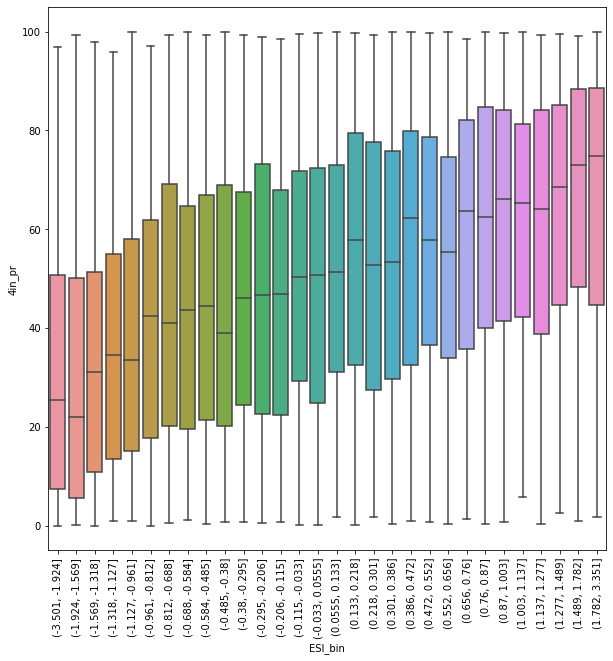

In [94]:
fig, ax=plt.subplots(figsize=(10,10))
g = sns.boxplot(data=newdf,x='ESI_bin', y='4in_pr', ax=ax)
plt.xticks(rotation=90)

In [95]:
import scipy as sp

In [96]:
newdf.dropna(subset=['4in_pr'], inplace=True)

In [97]:
newdf

ESI       station  week_x  week_y   2inANOM  \
              Date                                                        
2053:AL:SCAN4 2002-04-02 -0.435  2053:AL:SCAN      14      14  0.724556   
              2002-04-09 -0.163  2053:AL:SCAN      15      15  0.318988   
              2002-04-16 -0.484  2053:AL:SCAN      16      16  0.158151   
              2002-04-23 -1.498  2053:AL:SCAN      17      17 -0.756754   
              2002-04-30  0.554  2053:AL:SCAN      18      18 -0.873574   
...                         ...           ...     ...     ...       ...   
2181:AL:SCAN2 2017-02-19 -1.245  2181:AL:SCAN       7       7 -1.391765   
              2017-02-26 -1.290  2181:AL:SCAN       8       8 -0.508383   
              2018-02-05 -0.247  2181:AL:SCAN       6       6 -0.398190   
              2018-02-12  1.660  2181:AL:SCAN       7       7  0.849407   
              2018-02-19  2.106  2181:AL:SCAN       8       8  0.049001   

                           4inANOM   8inANOM  20inANOM  40inANOM     2in_pr  \
              Date                                                            
2053:AL:SCAN4 2002-04-02  0.095368  0.720884 -0.133735 -0.241910  74.723953   
              2002-04-09 -0.067437  0.484996 -0.619942  0.189875  58.740571   
              2002-04-16  0.072646  0.665487 -0.431747  0.349802  53.350825   
              2002-04-23 -0.837206  0.346158 -0.322725  0.079589  23.330054   
              2002-04-30 -1.832470  0.071150 -0.237434  0.021554  20.225210   
...                            ...       ...       ...       ...        ...   
2181:AL:SCAN2 2017-02-19 -0.880697 -1.029576 -0.904181 -0.816375   7.794905   
              2017-02-26  0.620348 -1.312816  0.141193 -0.208365  31.365475   
              2018-02-05 -0.190989  0.416556       NaN       NaN  34.688969   
              2018-02-12  1.438034  0.679838       NaN       NaN  79.588936   
              2018-02-19  0.726985  0.219985       NaN       NaN  49.404176   

                          ...                       point  Category  \
              Date        ...                                         
2053:AL:SCAN4 2002-04-02  ...      POINT (-86.53333 34.9)       NaN   
              2002-04-09  ...      POINT (-86.53333 34.9)       NaN   
              2002-04-16  ...      POINT (-86.53333 34.9)       NaN   
              2002-04-23  ...      POINT (-86.53333 34.9)       0.0   
              2002-04-30  ...      POINT (-86.53333 34.9)       0.0   
...                       ...                         ...       ...   
2181:AL:SCAN2 2017-02-19  ...  POINT (-87.55277 31.10923)       NaN   
              2017-02-26  ...  POINT (-87.55277 31.10923)       NaN   
              2018-02-05  ...  POINT (-87.55277 31.10923)       2.0   
              2018-02-12  ...  POINT (-87.55277 31.10923)       2.0   
              2018-02-19  ...  POINT (-87.55277 31.10923)       1.0   

                               Station Name  ESI_cumsum      ESI_pc  \
              Date                                                    
2053:AL:SCAN4 2002-04-02              Wtars      -6.540 -130.938834   
              2002-04-09              Wtars      -6.703  -62.528736   
              2002-04-16              Wtars      -7.187  196.932515   
              2002-04-23              Wtars      -8.685  209.504132   
              2002-04-30              Wtars      -8.131 -136.982644   
...                                     ...         ...         ...   
2181:AL:SCAN2 2017-02-19  Perdido Riv Farms      -5.776  -17.275748   
              2017-02-26  Perdido Riv Farms      -7.066    3.614458   
              2018-02-05  Perdido Riv Farms       3.484  -52.408478   
              2018-02-12  Perdido Riv Farms       5.144 -772.064777   
              2018-02-19  Perdido Riv Farms       7.250   26.867470   

                          ESI_cumsum_pc  4inANOM_cumsum       4inpc  \
              Date                                                    
2053:AL:SCAN4 2002-04-02       7.1

In [98]:
def annotate(**kws):
    r, p = sp.stats.pearsonr(newdf['ESI'], newdf['4in_pr'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

Text(0.5, 1.0, 'ESI vs 4in_pr')

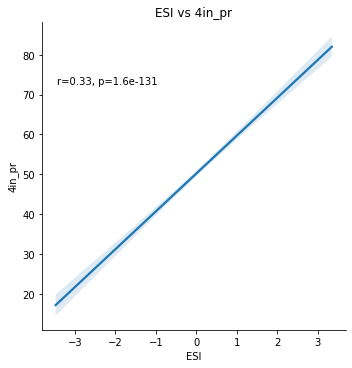

In [99]:
g = sns.lmplot(x='ESI', y='4in_pr', data=newdf, scatter=False)
g.map_dataframe(annotate)
ax = plt.gca()
ax.set_title('ESI vs 4in_pr')

In [100]:
soils = SOILS_READ[SOILS_READ['depth']=='HSMS-4.0in'].transpose()

In [101]:
soils.reset_index(inplace=True)

In [102]:
soils=soils.drop(0)

In [103]:
soils

index  6
1   2057:AL:SCAN  D
2   2078:AL:SCAN  B
3   2177:AL:SCAN  D
4   2113:AL:SCAN  A
5   2174:AL:SCAN  D
6   2055:AL:SCAN  B
7   2173:AL:SCAN  B
8   2180:AL:SCAN  A
9   2114:AL:SCAN  D
10  2178:AL:SCAN  A
11  2181:AL:SCAN  A
12  2182:AL:SCAN  A
13  2176:AL:SCAN  A
14  2056:AL:SCAN  B
15  2179:AL:SCAN  A
16  2115:AL:SCAN  A
17  2175:AL:SCAN  B
18  2053:AL:SCAN  B

In [104]:
soils=soils.rename(columns={'index':'station', 6:'4insoils'})

In [105]:
newdf.reset_index(inplace=True)

In [106]:
final = newdf.merge(soils, on=['station'])

In [107]:
final['ESI_bin'] = pd.qcut(final['ESI'], 12)

In [108]:
final

level_0       Date    ESI       station  week_x  week_y   2inANOM  \
0     2053:AL:SCAN4 2002-04-02 -0.435  2053:AL:SCAN      14      14  0.724556   
1     2053:AL:SCAN4 2002-04-09 -0.163  2053:AL:SCAN      15      15  0.318988   
2     2053:AL:SCAN4 2002-04-16 -0.484  2053:AL:SCAN      16      16  0.158151   
3     2053:AL:SCAN4 2002-04-23 -1.498  2053:AL:SCAN      17      17 -0.756754   
4     2053:AL:SCAN4 2002-04-30  0.554  2053:AL:SCAN      18      18 -0.873574   
...             ...        ...    ...           ...     ...     ...       ...   
5059  2181:AL:SCAN2 2017-02-19 -1.245  2181:AL:SCAN       7       7 -1.391765   
5060  2181:AL:SCAN2 2017-02-26 -1.290  2181:AL:SCAN       8       8 -0.508383   
5061  2181:AL:SCAN2 2018-02-05 -0.247  2181:AL:SCAN       6       6 -0.398190   
5062  2181:AL:SCAN2 2018-02-12  1.660  2181:AL:SCAN       7       7  0.849407   
5063  2181:AL:SCAN2 2018-02-19  2.106  2181:AL:SCAN       8       8  0.049001   

       4inANOM   8inANOM  20inANOM  ...  Category       Station Name  \
0     0.095368  0.720884 -0.133735  ...       NaN              Wtars   
1    -0.067437  0.484996 -0.619942  ...       NaN              Wtars   
2     0.072646  0.665487 -0.431747  ...       NaN              Wtars   
3    -0.837206  0.346158 -0.322725  ...       0.0              Wtars   
4    -1.832470  0.071150 -0.237434  ...       0.0              Wtars   
...        ...       ...       ...  ...       ...                ...   
5059 -0.880697 -1.029576 -0.904181  ...       NaN  Perdido Riv Farms   
5060  0.620348 -1.312816  0.141193  ...       NaN  Perdido Riv Farms   
5061 -0.190989  0.416556       NaN  ...       2.0  Perdido Riv Farms   
5062  1.438034  0.679838       NaN  ...       2.0  Perdido Riv Farms   
5063  0.726985  0.219985       NaN  ...       1.0  Perdido Riv Farms   

      ESI_cumsum      ESI_pc  ESI_cumsum_pc  4inANOM_cumsum       4inpc  \
0         -6.540 -130.938834       7.125307     -531.640691   -7.723911   
1         -6.703  -62.528736       2.492355     -538.384394  -10.863758   
2         -7.187  196.932515       7.220647     -531.119776   10.439560   
3         -8.685  209.504132      20.843189     -614.840350  -59.113523   
4         -8.131 -136.982644      -6.378814     -798.087335  -85.896018   
...          ...         ...            ...             ...         ...   
5059      -5.776  -17.275748      27.477378      821.743634  -79.950553   
5060      -7.066    3.614458      22.333795      883.778425  262.125661   
5061       3.484  -52.408478      -6.620209     -234.802365  -23.364289   
5062       5.144 -772.064777      47.646383      -90.998993  129.413385   
5063       7.250   26.867470      40.940902      -18.300523  -21.152461   

               ESI_bin    ESI_cumsum_bin  4insoils  
0     (-0.642, -0.385]  (-6.641, -5.548]         B  
1      (-0.168, 0.028]   (-8.08, -6.641]         B  
2     (-0.642, -0.385]   (-8.08, -6.641]         B  
3      (-3.477, -1.46]   (-9.831, -8.08]         B  
4        (0.447, 0.68]   (-9.831, -8.08]         B  
...                ...               ...       ...  
5059   (-1.46, -0.991]  (-6.641, -5.548]         A  
5060   (-1.46, -0.991]   (-8.08, -6.641]         A  
5061  (-0.385, -0.168]    (3.115, 3.731]         A  
5062    (1.378, 3.351]     (4.43, 5.191]         A  
5063    (1.378, 3.351]    (7.025, 8.149]         A  

[5064 rows x 32 columns]

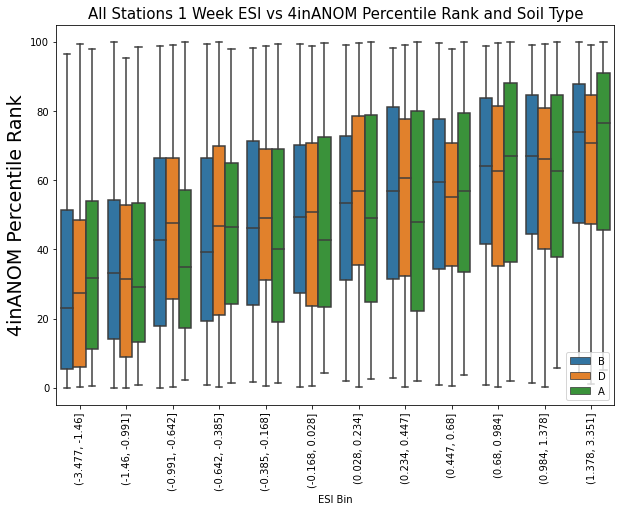

In [109]:
fig, ax = plt.subplots(figsize=(10,7))
g = sns.boxplot(x='ESI_bin', y='4in_pr', data=final, hue='4insoils', ax=ax)
ax = plt.gca()
ax.set_title('All Stations 1 Week ESI vs 4inANOM Percentile Rank and Soil Type', fontsize=15)
ax.set_ylabel('4inANOM Percentile Rank', fontsize=19)
ax.set_xlabel('ESI Bin')
plt.xticks(rotation=90)
ax.legend(loc='lower right')

In [110]:
final.set_index('Date', inplace=True)

In [111]:
goodmonths = final[(final.index.month>=5)&(final.index.month<=11)]

Text(0, 0.5, '4inANOM Percentile Rank')

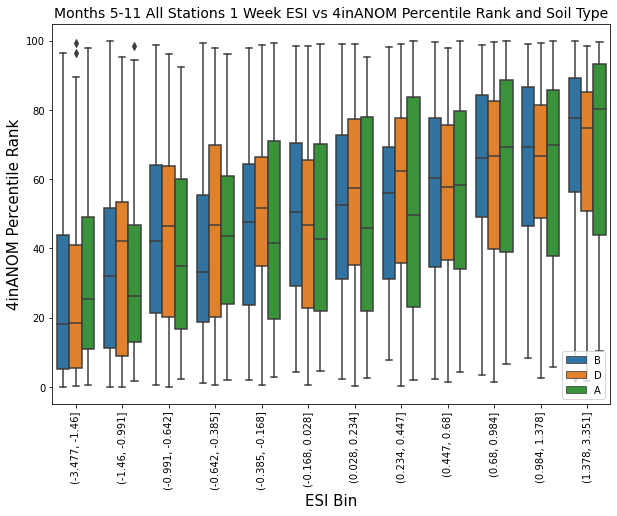

In [112]:
fig, ax = plt.subplots(figsize=(10, 7))
g = sns.boxplot(x='ESI_bin', y='4in_pr', data=goodmonths, hue='4insoils')
ax = plt.gca()
ax.set_title('Months 5-11 All Stations 1 Week ESI vs 4inANOM Percentile Rank and Soil Type', fontsize=14)
plt.xticks(rotation=90)
ax.legend(loc='lower right')
ax.set_xlabel('ESI Bin', fontsize=15)
ax.set_ylabel('4inANOM Percentile Rank', fontsize=15)

In [113]:
final

level_0    ESI       station  week_x  week_y   2inANOM  \
Date                                                                       
2002-04-02  2053:AL:SCAN4 -0.435  2053:AL:SCAN      14      14  0.724556   
2002-04-09  2053:AL:SCAN4 -0.163  2053:AL:SCAN      15      15  0.318988   
2002-04-16  2053:AL:SCAN4 -0.484  2053:AL:SCAN      16      16  0.158151   
2002-04-23  2053:AL:SCAN4 -1.498  2053:AL:SCAN      17      17 -0.756754   
2002-04-30  2053:AL:SCAN4  0.554  2053:AL:SCAN      18      18 -0.873574   
...                   ...    ...           ...     ...     ...       ...   
2017-02-19  2181:AL:SCAN2 -1.245  2181:AL:SCAN       7       7 -1.391765   
2017-02-26  2181:AL:SCAN2 -1.290  2181:AL:SCAN       8       8 -0.508383   
2018-02-05  2181:AL:SCAN2 -0.247  2181:AL:SCAN       6       6 -0.398190   
2018-02-12  2181:AL:SCAN2  1.660  2181:AL:SCAN       7       7  0.849407   
2018-02-19  2181:AL:SCAN2  2.106  2181:AL:SCAN       8       8  0.049001   

             4inANOM   8inANOM  20inANOM  40inANOM  ...  Category  \
Date                                                ...             
2002-04-02  0.095368  0.720884 -0.133735 -0.241910  ...       NaN   
2002-04-09 -0.067437  0.484996 -0.619942  0.189875  ...       NaN   
2002-04-16  0.072646  0.665487 -0.431747  0.349802  ...       NaN   
2002-04-23 -0.837206  0.346158 -0.322725  0.079589  ...       0.0   
2002-04-30 -1.832470  0.071150 -0.237434  0.021554  ...       0.0   
...              ...       ...       ...       ...  ...       ...   
2017-02-19 -0.880697 -1.029576 -0.904181 -0.816375  ...       NaN   
2017-02-26  0.620348 -1.312816  0.141193 -0.208365  ...       NaN   
2018-02-05 -0.190989  0.416556       NaN       NaN  ...       2.0   
2018-02-12  1.438034  0.679838       NaN       NaN  ...       2.0   
2018-02-19  0.726985  0.219985       NaN       NaN  ...       1.0   

                 Station Name  ESI_cumsum      ESI_pc  ESI_cumsum_pc  \
Date                                                                   
2002-04-02              Wtars      -6.540 -130.938834       7.125307   
2002-04-09              Wtars      -6.703  -62.528736       2.492355   
2002-04-16              Wtars      -7.187  196.932515       7.220647   
2002-04-23              Wtars      -8.685  209.504132      20.843189   
2002-04-30              Wtars      -8.131 -136.982644      -6.378814   
...                       ...         ...         ...            ...   
2017-02-19  Perdido Riv Farms      -5.776  -17.275748      27.477378   
2017-02-26  Perdido Riv Farms      -7.066    3.614458      22.333795   
2018-02-05  Perdido Riv Farms       3.484  -52.408478      -6.620209   
2018-02-12  Perdido Riv Farms       5.144 -772.064777      47.646383   
2018-02-19  Perdido Riv Farms       7.250   26.867470      40.940902   

            4inANOM_cumsum       4inpc           ESI_bin    ESI_cumsum_bin  \
Date                                                                         
2002-04-02     -531.640691   -7.723911  (-0.642, -0.385]  (-6.641, -5.548]   
2002-04-09     -538.384394  -10.863758   (-0.168, 0.028]   (-8.08, -6.641]   
2002-04-16     -531.119776   10.439560  (-0.642, -0.385]   (-8.08, -6.641]   
2002-04-23     -614.840350  -59.113523   (-3.477, -1.46]   (-9.831, -8.08]   
2002-04-30     -798.087335  -85.896018     (0.447, 0.68]   (-9.831, -8.08]   
...                    ...         ...               ...               ...   
2017-02-19      821.743634  -79.950553   (-1.46, -0.991]  (-6.641, -5.548]   
2017-02-26      883.778425  262.125661   (-1.46, -0.991]   (-8.08, -6.641]   
2018-02-05     -234.802365  -23.364289  (-0.385, -0.168]    (3.115, 3.731]   
2018-02-12      -90.998993  129.413385    (1.378, 3.351]     (4.43, 5.191]   
2018-02-19      -18.300523  -21.152461    (1.378, 3.351]    (7.025, 8.149]   

            4insoils  
Date                  
2002-04-02         B  
2002-04-09         B  
2002-04-16         B  
2002-04-23         B  
2002-04-30         B  
...              .

In [114]:
categories = final[['ESI_bin', '2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC','40inSMSDC', 'Category', 'station', '4insoils']]

In [115]:
categories

ESI_bin  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  \
Date                                                                    
2002-04-02  (-0.642, -0.385]       NaN       NaN       NaN        NaN   
2002-04-09   (-0.168, 0.028]       NaN       NaN       NaN        0.0   
2002-04-16  (-0.642, -0.385]       NaN       NaN       NaN        NaN   
2002-04-23   (-3.477, -1.46]       0.0       NaN       NaN        NaN   
2002-04-30     (0.447, 0.68]       NaN       4.0       NaN        NaN   
...                      ...       ...       ...       ...        ...   
2017-02-19   (-1.46, -0.991]       2.0       1.0       1.0        1.0   
2017-02-26   (-1.46, -0.991]       NaN       NaN       2.0        NaN   
2018-02-05  (-0.385, -0.168]       NaN       NaN       NaN        NaN   
2018-02-12    (1.378, 3.351]       NaN       NaN       NaN        NaN   
2018-02-19    (1.378, 3.351]       NaN       NaN       NaN        NaN   

            40inSMSDC  Category       station 4insoils  
Date                                                    
2002-04-02        NaN       NaN  2053:AL:SCAN        B  
2002-04-09        NaN       NaN  2053:AL:SCAN        B  
2002-04-16        NaN       NaN  2053:AL:SCAN        B  
2002-04-23        NaN       0.0  2053:AL:SCAN        B  
2002-04-30        NaN       0.0  2053:AL:SCAN        B  
...               ...       ...           ...      ...  
2017-02-19        0.0       NaN  2181:AL:SCAN        A  
2017-02-26        NaN       NaN  2181:AL:SCAN        A  
2018-02-05        NaN       2.0  2181:AL:SCAN        A  
2018-02-12        NaN       2.0  2181:AL:SCAN        A  
2018-02-19        NaN       1.0  2181:AL:SCAN        A  

[5064 rows x 9 columns]

In [116]:
categories[(categories.index.year==2019)&(categories['station']=='2057:AL:SCAN')]

ESI_bin  2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  \
Date                                                                    
2019-04-02  (-0.642, -0.385]       2.0       NaN       NaN        NaN   
2019-04-09     (0.68, 0.984]       NaN       NaN       NaN        NaN   
2019-04-16     (0.447, 0.68]       NaN       NaN       NaN        NaN   
2019-04-23     (0.447, 0.68]       NaN       NaN       NaN        NaN   
2019-04-30  (-0.642, -0.385]       0.0       NaN       NaN        NaN   
2019-06-04   (-1.46, -0.991]       1.0       NaN       NaN        NaN   
2019-06-18    (0.028, 0.234]       0.0       NaN       NaN        NaN   
2019-07-02     (0.447, 0.68]       0.0       NaN       NaN        NaN   
2019-07-09  (-0.385, -0.168]       1.0       NaN       NaN        NaN   
2019-07-16    (0.234, 0.447]       NaN       NaN       NaN        NaN   
2019-07-23    (1.378, 3.351]       NaN       NaN       NaN        NaN   
2019-07-30  (-0.991, -0.642]       0.0       NaN       NaN        NaN   
2019-08-06     (0.447, 0.68]       NaN       NaN       NaN        NaN   
2019-08-13    (0.028, 0.234]       NaN       NaN       NaN        NaN   
2019-08-20  (-0.385, -0.168]       1.0       NaN       NaN        NaN   
2019-08-27  (-0.991, -0.642]       0.0       NaN       NaN        NaN   
2019-09-03   (-1.46, -0.991]       NaN       NaN       NaN        NaN   
2019-09-10   (-3.477, -1.46]       1.0       NaN       NaN        NaN   
2019-09-17   (-1.46, -0.991]       NaN       NaN       NaN        NaN   
2019-09-24   (-1.46, -0.991]       2.0       NaN       NaN        NaN   
2019-10-01  (-0.642, -0.385]       NaN       NaN       NaN        NaN   
2019-10-08   (-1.46, -0.991]       0.0       NaN       NaN        NaN   
2019-10-15    (0.234, 0.447]       NaN       NaN       NaN        NaN   
2019-10-22    (0.234, 0.447]       1.0       NaN       NaN        NaN   
2019-10-29  (-0.642, -0.385]       NaN       NaN       NaN        NaN   
2019-11-05    (1.378, 3.351]       NaN       NaN       NaN        NaN   
2019-11-12     (0.68, 0.984]       NaN       NaN       NaN        NaN   
2019-11-19    (0.234, 0.447]       NaN       NaN       NaN        NaN   
2019-11-26     (0.447, 0.68]       NaN       NaN       NaN        NaN   
2019-12-03  (-0.385, -0.168]       NaN       NaN       NaN        NaN   
2019-12-10    (0.028, 0.234]       3.0       NaN       NaN        NaN   
2019-12-17     (0.447, 0.68]       NaN       NaN       NaN        NaN   
2019-12-24    (0.984, 1.378]       NaN       NaN       NaN        NaN   
2019-12-31  (-0.642, -0.385]       NaN       NaN       NaN        NaN   
2019-01-08    (0.234, 0.447]       1.0       NaN       NaN        NaN   
2019-01-15   (-3.477, -1.46]       4.0       NaN       NaN        NaN   
2019-01-22   (-1.46, -0.991]       1.0       NaN       NaN        NaN   
2019-01-29  (-0.991, -0.642]       NaN       NaN       NaN        NaN   

            40inSMSDC  Category       station 4insoils  
Date                                                    
2019-04-02        NaN       NaN  2057:AL:SCAN        D  
2019-04-09        NaN       NaN  2057:AL:SCAN        D  
2019-04-16        NaN       NaN  2057:AL:SCAN        D  
2019-04-23        NaN       NaN  2057:AL:SCAN        D  
2019-04-30        NaN       NaN  2057:AL:SCAN        D  
2019-06-04        NaN       0.0  2057:AL:SCAN        D  
2019-06-18        NaN       0.0  2057:AL:SCAN        D  
2019-07-02        NaN       0.0  2057:AL:SCAN        D  
2019-07-09        NaN       0.0  2057:AL:SCAN        D  
2019-07-16        NaN       0.0  2057:AL:SCAN        D  
2019-07-23        NaN       NaN  2057:AL:SCAN        D  
2019-07-30        NaN       NaN  2057:AL:SCAN        D  
2019-08-06        NaN       NaN  2057:AL:SCAN        D  
2019-08-13        NaN       NaN  2057:AL:SCAN        D  
2019-08-20        NaN       NaN  2057:AL:SCAN        D  
2019-08-27        NaN       NaN  2057:AL:SCAN        D  
2019-09-03        NaN       NaN  2057:AL:SCAN        D  
2019-09-10       

In [117]:
combined.columns

Index(['ESI', 'station', 'week_x', 'week_y', '2inANOM', '4inANOM', '8inANOM',
       '20inANOM', '40inANOM', '2in_pr', '4in_pr', '8in_pr', '20in_pr',
       '40in_pr', '2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC', '40inSMSDC',
       'point', 'Category', 'Station Name'],
      dtype='object')

In [118]:
test = combined[(combined['station']=='2078:AL:SCAN')&(combined.index.month>=5)&(combined.index.month<=11)]

/tmp/ipykernel_18989/602000393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['ESI_cumsum'] = yearFrame['ESI'].cumsum()
/tmp/ipykernel_18989/602000393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['4inANOM_cumsum'] = yearFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/602000393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

/tmp/ipykernel_18989/602000393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['ESI_cumsum'] = yearFrame['ESI'].cumsum()
/tmp/ipykernel_18989/602000393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['4inANOM_cumsum'] = yearFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/602000393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

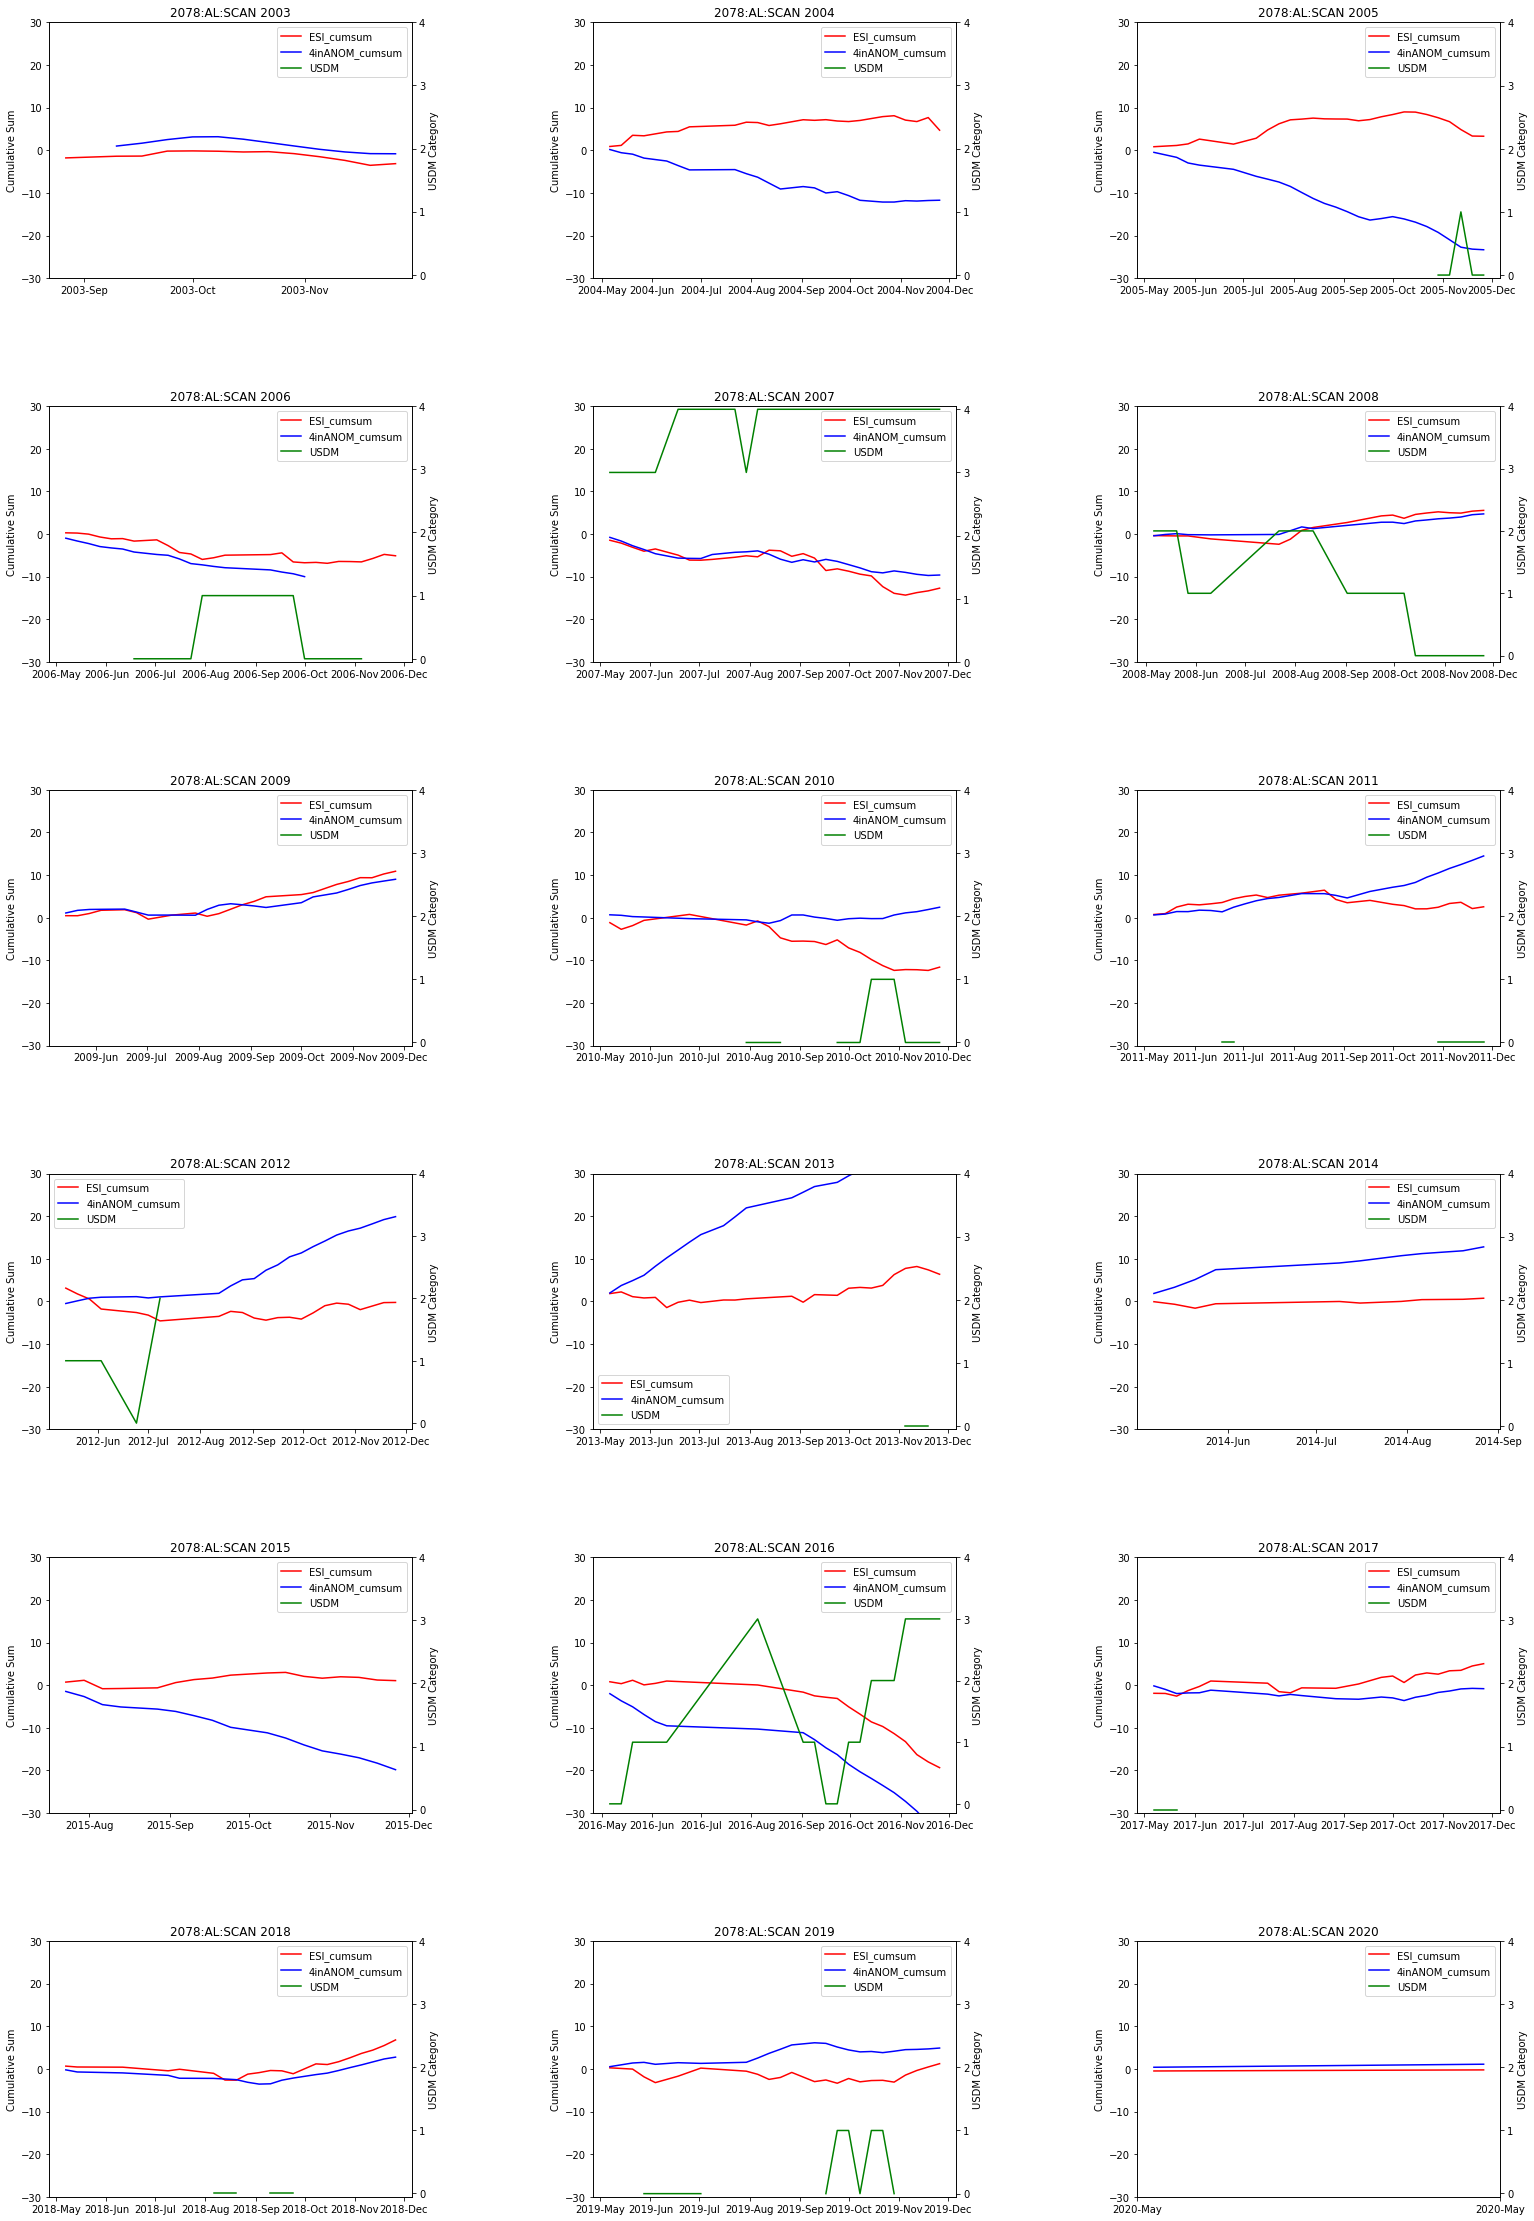

In [119]:
fig, ax = plt.subplots(figsize=(26,40), nrows=6, ncols=3)
axes = ax.flatten()
count=0
for y in test.index.year.unique():
    yearFrame = test[test.index.year==y]
    yearFrame['ESI_cumsum'] = yearFrame['ESI'].cumsum()
    yearFrame['4inANOM_cumsum'] = yearFrame['4inANOM'].cumsum()
    ESI_h, = axes[count].plot(yearFrame['ESI_cumsum'], label='ESI_cumsum', color='red')
    axes[count].set_ylabel('Cumulative Sum')
    axes[count].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[count].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ANOM4in_h, = axes[count].plot(yearFrame['4inANOM_cumsum'], label='4inANOM_cumsum', color='blue')
    axes[count].set_ylim(-30,30)
    
    axes2 = axes[count].twinx()
    USDM_h, = axes2.plot(yearFrame['Category'], label='USDM', color='green')
    
    axes2.set_yticks([0,1,2,3,4])
    axes2.set_ylabel('USDM Category')
    
    axes[count].set_title('2078:AL:SCAN ' + str(y))
    axes[count].legend(handles=[ESI_h, ANOM4in_h, USDM_h])
    count+=1
plt.subplots_adjust(hspace=0.5, wspace=0.5)

/tmp/ipykernel_18989/2943343103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['ESI_cumsum'] = yearFrame['ESI'].cumsum()
/tmp/ipykernel_18989/2943343103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['ESI_cumsum'] = yearFrame['ESI'].cumsum()
/tmp/ipykernel_18989/2943343103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

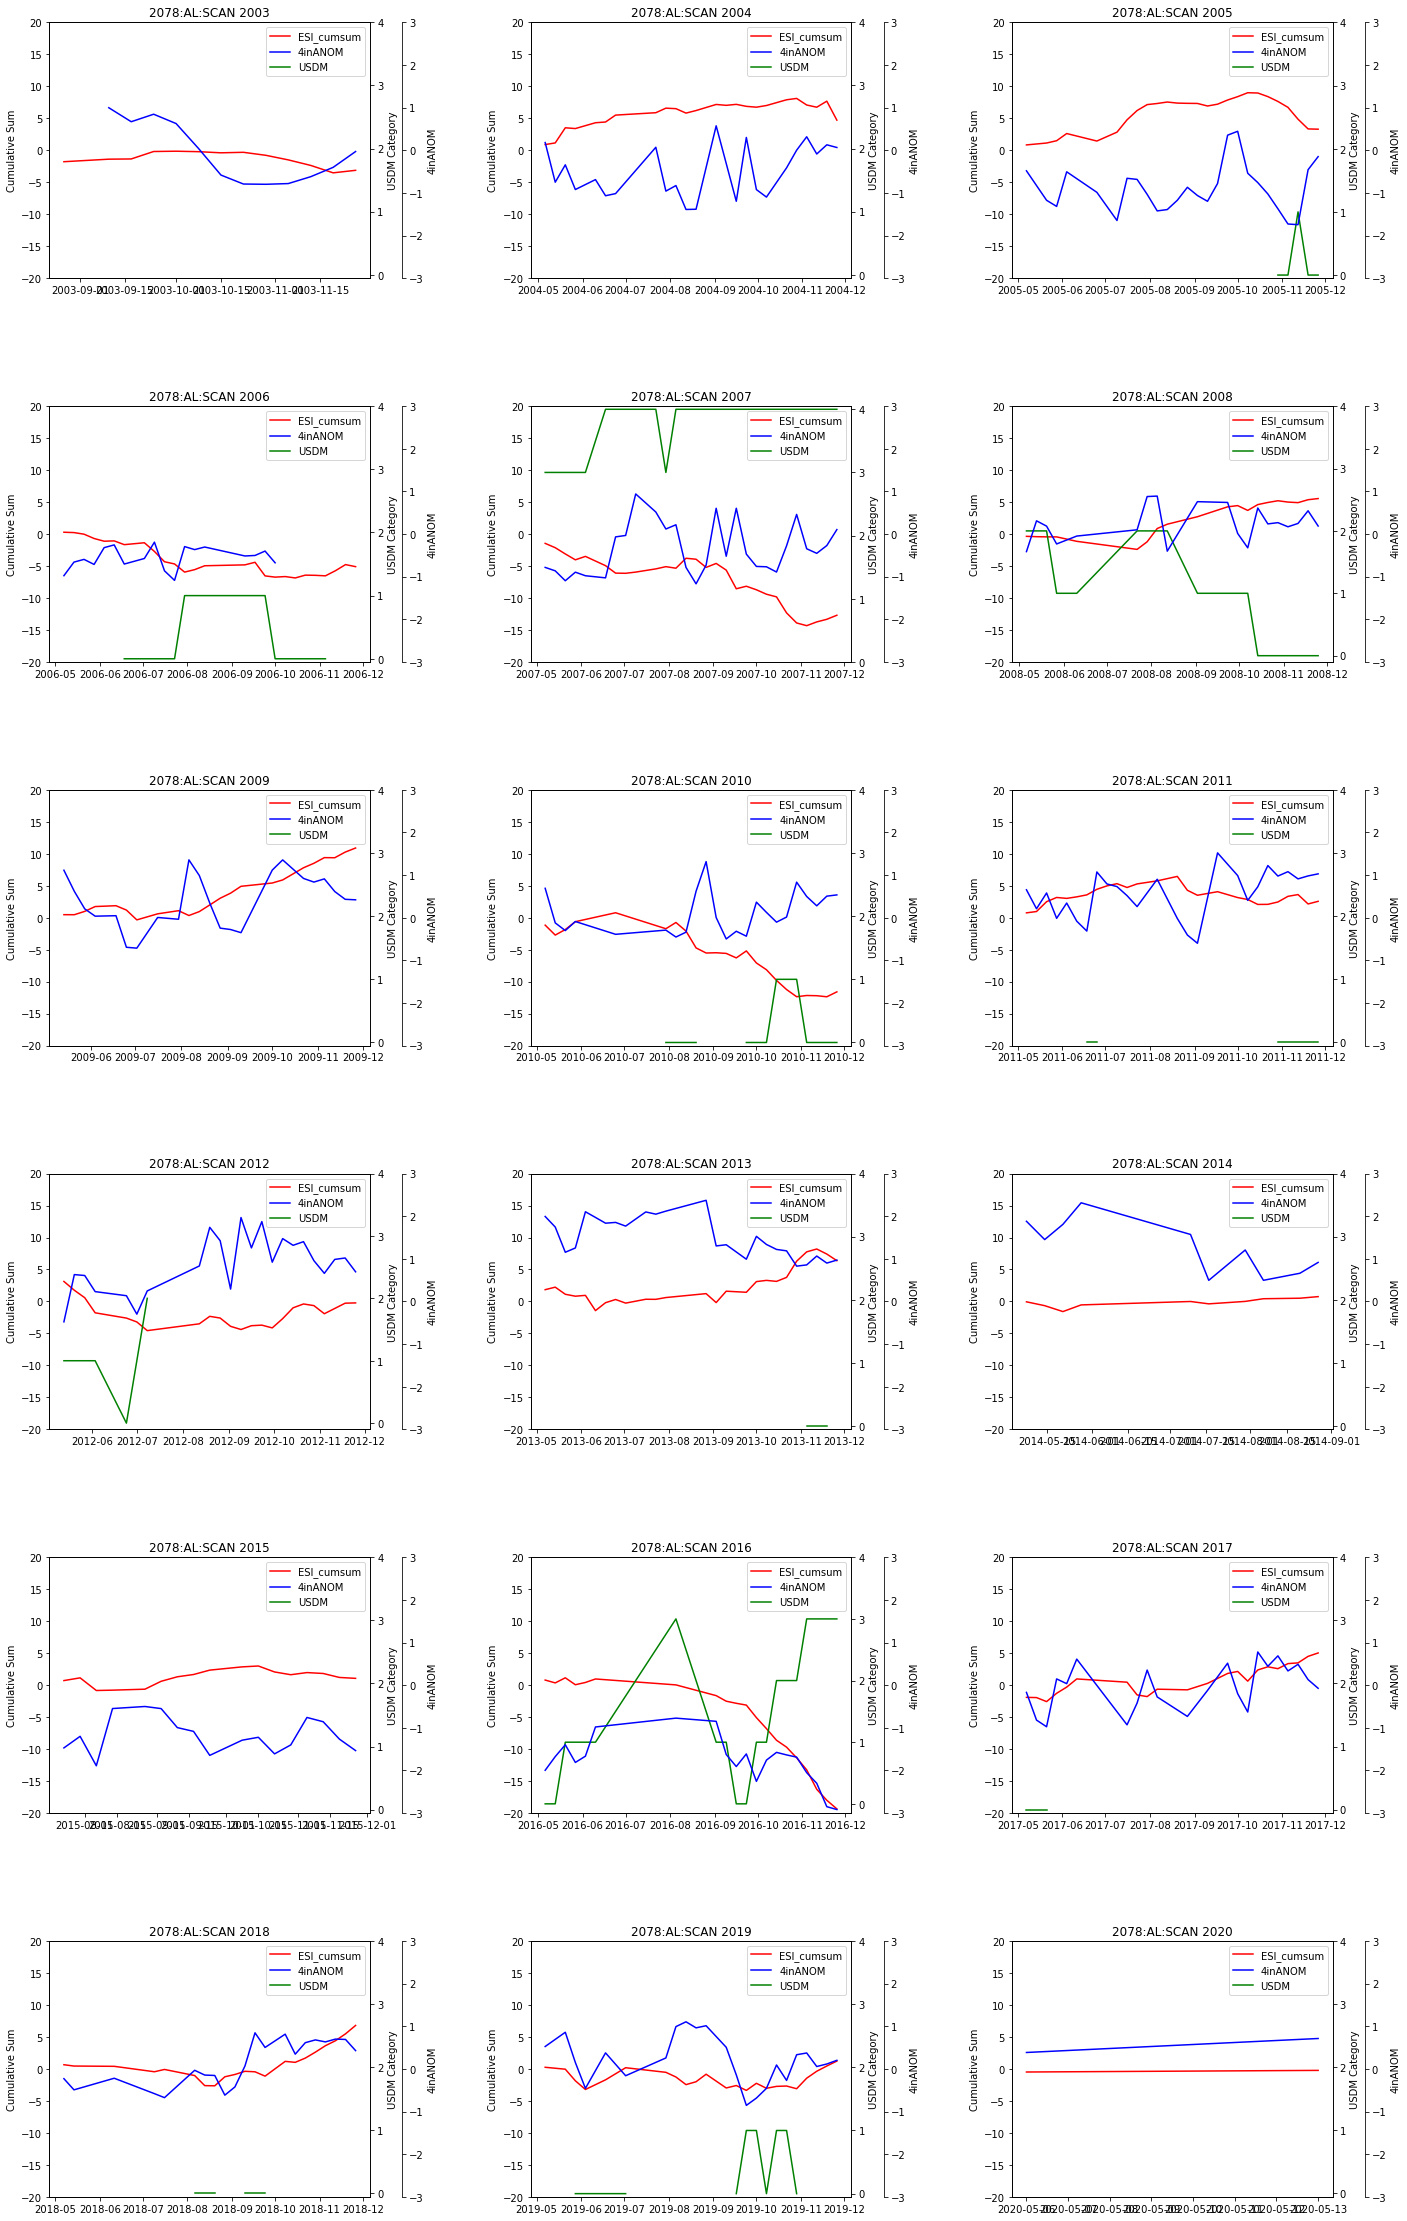

In [120]:
fig, ax = plt.subplots(figsize=(23,40), nrows=6, ncols=3)
axes = ax.flatten()
count=0
for y in test.index.year.unique():
    yearFrame = test[test.index.year==y]
    yearFrame['ESI_cumsum'] = yearFrame['ESI'].cumsum()
    ESI_h, = axes[count].plot(yearFrame['ESI_cumsum'], label='ESI_cumsum', color='red')
    axes[count].set_ylabel('Cumulative Sum')
    axes[count].set_ylim(-20, 20)
    
    axes2 = axes[count].twinx()
    USDM_h, = axes2.plot(yearFrame['Category'], label='USDM', color='green')
    axes2.set_ylabel('USDM Category')
    axes2.set_yticks([0,1,2,3,4])
    
    axes3 = axes[count].twinx()
    axes3.spines.right.set_position(("axes", 1.1))
    ANOM4in_h, = axes3.plot(yearFrame['4inANOM'], label='4inANOM', color='blue')
    axes3.set_ylabel('4inANOM')
    axes3.set_ylim(-3, 3)
        
    axes[count].set_title('2078:AL:SCAN ' + str(y))
    axes[count].legend(handles=[ESI_h, ANOM4in_h, USDM_h])
    count+=1
plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [121]:
combined

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2002-02-12 -1.326  2053:AL:SCAN       7       7  0.834835 -0.643664  0.542349   
2002-02-19 -1.577  2053:AL:SCAN       8       8  0.164259 -1.027176  0.290153   
2002-02-26 -1.735  2053:AL:SCAN       9       9  0.106221 -1.050136  0.179310   
2002-03-05 -0.752  2053:AL:SCAN      10      10 -0.309406 -1.455401  0.104532   
2002-03-12 -2.121  2053:AL:SCAN      11      11 -0.113839 -1.455137  0.076642   
...           ...           ...     ...     ...       ...       ...       ...   
2020-12-30  0.047  2115:AL:SCAN      53      53 -0.707107 -0.707107 -0.707107   
2020-12-30  0.266  2177:AL:SCAN      53      53       NaN       NaN       NaN   
2020-12-30  0.208  2175:AL:SCAN      53      53       NaN       NaN       NaN   
2020-12-30 -1.000  2173:AL:SCAN      53      53       NaN       NaN       NaN   
2020-12-30 -0.768  2053:AL:SCAN      53      53       NaN -1.101505  1.154264   

            20inANOM  40inANOM     2in_pr  ...    20in_pr    40in_pr  \
Date                                       ...                         
2002-02-12 -0.382594 -1.350406  78.965781  ...  33.190819   7.896985   
2002-02-19 -0.570702 -0.278074  53.503881  ...  27.351485  39.423898   
2002-02-26 -0.718167 -1.268593  51.350169  ...  23.278578   9.325034   
2002-03-05 -1.160224 -1.585050  37.640757  ...  12.207471   4.638106   
2002-03-12 -1.003007 -1.445378  44.233082  ...  15.706571   6.505554   
...              ...       ...        ...  ...        ...        ...   
2020-12-30 -0.707107 -0.707107  24.920739  ...  23.829883  25.503479   
2020-12-30       NaN       NaN        NaN  ...        NaN        NaN   
2020-12-30       NaN       NaN        NaN  ...        NaN        NaN   
2020-12-30       NaN       NaN        NaN  ...        NaN        NaN   
2020-12-30  0.418541  1.125623        NaN  ...  63.602610  88.770902   

            2inSMSDC  4inSMSDC  8inSMSDC  20inSMSDC  40inSMSDC  \
Date                                                             
2002-02-12       NaN       0.0       NaN        NaN        2.0   
2002-02-19       NaN       1.0       NaN        0.0        NaN   
2002-02-26       NaN       1.0       NaN        0.0        2.0   
2002-03-05       NaN       2.0       NaN        1.0        3.0   
2002-03-12       NaN       2.0       NaN        1.0        2.0   
...              ...       ...       ...        ...        ...   
2020-12-30       0.0       0.0       0.0        0.0        0.0   
2020-12-30       NaN       NaN       NaN        NaN        NaN   
2020-12-30       NaN       NaN       NaN        NaN        NaN   
2020-12-30       NaN       NaN       NaN        NaN        NaN   
2020-12-30       NaN       1.0       NaN        NaN        NaN   

                                 point  Category  Station Name  
Date                                                            
2002-02-12      POINT (-86.53333 34.9)       NaN         Wtars  
2002-02-19      POINT (-86.53333 34.9)       NaN         Wtars  
2002-02-26      POINT (-86.53333 34.9)       NaN         Wtars  
2002-03-05      POINT (-86.53333 34.9)       NaN         Wtars  
2002-03-12      POINT (-86.53333 34.9)       0.0         Wtars  
...                                ...       ...           ...  
2020-12-30  POINT (-85.74802 32.43455)       NaN      Tuskegee  
2020-12-30  POINT (-86.05253 32.28393)       NaN   Broad Acres  
2020-12-30  POINT (-85.51818 33.33168)       NaN       Wedowee  
2020-12-30  POINT (-87.98685 34.81982)       NaN  Isbell Farms  
2020-12-30      POINT (-86.53333 34.9)       NaN         Wtars  

[9674 rows x 22 columns]

In [122]:
#create a flash severity dataset 
store = {}

for s in combined['station'].unique():
    stationFrame = combined[combined['station']==s]
    mean = stationFrame.mean()['4inANOM']
    std = stationFrame.std()['4inANOM']
    stationFrame['4in3pentad']=stationFrame['4inANOM'].rolling(3, min_periods=3).mean()
    stationFrame['1pentad-3pentad']=stationFrame['4inANOM']-stationFrame['4in3pentad']
    store[s]=stationFrame
df = pd.concat(store, axis=0)

/tmp/ipykernel_18989/1488818547.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = stationFrame.mean()['4inANOM']
/tmp/ipykernel_18989/1488818547.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = stationFrame.std()['4inANOM']
/tmp/ipykernel_18989/1488818547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['4in3pentad']=stationFrame['4inANOM'].rolling(3, min_periods=3).mean()
/tmp/i

/tmp/ipykernel_18989/1488818547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['4in3pentad']=stationFrame['4inANOM'].rolling(3, min_periods=3).mean()
/tmp/ipykernel_18989/1488818547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['1pentad-3pentad']=stationFrame['4inANOM']-stationFrame['4in3pentad']
/tmp/ipykernel_18989/1488818547.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will

In [123]:
df.index=df.index.get_level_values('Date')

In [124]:
count = 0
def count_neg(x):
    global count
    if x < 0:
        count+=1
    else :
        count = 0 
    return count

In [125]:
#find all the flashdroughts for a particular year
store = {}
for s in df.station.unique():
    stationFrame=df[df['station']==s]
    for y in stationFrame.index.year.unique():
        yearFrame=stationFrame[stationFrame.index.year==y]
        yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
        count=0
        store[str(y) + s] = yearFrame
df = pd.concat(store, axis=0)

/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['numNegative']=yearFrame['1pentad-3pentad'].apply(count_neg)
/tmp/ipykernel_18989/4155808144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [126]:
df[(df['station']=='2057:AL:SCAN')&(df.index.get_level_values('Date').year==2019)]

ESI       station  week_x  week_y   2inANOM  \
                 Date                                                        
20192057:AL:SCAN 2019-01-08  0.365  2057:AL:SCAN       2       2 -1.103725   
                 2019-01-15 -1.547  2057:AL:SCAN       3       3 -2.049773   
                 2019-01-22 -1.359  2057:AL:SCAN       4       4 -1.000383   
                 2019-01-29 -0.755  2057:AL:SCAN       5       5 -1.540285   
                 2019-02-05  0.447  2057:AL:SCAN       6       6 -2.791447   
                 2019-02-12  0.064  2057:AL:SCAN       7       7 -2.172595   
                 2019-02-19 -1.022  2057:AL:SCAN       8       8 -1.795763   
                 2019-02-26  1.524  2057:AL:SCAN       9       9 -1.202150   
                 2019-03-05  1.153  2057:AL:SCAN      10      10 -2.017962   
                 2019-03-12  1.562  2057:AL:SCAN      11      11 -1.301397   
                 2019-03-19  0.391  2057:AL:SCAN      12      12 -2.156959   
                 2019-03-26  0.197  2057:AL:SCAN      13      13 -1.596423   
                 2019-04-02 -0.554  2057:AL:SCAN      14      14 -1.430030   
                 2019-04-09  0.805  2057:AL:SCAN      15      15 -0.407564   
                 2019-04-16  0.638  2057:AL:SCAN      16      16 -0.471811   
                 2019-04-23  0.637  2057:AL:SCAN      17      17 -0.173735   
                 2019-04-30 -0.530  2057:AL:SCAN      18      18 -0.608559   
                 2019-05-07  0.119  2057:AL:SCAN      19      19 -0.391417   
                 2019-05-14  0.742  2057:AL:SCAN      20      20  0.471348   
                 2019-05-21  0.304  2057:AL:SCAN      21      21 -0.542658   
                 2019-05-28 -1.277  2057:AL:SCAN      22      22 -1.187070   
                 2019-06-04 -1.352  2057:AL:SCAN      23      23 -1.070963   
                 2019-06-18  0.071  2057:AL:SCAN      25      25 -0.685170   
                 2019-07-02  0.607  2057:AL:SCAN      27      27 -0.798140   
                 2019-07-09 -0.287  2057:AL:SCAN      28      28 -1.032596   
                 2019-07-16  0.244  2057:AL:SCAN      29      29 -0.183719   
                 2019-07-23  1.450  2057:AL:SCAN      30      30  0.977861   
                 2019-07-30 -0.745  2057:AL:SCAN      31      31 -0.676740   
                 2019-08-06  0.581  2057:AL:SCAN      32      32 -0.320020   
                 2019-08-13  0.210  2057:AL:SCAN      33      33 -0.262023   
                 2019-08-20 -0.333  2057:AL:SCAN      34      34 -1.076246   
                 2019-08-27 -0.945  2057:AL:SCAN      35      35 -0.780767   
                 2019-09-03 -1.315  2057:AL:SCAN      36      36 -0.866953   
                 2019-09-10 -2.150  2057:AL:SCAN      37      37 -1.176373   
                 2019-09-17 -1.229  2057:AL:SCAN      38      38  0.327269   
                 2019-09-24 -1.182  2057:AL:SCAN      39      39 -1.466898   
                 2019-10-01 -0.581  2057:AL:SCAN      40      40 -1.234512   
                 2019-10-08 -1.424  2057:AL:SCAN      41      41 -0.714334   
                 2019-10-15  0.429  2057:AL:SCAN      42      42 -0.216305   
                 2019-10-22  0.356  2057:AL:SCAN      43      43 -1.065984   
                 2019-10-29 -0.418  2057:AL:SCAN      44      44  0.630463   
                 2019-11-05  1.549  2057:AL:SCAN      45      45  0.254656   
                 2019-11-12  0.877  2057:AL:SCAN      46      46 -0.073016   
                 2019-11-19  0.411  2057:AL:SCAN      47      47 -0.429538   
                 2019-11-26  0.613  2057:AL:SCAN      48      48 -0.533772   
                 2019-12-03 -0.319  2057:AL:SCAN      49      49 -0.328451   
                 2019-12-10  0.181  2057:AL:SCAN      50      50 -1.621854   
                 2019-12-17  0.563  2057:AL:SCAN      51      51 -0.376695   
                 2019-12-24  1.251  2057:AL:SCAN      52      52 -0.480208   
                 2019-12-31 -0.640  2057:AL:SCAN     

In [127]:
df.index = df.index.get_level_values('Date')

In [128]:
#here we are going to make sure that if the 1pentad-3pentad recovers for a 1 pentad to a positive amount and then
#falls again right after, that we still consider this a drought period. This will create a column of 
#sequences that occur in the data that are sequentially negative 

store = {}
for s in df.station.unique():
    stationFrame=df[df['station']==s]
    for y in stationFrame.index.year.unique():
        yearFrame=stationFrame[stationFrame.index.year==y]
        is_pos = yearFrame['1pentad-3pentad'].ge(0)
        consec_pos = (is_pos & is_pos.shift(1)) | (is_pos & is_pos.shift(-1))

        #group values by changes in consec positives
        consec_group = consec_pos.ne(consec_pos.shift(1)).cumsum()

        #count consecutive negatives within each group, then set consec_pos groups to 0
        yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
        yearFrame.loc[consec_pos,'sequenceNeg'] = 0
        store[s+str(y)] = yearFrame
df = pd.concat(store, axis=0)

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearFrame['sequenceNeg'] = consec_pos.groupby(consec_group).cumcount().add(1)
/tmp/ipykernel_18989/2651939108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [129]:
df

ESI       station  week_x  week_y   2inANOM  \
                 Date                                                        
2053:AL:SCAN2002 2002-02-12 -1.326  2053:AL:SCAN       7       7  0.834835   
                 2002-02-19 -1.577  2053:AL:SCAN       8       8  0.164259   
                 2002-02-26 -1.735  2053:AL:SCAN       9       9  0.106221   
                 2002-03-05 -0.752  2053:AL:SCAN      10      10 -0.309406   
                 2002-03-12 -2.121  2053:AL:SCAN      11      11 -0.113839   
...                            ...           ...     ...     ...       ...   
2181:AL:SCAN2020 2020-12-02 -0.337  2181:AL:SCAN      49      49  1.621483   
                 2020-12-09  0.266  2181:AL:SCAN      50      50  1.309197   
                 2020-12-16 -0.068  2181:AL:SCAN      51      51  0.807112   
                 2020-12-23  0.715  2181:AL:SCAN      52      52  0.490286   
                 2020-12-30 -1.414  2181:AL:SCAN      53      53       NaN   

                              4inANOM   8inANOM  20inANOM  40inANOM  \
                 Date                                                 
2053:AL:SCAN2002 2002-02-12 -0.643664  0.542349 -0.382594 -1.350406   
                 2002-02-19 -1.027176  0.290153 -0.570702 -0.278074   
                 2002-02-26 -1.050136  0.179310 -0.718167 -1.268593   
                 2002-03-05 -1.455401  0.104532 -1.160224 -1.585050   
                 2002-03-12 -1.455137  0.076642 -1.003007 -1.445378   
...                               ...       ...       ...       ...   
2181:AL:SCAN2020 2020-12-02  1.227094  1.383636  1.925959  1.081761   
                 2020-12-09  0.938780  0.903196  0.887784  0.855720   
                 2020-12-16  0.612089  0.423563  0.223647  0.281672   
                 2020-12-23  0.302427 -0.436928 -1.622440 -1.132620   
                 2020-12-30       NaN       NaN       NaN       NaN   

                                2in_pr  ...  8inSMSDC  20inSMSDC  40inSMSDC  \
                 Date                   ...                                   
2053:AL:SCAN2002 2002-02-12  78.965781  ...       NaN        NaN        2.0   
                 2002-02-19  53.503881  ...       NaN        0.0        NaN   
                 2002-02-26  51.350169  ...       NaN        0.0        2.0   
                 2002-03-05  37.640757  ...       NaN        1.0        3.0   
                 2002-03-12  44.233082  ...       NaN        1.0        2.0   
...                                ...  ...       ...        ...        ...   
2181:AL:SCAN2020 2020-12-02  97.288729  ...       NaN        NaN        NaN   
                 2020-12-09  93.123428  ...       NaN        NaN        NaN   
                 2020-12-16  77.927189  ...       NaN        NaN        NaN   
                 2020-12-23  65.267301  ...       NaN        NaN        1.0   
                 2020-12-30        NaN  ...       NaN        NaN        NaN   

                                                  point  Category  \
                 Date                                               
2053:AL:SCAN2002 2002-02-12      POINT (-86.53333 34.9)       NaN   
                 2002-02-19      POINT (-86.53333 34.9)       NaN   
                 2002-02-26      POINT (-86.53333 34.9)       NaN   
                 2002-03-05      POINT (-86.53333 34.9)       NaN   
                 2002-03-12      POINT (-86.53333 34.9)       0.0   
...                                                 ...       ...   
2181:AL:SCAN2020 2020-12-02  POINT (-87.55277 31.10923)       NaN   
                 2020-12-09  POINT (-87.55277 31.10923)       NaN   
                 2020-12-16  POINT (-87.55277 31.10923)       0.0   
                 2020-12-23  POINT (-87.55277 31.10923)       0.0   
                 2020-12-30  POINT (-87.55277 31.10923)       NaN   

                                  Station Name  4in3pentad  1pentad-3pentad  \
                 Date                                                         
2053:AL:

In [130]:
df[(df['station']=='2057:AL:SCAN')&(df.index.get_level_values('Date').year==2019)]

ESI       station  week_x  week_y   2inANOM  \
                 Date                                                        
2057:AL:SCAN2019 2019-01-08  0.365  2057:AL:SCAN       2       2 -1.103725   
                 2019-01-15 -1.547  2057:AL:SCAN       3       3 -2.049773   
                 2019-01-22 -1.359  2057:AL:SCAN       4       4 -1.000383   
                 2019-01-29 -0.755  2057:AL:SCAN       5       5 -1.540285   
                 2019-02-05  0.447  2057:AL:SCAN       6       6 -2.791447   
                 2019-02-12  0.064  2057:AL:SCAN       7       7 -2.172595   
                 2019-02-19 -1.022  2057:AL:SCAN       8       8 -1.795763   
                 2019-02-26  1.524  2057:AL:SCAN       9       9 -1.202150   
                 2019-03-05  1.153  2057:AL:SCAN      10      10 -2.017962   
                 2019-03-12  1.562  2057:AL:SCAN      11      11 -1.301397   
                 2019-03-19  0.391  2057:AL:SCAN      12      12 -2.156959   
                 2019-03-26  0.197  2057:AL:SCAN      13      13 -1.596423   
                 2019-04-02 -0.554  2057:AL:SCAN      14      14 -1.430030   
                 2019-04-09  0.805  2057:AL:SCAN      15      15 -0.407564   
                 2019-04-16  0.638  2057:AL:SCAN      16      16 -0.471811   
                 2019-04-23  0.637  2057:AL:SCAN      17      17 -0.173735   
                 2019-04-30 -0.530  2057:AL:SCAN      18      18 -0.608559   
                 2019-05-07  0.119  2057:AL:SCAN      19      19 -0.391417   
                 2019-05-14  0.742  2057:AL:SCAN      20      20  0.471348   
                 2019-05-21  0.304  2057:AL:SCAN      21      21 -0.542658   
                 2019-05-28 -1.277  2057:AL:SCAN      22      22 -1.187070   
                 2019-06-04 -1.352  2057:AL:SCAN      23      23 -1.070963   
                 2019-06-18  0.071  2057:AL:SCAN      25      25 -0.685170   
                 2019-07-02  0.607  2057:AL:SCAN      27      27 -0.798140   
                 2019-07-09 -0.287  2057:AL:SCAN      28      28 -1.032596   
                 2019-07-16  0.244  2057:AL:SCAN      29      29 -0.183719   
                 2019-07-23  1.450  2057:AL:SCAN      30      30  0.977861   
                 2019-07-30 -0.745  2057:AL:SCAN      31      31 -0.676740   
                 2019-08-06  0.581  2057:AL:SCAN      32      32 -0.320020   
                 2019-08-13  0.210  2057:AL:SCAN      33      33 -0.262023   
                 2019-08-20 -0.333  2057:AL:SCAN      34      34 -1.076246   
                 2019-08-27 -0.945  2057:AL:SCAN      35      35 -0.780767   
                 2019-09-03 -1.315  2057:AL:SCAN      36      36 -0.866953   
                 2019-09-10 -2.150  2057:AL:SCAN      37      37 -1.176373   
                 2019-09-17 -1.229  2057:AL:SCAN      38      38  0.327269   
                 2019-09-24 -1.182  2057:AL:SCAN      39      39 -1.466898   
                 2019-10-01 -0.581  2057:AL:SCAN      40      40 -1.234512   
                 2019-10-08 -1.424  2057:AL:SCAN      41      41 -0.714334   
                 2019-10-15  0.429  2057:AL:SCAN      42      42 -0.216305   
                 2019-10-22  0.356  2057:AL:SCAN      43      43 -1.065984   
                 2019-10-29 -0.418  2057:AL:SCAN      44      44  0.630463   
                 2019-11-05  1.549  2057:AL:SCAN      45      45  0.254656   
                 2019-11-12  0.877  2057:AL:SCAN      46      46 -0.073016   
                 2019-11-19  0.411  2057:AL:SCAN      47      47 -0.429538   
                 2019-11-26  0.613  2057:AL:SCAN      48      48 -0.533772   
                 2019-12-03 -0.319  2057:AL:SCAN      49      49 -0.328451   
                 2019-12-10  0.181  2057:AL:SCAN      50      50 -1.621854   
                 2019-12-17  0.563  2057:AL:SCAN      51      51 -0.376695   
                 2019-12-24  1.251  2057:AL:SCAN      52      52 -0.480208   
                 2019-12-31 -0.640  2057:AL:SCAN     

In [131]:
#locate all the indexes where the drought period starts and where the max value 
# of the drought is located. Return an array of the location of the maximum index
# and the maximum value for that drought period
indexes = []
values=[]
for i in range(len(df)-2):
    a = df.iloc[i]['sequenceNeg']
    b = df.iloc[i+1]['sequenceNeg']
    c = df.iloc[i+2]['sequenceNeg']
    #print(a, b, c)
    if (a>0)&(b>a):
        maxIndex=i+1
        maxValue=b
        if (c<b)&(b>=3):
            indexes.append(maxIndex)
            values.append(maxValue)
print(indexes)
print(values)

test = df.iloc[indexes]

[4, 10, 23, 33, 41, 49, 68, 75, 82, 86, 103, 114, 127, 134, 144, 154, 162, 169, 181, 195, 202, 216, 230, 238, 255, 262, 268, 283, 290, 295, 301, 306, 311, 322, 335, 341, 350, 356, 362, 368, 386, 395, 402, 439, 482, 490, 498, 516, 529, 536, 553, 564, 595, 606, 615, 620, 643, 653, 688, 693, 703, 709, 737, 742, 751, 765, 774, 783, 787, 801, 808, 817, 824, 842, 848, 859, 874, 892, 903, 916, 929, 934, 941, 947, 959, 965, 978, 987, 993, 999, 1004, 1019, 1028, 1032, 1051, 1054, 1061, 1067, 1078, 1086, 1094, 1101, 1119, 1134, 1141, 1148, 1156, 1188, 1194, 1204, 1219, 1260, 1300, 1307, 1319, 1331, 1336, 1342, 1348, 1360, 1366, 1374, 1380, 1386, 1393, 1400, 1422, 1425, 1433, 1449, 1469, 1484, 1494, 1502, 1511, 1536, 1545, 1551, 1561, 1574, 1587, 1593, 1605, 1612, 1619, 1625, 1630, 1638, 1650, 1659, 1668, 1679, 1686, 1691, 1700, 1725, 1739, 1744, 1756, 1768, 1782, 1791, 1799, 1811, 1838, 1853, 1858, 1869, 1878, 1886, 1902, 1909, 1921, 1929, 1944, 1960, 1965, 1990, 1997, 2011, 2018, 2033, 2049, 20

In [132]:
def get_signs(x):
    if x >= 0:
        return 0
    else:
        return 1 #means drought or negative score

In [133]:
store = {}
for s in df.station.unique():
    #give me just the dataframe where it is equal to unique station
    stationFrame=df[df['station']==s]
    
    #compute the 2, 4, and 8 week rolling means of ESI
    stationFrame['ESI2week']=stationFrame['ESI'].rolling(2, min_periods=2).mean()
    stationFrame['ESI4week']=stationFrame['ESI'].rolling(4, min_periods=2).mean()
    stationFrame['ESI8week']=stationFrame['ESI'].rolling(8, min_periods=2).mean()
    
    #compute the change in ESI from 1, 2, 4 and 8 weeks
    stationFrame['esi1_change'] = stationFrame['ESI'].diff()
    stationFrame['esi1_change_2wk']=stationFrame['ESI'].diff(2) #two week change
    stationFrame['esi1_change_3wk']=stationFrame['ESI'].diff(3) #three week change
    stationFrame['esi1_change_4wk']=stationFrame['ESI'].diff(4) #four week
    
    stationFrame['esi2_change'] = stationFrame['ESI2week'].diff()
    stationFrame['esi2_change_2wk'] = stationFrame['ESI2week'].diff(2)
    stationFrame['esi2_change_3wk'] = stationFrame['ESI2week'].diff(3)
    stationFrame['esi2_change_4wk']=stationFrame['ESI2week'].diff(4)
    
    stationFrame['esi4_change'] = stationFrame['ESI4week'].diff()
    stationFrame['esi4_change_2wk'] = stationFrame['ESI4week'].diff(2)
    stationFrame['esi4_change_3wk'] = stationFrame['ESI4week'].diff(3)
    stationFrame['esi4_change_4wk'] = stationFrame['ESI4week'].diff(4)
    
    stationFrame['esi8_change'] = stationFrame['ESI8week'].diff()
    stationFrame['esi8_change_2wk'] = stationFrame['ESI8week'].diff(2)
    stationFrame['esi8_change_3wk'] = stationFrame['ESI8week'].diff(3)
    stationFrame['esi8_change_4wk'] = stationFrame['ESI8week'].diff(4)
    
    #compute the mean for each change over the climatology 
    mean1week = stationFrame['esi1_change'].mean()
    mean1week_2 = stationFrame['esi1_change_2wk'].mean() #2 week diff
    mean1week_3 = stationFrame['esi1_change_3wk'].mean() #3 week diff
    mean1week_4 = stationFrame['esi1_change_4wk'].mean() #4 week diff
    
    mean2week = stationFrame['esi2_change'].mean()
    mean2week_2 = stationFrame['esi2_change_2wk'].mean() #2 week diff
    mean2week_3 = stationFrame['esi2_change_3wk'].mean() #3 week diff
    mean2week_4 = stationFrame['esi2_change_4wk'].mean() #4 week diff
    
    mean4week = stationFrame['esi4_change'].mean()
    mean4week_2 = stationFrame['esi4_change_2wk'].mean() #2 week diff
    mean4week_3 = stationFrame['esi4_change_3wk'].mean() #3 week diff
    mean4week_4 = stationFrame['esi4_change_4wk'].mean() #4 week diff
    
    mean8week = stationFrame['esi8_change'].mean()
    mean8week_2 = stationFrame['esi8_change_2wk'].mean() #2 week diff
    mean8week_3 = stationFrame['esi8_change_3wk'].mean() #3 week diff
    mean8week_4 = stationFrame['esi8_change_4wk'].mean() #4 week diff
    
    #compute the standard deviation over the climatology for the station
    std1week = stationFrame['esi1_change'].std()
    std1week_2 = stationFrame['esi1_change_2wk'].std() #2 week diff
    std1week_3 = stationFrame['esi1_change_3wk'].std() #3 week diff
    std1week_4 = stationFrame['esi1_change_4wk'].std() #4 week diff
    
    std2week = stationFrame['esi2_change'].std()
    std2week_2 = stationFrame['esi2_change_2wk'].std() #2 week diff
    std2week_3 = stationFrame['esi2_change_3wk'].std() #3 week diff
    std2week_4 = stationFrame['esi2_change_4wk'].std() #4 week diff
    
    std4week = stationFrame['esi4_change'].std()
    std4week_2 = stationFrame['esi4_change_2wk'].std() #2 week diff
    std4week_3 = stationFrame['esi4_change_3wk'].std() #3 week diff
    std4week_4 = stationFrame['esi4_change_4wk'].std() #4 week diff
    
    std8week = stationFrame['esi8_change'].std()
    std8week_2 = stationFrame['esi8_change_2wk'].std() #2 week diff
    std8week_3 = stationFrame['esi8_change_3wk'].std() #3 week diff
    std8week_4 = stationFrame['esi8_change_4wk'].std() #4 week diff
    
    #compute the change anomaly at station
    stationFrame['esi1_change_anom']=(stationFrame['esi1_change']-mean1week)/std1week
    stationFrame['esi1_change_anom_2wk']=(stationFrame['esi1_change_2wk']-mean1week_2)/std1week_2
    stationFrame['esi1_change_anom_3wk']=(stationFrame['esi1_change_3wk']-mean1week_3)/std1week_3
    stationFrame['esi1_change_anom_4wk']=(stationFrame['esi1_change_4wk']-mean1week_4)/std1week_4
    
    stationFrame['esi2_change_anom']=(stationFrame['esi2_change']-mean2week)/std2week
    stationFrame['esi2_change_anom_2wk']=(stationFrame['esi2_change_2wk']-mean2week_2)/std2week_2
    stationFrame['esi2_change_anom_3wk']=(stationFrame['esi2_change_3wk']-mean2week_3)/std2week_3
    stationFrame['esi2_change_anom_4wk']=(stationFrame['esi2_change_4wk']-mean2week_4)/std2week_4
    
    stationFrame['esi4_change_anom']=(stationFrame['esi4_change']-mean4week)/std4week
    stationFrame['esi4_change_anom_2wk']=(stationFrame['esi4_change_2wk']-mean4week_2)/std4week_2
    stationFrame['esi4_change_anom_3wk']=(stationFrame['esi4_change_3wk']-mean4week_3)/std4week_3
    stationFrame['esi4_change_anom_4wk']=(stationFrame['esi4_change_4wk']-mean4week_4)/std4week_4
    
    stationFrame['esi8_change_anom']=(stationFrame['esi8_change']-mean8week)/std8week
    stationFrame['esi8_change_anom_2wk']=(stationFrame['esi8_change_2wk']-mean8week_2)/std8week_2
    stationFrame['esi8_change_anom_3wk']=(stationFrame['esi8_change_3wk']-mean8week_3)/std8week_3
    stationFrame['esi8_change_anom_4wk']=(stationFrame['esi8_change_4wk']-mean8week_4)/std8week_4
    
    #store it into the dictionary
    store[s]=stationFrame
    
#concat all data into dataframe for analysis
testFrame = pd.concat(store, axis=0)

/tmp/ipykernel_18989/2849449314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['ESI2week']=stationFrame['ESI'].rolling(2, min_periods=2).mean()
/tmp/ipykernel_18989/2849449314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['ESI4week']=stationFrame['ESI'].rolling(4, min_periods=2).mean()
/tmp/ipykernel_18989/2849449314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_18989/2849449314.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi4_change'] = stationFrame['ESI4week'].diff()
/tmp/ipykernel_18989/2849449314.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi4_change_2wk'] = stationFrame['ESI4week'].diff(2)
/tmp/ipykernel_18989/2849449314.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

/tmp/ipykernel_18989/2849449314.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi1_change_anom_4wk']=(stationFrame['esi1_change_4wk']-mean1week_4)/std1week_4
/tmp/ipykernel_18989/2849449314.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi2_change_anom']=(stationFrame['esi2_change']-mean2week)/std2week
/tmp/ipykernel_18989/2849449314.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_18989/2849449314.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change_anom_4wk']=(stationFrame['esi8_change_4wk']-mean8week_4)/std8week_4
/tmp/ipykernel_18989/2849449314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['ESI2week']=stationFrame['ESI'].rolling(2, min_periods=2).mean()
/tmp/ipykernel_18989/2849449314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

/tmp/ipykernel_18989/2849449314.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change'] = stationFrame['ESI8week'].diff()
/tmp/ipykernel_18989/2849449314.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change_2wk'] = stationFrame['ESI8week'].diff(2)
/tmp/ipykernel_18989/2849449314.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

/tmp/ipykernel_18989/2849449314.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi4_change_anom']=(stationFrame['esi4_change']-mean4week)/std4week
/tmp/ipykernel_18989/2849449314.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi4_change_anom_2wk']=(stationFrame['esi4_change_2wk']-mean4week_2)/std4week_2
/tmp/ipykernel_18989/2849449314.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_18989/2849449314.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi1_change_3wk']=stationFrame['ESI'].diff(3) #three week change
/tmp/ipykernel_18989/2849449314.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi1_change_4wk']=stationFrame['ESI'].diff(4) #four week
/tmp/ipykernel_18989/2849449314.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

/tmp/ipykernel_18989/2849449314.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi1_change_anom']=(stationFrame['esi1_change']-mean1week)/std1week
/tmp/ipykernel_18989/2849449314.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi1_change_anom_2wk']=(stationFrame['esi1_change_2wk']-mean1week_2)/std1week_2
/tmp/ipykernel_18989/2849449314.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_18989/2849449314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['ESI2week']=stationFrame['ESI'].rolling(2, min_periods=2).mean()
/tmp/ipykernel_18989/2849449314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['ESI4week']=stationFrame['ESI'].rolling(4, min_periods=2).mean()
/tmp/ipykernel_18989/2849449314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

/tmp/ipykernel_18989/2849449314.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change_2wk'] = stationFrame['ESI8week'].diff(2)
/tmp/ipykernel_18989/2849449314.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change_3wk'] = stationFrame['ESI8week'].diff(3)
/tmp/ipykernel_18989/2849449314.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

/tmp/ipykernel_18989/2849449314.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change_anom']=(stationFrame['esi8_change']-mean8week)/std8week
/tmp/ipykernel_18989/2849449314.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change_anom_2wk']=(stationFrame['esi8_change_2wk']-mean8week_2)/std8week_2
/tmp/ipykernel_18989/2849449314.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_18989/2849449314.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi4_change_2wk'] = stationFrame['ESI4week'].diff(2)
/tmp/ipykernel_18989/2849449314.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi4_change_3wk'] = stationFrame['ESI4week'].diff(3)
/tmp/ipykernel_18989/2849449314.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

/tmp/ipykernel_18989/2849449314.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi1_change_anom_4wk']=(stationFrame['esi1_change_4wk']-mean1week_4)/std1week_4
/tmp/ipykernel_18989/2849449314.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi2_change_anom']=(stationFrame['esi2_change']-mean2week)/std2week
/tmp/ipykernel_18989/2849449314.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_18989/2849449314.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationFrame['esi8_change_anom_4wk']=(stationFrame['esi8_change_4wk']-mean8week_4)/std8week_4


In [134]:
testFrame.index = testFrame.index.get_level_values('Date')

In [135]:
testFrame

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2002-02-12 -1.326  2053:AL:SCAN       7       7  0.834835 -0.643664  0.542349   
2002-02-19 -1.577  2053:AL:SCAN       8       8  0.164259 -1.027176  0.290153   
2002-02-26 -1.735  2053:AL:SCAN       9       9  0.106221 -1.050136  0.179310   
2002-03-05 -0.752  2053:AL:SCAN      10      10 -0.309406 -1.455401  0.104532   
2002-03-12 -2.121  2053:AL:SCAN      11      11 -0.113839 -1.455137  0.076642   
...           ...           ...     ...     ...       ...       ...       ...   
2020-12-02 -0.337  2181:AL:SCAN      49      49  1.621483  1.227094  1.383636   
2020-12-09  0.266  2181:AL:SCAN      50      50  1.309197  0.938780  0.903196   
2020-12-16 -0.068  2181:AL:SCAN      51      51  0.807112  0.612089  0.423563   
2020-12-23  0.715  2181:AL:SCAN      52      52  0.490286  0.302427 -0.436928   
2020-12-30 -1.414  2181:AL:SCAN      53      53       NaN       NaN       NaN   

            20inANOM  40inANOM     2in_pr  ...  esi2_change_anom_3wk  \
Date                                       ...                         
2002-02-12 -0.382594 -1.350406  78.965781  ...                   NaN   
2002-02-19 -0.570702 -0.278074  53.503881  ...                   NaN   
2002-02-26 -0.718167 -1.268593  51.350169  ...                   NaN   
2002-03-05 -1.160224 -1.585050  37.640757  ...                   NaN   
2002-03-12 -1.003007 -1.445378  44.233082  ...              0.008230   
...              ...       ...        ...  ...                   ...   
2020-12-02  1.925959  1.081761  97.288729  ...              0.729035   
2020-12-09  0.887784  0.855720  93.123428  ...              1.064996   
2020-12-16  0.223647  0.281672  77.927189  ...              1.105831   
2020-12-23 -1.622440 -1.132620  65.267301  ...              0.692376   
2020-12-30       NaN       NaN        NaN  ...             -0.295088   

            esi2_change_anom_4wk  esi4_change_anom  esi4_change_anom_2wk  \
Date                                                                       
2002-02-12                   NaN               NaN                   NaN   
2002-02-19                   NaN               NaN                   NaN   
2002-02-26                   NaN         -0.275622                   NaN   
2002-03-05                   NaN          0.560553              0.181687   
2002-03-12                   NaN         -0.573135             -0.009710   
...                          ...               ...                   ...   
2020-12-02              0.187488          0.957390              0.174247   
2020-12-09              1.048639          0.656259              1.027343   
2020-12-16              1.142494          1.103457              1.120319   
2020-12-23              1.261703          0.841784              1.238413   
2020-12-30              0.066945         -0.755944              0.054831   

            esi4_change_anom_3wk  esi4_change_anom_4wk  esi8_change_anom  \
Date                                                                       
2002-02-12                   NaN                   NaN               NaN   
2002-02-19                   NaN                   NaN               NaN   
2002-02-26                   NaN                   NaN         -0.542363   
2002-03-05                   NaN                   NaN          1.107115   
2002-03-12             -0.147293                   NaN         -0.881266   
...                          ...                   ...               ...   
2020-12-02             -0.537732             -1.029559          0.084918   
2020-12-09              0.471145             -0.171152         -0.662214   
2020-12-16              1.369083              0.884961         -0.237599   
2020-12-23              1.311005              1.541198          0.159294   
2020-12-30              0.601558              0.804271          0.201890   

            esi8_change_anom_2wk  esi8_change

In [136]:
testFrame.reset_index(inplace=True)

In [137]:
#now get the esi values prior to the drought events and return a dataframe with that information
date = []
stations = []
#items 1 week esi, 1 week diff
prior2esi = [] #1week values 2 days before the flash drought
prior1esi = [] #week values 1 day before the flash drought
startesi = []
next1esi = [] #one day after start
next2esi = [] #two days after start

#items 1 week esi, 2week diff 
prior2esi_2wk = [] #1week values 2 days before the flash drought
prior1esi_2wk = [] #1week values 1 day before the flash drought 
startesi_2wk = []
next1esi_2wk = [] #one day after start
next2esi_2wk = [] #two days after start

#items 1 week esi, 3week diff 
prior2esi_3wk = [] #1week values 2 days before the flash drought
prior1esi_3wk = [] #1week values 1 day before the flash drought 
startesi_3wk = []
next1esi_3wk = [] #one day after start
next2esi_3wk = [] #two days after start

#items 1 week esi, 4week diff 
prior2esi_4wk = [] #1week values 2 days before the flash drought
prior1esi_4wk = [] #1week values 1 day before the flash drought 
startesi_4wk = []
next1esi_4wk = [] #one day after start
next2esi_4wk = [] #two days after start

#sums 1 week esi 1 week diff
startesisum = [] #total values across the flash drought
prior1esisum = []
prior2esisum = []

#sums 1 week esi 2 week diff
startesisum_2wk = [] #total values across the flash drought
prior1esisum_2wk = []
prior2esisum_2wk = []

#sums 1 week esi 3 week diff
startesisum_3wk = [] #total values across the flash drought
prior1esisum_3wk = []
prior2esisum_3wk = []

#sums 1 week esi 4 week diff
startesisum_4wk = [] #total values across the flash drought
prior1esisum_4wk = []
prior2esisum_4wk = []

#items 2 week esi 1 week diff
prior2esi2 = [] #2week
prior1esi2 = []
startesi2 = []
next1esi2 = [] #one day after start
next2esi2 = [] #two days after start

#items 2 week esi 2 week diff
prior2esi2_2wk = [] #2week
prior1esi2_2wk = []
startesi2_2wk = []
next1esi2_2wk = [] #one day after start
next2esi2_2wk = [] #two days after start

#items 2 week esi 3 week diff
prior2esi2_3wk = [] #2week
prior1esi2_3wk = []
startesi2_3wk = []
next1esi2_3wk = [] #one day after start
next2esi2_3wk = [] #two days after start

#items 2 week esi 4 week diff
prior2esi2_4wk = [] #2week
prior1esi2_4wk = []
startesi2_4wk = []
next1esi2_4wk = [] #one day after start
next2esi2_4wk = [] #two days after start

#sums 2 week esi 1 week diff
startesi2sum = [] #total values across the flash drought
prior1esi2sum = []
prior2esi2sum = []

#sums 2 week esi 2 week diff
startesi2sum_2wk = [] #total values across the flash drought
prior1esi2sum_2wk = []
prior2esi2sum_2wk = []

#sums 2 week esi 3 week diff
startesi2sum_3wk = [] #total values across the flash drought
prior1esi2sum_3wk = []
prior2esi2sum_3wk = []

#sums 2 week esi 4 week diff
startesi2sum_4wk = [] #total values across the flash drought
prior1esi2sum_4wk = []
prior2esi2sum_4wk = []

#4 week esi with 1 week diff
prior2esi4 = [] #4week
prior1esi4 = []
startesi4 = []
next1esi4 = [] #one day after start
next2esi4 = [] #two days after start

#4 week esi with 2 week diff
prior2esi4_2wk = [] #4week
prior1esi4_2wk = []
startesi4_2wk = []
next1esi4_2wk = [] #one day after start
next2esi4_2wk = [] #two days after start

#4 week esi with 3 week diff
prior2esi4_3wk = [] #4week
prior1esi4_3wk = []
startesi4_3wk = []
next1esi4_3wk = [] #one day after start
next2esi4_3wk = [] #two days after start

#4 week esi with 4 week diff
prior2esi4_4wk = [] #4week
prior1esi4_4wk = []
startesi4_4wk = []
next1esi4_4wk = [] #one day after start
next2esi4_4wk = [] #two days after start

#sum 4week esi with 1 week diff
startesi4sum = [] #total values across the flash drought
prior1esi4sum = []
prior2esi4sum = []

#sum 4week esi with 2 week diff
startesi4sum_2wk = [] #total values across the flash drought
prior1esi4sum_2wk = []
prior2esi4sum_2wk = []

#sum 4week esi with 3 week diff
startesi4sum_3wk = [] #total values across the flash drought
prior1esi4sum_3wk = []
prior2esi4sum_3wk = []

#sum 4week esi with 4 week diff
startesi4sum_4wk = [] #total values across the flash drought
prior1esi4sum_4wk = []
prior2esi4sum_4wk = []

#8 week esi with 1 week diff
prior2esi8 = [] #8week
prior1esi8 = []
startesi8 = []
next1esi8 = [] #one day after start
next2esi8 = [] #two days after start

#8 week esi with 2 week diff
prior2esi8_2wk = [] #8week
prior1esi8_2wk = []
startesi8_2wk = []
next1esi8_2wk = [] #one day after start
next2esi8_2wk = [] #two days after start

#8 week esi with 3 week diff
prior2esi8_3wk = [] #8week
prior1esi8_3wk = []
startesi8_3wk = []
next1esi8_3wk = [] #one day after start
next2esi8_3wk = [] #two days after start

#8 week esi with 4 week diff
prior2esi8_4wk = [] #8week
prior1esi8_4wk = []
startesi8_4wk = []
next1esi8_4wk = [] #one day after start
next2esi8_4wk = [] #two days after start

#sum 8 week esi with 1 week diff
startesi8sum = [] #total values across the flash drought
prior1esi8sum = []
prior2esi8sum = []

#sum 8 week esi with 2 week diff
startesi8sum_2wk = [] #total values across the flash drought
prior1esi8sum_2wk = []
prior2esi8sum_2wk = []

#sum 8 week esi with 3 week diff
startesi8sum_3wk = [] #total values across the flash drought
prior1esi8sum_3wk = []
prior2esi8sum_3wk = []

#sum 8 week esi with 4 week diff
startesi8sum_4wk = [] #total values across the flash drought
prior1esi8sum_4wk = []
prior2esi8sum_4wk = []

seqNegs = [] #sequence of negatives 
fourinprend = [] #the 4inpr value we need to check to see if D1 has occured
fourinprstart = [] #the 4inpr value at the start of drought event
for i in range(len(indexes)):
    subtract = values[i]
    index = indexes[i]
    start = index-subtract
    
    #flashdate 
    dateStart = testFrame.iloc[start]['Date']
    date.append(dateStart)
    
    #esi change anom 1 week diff
    prior2esi_change = testFrame.iloc[start-2]['esi1_change_anom'].item() #index prior to flashdrought 2 pentads
    prior1esi_change = testFrame.iloc[start-1]['esi1_change_anom'].item() #index prior to flashdrought 1 pentad
    startesi_change = testFrame.iloc[start]['esi1_change_anom'].item() #index at start of flashdrought
    next1esichange = testFrame.iloc[start+1]['esi1_change_anom'].item()
    next2esichange = testFrame.iloc[start+2]['esi1_change_anom'].item()
    prior2esi.append(prior2esi_change)
    prior1esi.append(prior1esi_change)
    startesi.append(startesi_change)
    next1esi.append(next1esichange)
    next2esi.append(next2esichange)
    
    #esi change anom 2 week diff
    prior2esi_change_2wk = testFrame.iloc[start-2]['esi1_change_anom_2wk'].item() #index prior to flashdrought 2 pentads
    prior1esi_change_2wk = testFrame.iloc[start-1]['esi1_change_anom_2wk'].item() #index prior to flashdrought 1 pentad
    startesi_change_2wk = testFrame.iloc[start]['esi1_change_anom_2wk'].item() #index at start of flashdrought
    next1esichange_2wk = testFrame.iloc[start+1]['esi1_change_anom_2wk'].item()
    next2esichange_2wk = testFrame.iloc[start+2]['esi1_change_anom_2wk'].item()
    prior2esi_2wk.append(prior2esi_change_2wk)
    prior1esi_2wk.append(prior1esi_change_2wk)
    startesi_2wk.append(startesi_change_2wk)
    next1esi_2wk.append(next1esichange_2wk)
    next2esi_2wk.append(next2esichange_2wk)
    
    #esi change anom 3 week diff
    prior2esi_change_3wk = testFrame.iloc[start-2]['esi1_change_anom_3wk'].item() #index prior to flashdrought 2 pentads
    prior1esi_change_3wk = testFrame.iloc[start-1]['esi1_change_anom_3wk'].item() #index prior to flashdrought 1 pentad
    startesi_change_3wk = testFrame.iloc[start]['esi1_change_anom_3wk'].item() #index at start of flashdrought
    next1esichange_3wk = testFrame.iloc[start+1]['esi1_change_anom_3wk'].item()
    next2esichange_3wk = testFrame.iloc[start+2]['esi1_change_anom_3wk'].item()
    prior2esi_3wk.append(prior2esi_change_3wk)
    prior1esi_3wk.append(prior1esi_change_3wk)
    startesi_3wk.append(startesi_change_3wk)
    next1esi_3wk.append(next1esichange_3wk)
    next2esi_3wk.append(next2esichange_3wk)
    
    #esi change anom 4 week diff
    prior2esi_change_4wk = testFrame.iloc[start-2]['esi1_change_anom_4wk'].item() #index prior to flashdrought 2 pentads
    prior1esi_change_4wk = testFrame.iloc[start-1]['esi1_change_anom_4wk'].item() #index prior to flashdrought 1 pentad
    startesi_change_4wk = testFrame.iloc[start]['esi1_change_anom_4wk'].item() #index at start of flashdrought
    next1esichange_4wk = testFrame.iloc[start+1]['esi1_change_anom_4wk'].item()
    next2esichange_4wk = testFrame.iloc[start+2]['esi1_change_anom_4wk'].item()
    prior2esi_4wk.append(prior2esi_change_4wk)
    prior1esi_4wk.append(prior1esi_change_4wk)
    startesi_4wk.append(startesi_change_4wk)
    next1esi_4wk.append(next1esichange_4wk)
    next2esi_4wk.append(next2esichange_4wk)
    
    #total changes 1 week esi 1wk diff
    prior2esi_total = testFrame.iloc[start-2:start+subtract]['esi1_change_anom'].sum() #from 2days prior to end
    prior1esi_total = testFrame.iloc[start-1:start+subtract]['esi1_change_anom'].sum() #from 1days prior to end
    startesi_total = testFrame.iloc[start:start+subtract]['esi1_change_anom'].sum() #from start to end
    prior2esisum.append(prior2esi_total)
    prior1esisum.append(prior1esi_total)
    startesisum.append(startesi_total)
    
    #total changes 1 week esi 2wk diff
    prior2esi_total_2wk = testFrame.iloc[start-2:start+subtract]['esi1_change_anom_2wk'].sum() #from 2days prior to end
    prior1esi_total_2wk = testFrame.iloc[start-1:start+subtract]['esi1_change_anom_2wk'].sum() #from 1days prior to end
    startesi_total_2wk = testFrame.iloc[start:start+subtract]['esi1_change_anom_2wk'].sum() #from start to end
    prior2esisum_2wk.append(prior2esi_total_2wk)
    prior1esisum_2wk.append(prior1esi_total_2wk)
    startesisum_2wk.append(startesi_total_2wk)
    
    #total changes 1 week esi 3wk diff
    prior2esi_total_3wk = testFrame.iloc[start-2:start+subtract]['esi1_change_anom_3wk'].sum() #from 2days prior to end
    prior1esi_total_3wk = testFrame.iloc[start-1:start+subtract]['esi1_change_anom_3wk'].sum() #from 1days prior to end
    startesi_total_3wk = testFrame.iloc[start:start+subtract]['esi1_change_anom_3wk'].sum() #from start to end
    prior2esisum_3wk.append(prior2esi_total_3wk)
    prior1esisum_3wk.append(prior1esi_total_3wk)
    startesisum_3wk.append(startesi_total_3wk)
    
    #total changes 1 week esi 4wk diff
    prior2esi_total_4wk = testFrame.iloc[start-2:start+subtract]['esi1_change_anom_4wk'].sum() #from 2days prior to end
    prior1esi_total_4wk = testFrame.iloc[start-1:start+subtract]['esi1_change_anom_4wk'].sum() #from 1days prior to end
    startesi_total_4wk = testFrame.iloc[start:start+subtract]['esi1_change_anom_4wk'].sum() #from start to end
    prior2esisum_4wk.append(prior2esi_total_4wk)
    prior1esisum_4wk.append(prior1esi_total_4wk)
    startesisum_4wk.append(startesi_total_4wk)
    
    #2 week esi change anom 1 week diff 
    prior2esi2_change = testFrame.iloc[start-2]['esi2_change_anom'].item() #index prior to flashdrought 2 pentads
    prior1esi2_change = testFrame.iloc[start-1]['esi2_change_anom'].item() #index prior to flashdrought 1 pentads
    startesi2_change = testFrame.iloc[start]['esi2_change_anom'].item() #index at start of flashdrought
    next1esi2change = testFrame.iloc[start+1]['esi2_change_anom'].item() #index 1 after start of flashdrought
    next2esi2change = testFrame.iloc[start+2]['esi2_change_anom'].item() #index 2 after start of flashdrought
    prior2esi2.append(prior2esi2_change)
    prior1esi2.append(prior1esi2_change)
    startesi2.append(startesi2_change)
    next1esi2.append(next1esi2change)
    next2esi2.append(next2esi2change)
    
    #2 week esi change anom 2 week diff 
    prior2esi2_change_2wk = testFrame.iloc[start-2]['esi2_change_anom_2wk'].item() #index prior to flashdrought 2 pentads
    prior1esi2_change_2wk = testFrame.iloc[start-1]['esi2_change_anom_2wk'].item() #index prior to flashdrought 1 pentads
    startesi2_change_2wk = testFrame.iloc[start]['esi2_change_anom_2wk'].item() #index at start of flashdrought
    next1esi2change_2wk = testFrame.iloc[start+1]['esi2_change_anom_2wk'].item() #index 1 after start of flashdrought
    next2esi2change_2wk = testFrame.iloc[start+2]['esi2_change_anom_2wk'].item() #index 2 after start of flashdrought
    prior2esi2_2wk.append(prior2esi2_change_2wk)
    prior1esi2_2wk.append(prior1esi2_change_2wk)
    startesi2_2wk.append(startesi2_change_2wk)
    next1esi2_2wk.append(next1esi2change_2wk)
    next2esi2_2wk.append(next2esi2change_2wk)
    
    #2 week esi change anom 3 week diff 
    prior2esi2_change_3wk = testFrame.iloc[start-2]['esi2_change_anom_3wk'].item() #index prior to flashdrought 2 pentads
    prior1esi2_change_3wk = testFrame.iloc[start-1]['esi2_change_anom_3wk'].item() #index prior to flashdrought 1 pentads
    startesi2_change_3wk = testFrame.iloc[start]['esi2_change_anom_3wk'].item() #index at start of flashdrought
    next1esi2change_3wk = testFrame.iloc[start+1]['esi2_change_anom_3wk'].item() #index 1 after start of flashdrought
    next2esi2change_3wk = testFrame.iloc[start+2]['esi2_change_anom_3wk'].item() #index 2 after start of flashdrought
    prior2esi2_3wk.append(prior2esi2_change_3wk)
    prior1esi2_3wk.append(prior1esi2_change_3wk)
    startesi2_3wk.append(startesi2_change_3wk)
    next1esi2_3wk.append(next1esi2change_3wk)
    next2esi2_3wk.append(next2esi2change_3wk)
    
    #2 week esi change anom 3 week diff 
    prior2esi2_change_4wk = testFrame.iloc[start-2]['esi2_change_anom_4wk'].item() #index prior to flashdrought 2 pentads
    prior1esi2_change_4wk = testFrame.iloc[start-1]['esi2_change_anom_4wk'].item() #index prior to flashdrought 1 pentads
    startesi2_change_4wk = testFrame.iloc[start]['esi2_change_anom_4wk'].item() #index at start of flashdrought
    next1esi2change_4wk = testFrame.iloc[start+1]['esi2_change_anom_4wk'].item() #index 1 after start of flashdrought
    next2esi2change_4wk = testFrame.iloc[start+2]['esi2_change_anom_4wk'].item() #index 2 after start of flashdrought
    prior2esi2_4wk.append(prior2esi2_change_4wk)
    prior1esi2_4wk.append(prior1esi2_change_4wk)
    startesi2_4wk.append(startesi2_change_4wk)
    next1esi2_4wk.append(next1esi2change_4wk)
    next2esi2_4wk.append(next2esi2change_4wk)
    
    #total change 2 week esi 1 week diff
    prior2esi2_total = testFrame.iloc[start-2:start+subtract]['esi2_change_anom'].sum() #from 2days prior to end
    prior1esi2_total = testFrame.iloc[start-1:start+subtract]['esi2_change_anom'].sum() #from 1days prior to end
    startesi2_total = testFrame.iloc[start:start+subtract]['esi2_change_anom'].sum() #from start to end
    prior2esi2sum.append(prior2esi2_total)
    prior1esi2sum.append(prior1esi2_total)
    startesi2sum.append(startesi2_total)
    
    #total change 2 week esi 2 week diff
    prior2esi2_total_2wk = testFrame.iloc[start-2:start+subtract]['esi2_change_anom_2wk'].sum() #from 2days prior to end
    prior1esi2_total_2wk = testFrame.iloc[start-1:start+subtract]['esi2_change_anom_2wk'].sum() #from 1days prior to end
    startesi2_total_2wk = testFrame.iloc[start:start+subtract]['esi2_change_anom_2wk'].sum() #from start to end
    prior2esi2sum_2wk.append(prior2esi2_total_2wk)
    prior1esi2sum_2wk.append(prior1esi2_total_2wk)
    startesi2sum_2wk.append(startesi2_total_2wk)
    
    #total change 2 week esi 3 week diff
    prior2esi2_total_3wk = testFrame.iloc[start-2:start+subtract]['esi2_change_anom_3wk'].sum() #from 2days prior to end
    prior1esi2_total_3wk = testFrame.iloc[start-1:start+subtract]['esi2_change_anom_3wk'].sum() #from 1days prior to end
    startesi2_total_3wk = testFrame.iloc[start:start+subtract]['esi2_change_anom_3wk'].sum() #from start to end
    prior2esi2sum_3wk.append(prior2esi2_total_3wk)
    prior1esi2sum_3wk.append(prior1esi2_total_3wk)
    startesi2sum_3wk.append(startesi2_total_3wk)
    
    #total change 2 week esi 4 week diff
    prior2esi2_total_4wk = testFrame.iloc[start-2:start+subtract]['esi2_change_anom_4wk'].sum() #from 2days prior to end
    prior1esi2_total_4wk = testFrame.iloc[start-1:start+subtract]['esi2_change_anom_4wk'].sum() #from 1days prior to end
    startesi2_total_4wk = testFrame.iloc[start:start+subtract]['esi2_change_anom_4wk'].sum() #from start to end
    prior2esi2sum_4wk.append(prior2esi2_total_4wk)
    prior1esi2sum_4wk.append(prior1esi2_total_4wk)
    startesi2sum_4wk.append(startesi2_total_4wk)
    
    #esi change anom 4 week with 1 week diff
    prior2esi4_change = testFrame.iloc[start-2]['esi4_change_anom'].item() #index prior to flashdrought 2 pentads
    prior1esi4_change = testFrame.iloc[start-1]['esi4_change_anom'].item() #index prior to flashdrought 2 pentads
    startesi4_change = testFrame.iloc[start]['esi4_change_anom'].item() #index at start of flashdrought
    next1esi4change = testFrame.iloc[start+1]['esi4_change_anom'].item() #index 1 after start of flashdrought
    next2esi4change = testFrame.iloc[start+2]['esi4_change_anom'].item()
    prior2esi4.append(prior2esi4_change)
    prior1esi4.append(prior1esi4_change)
    startesi4.append(startesi4_change)
    next1esi4.append(next1esi4change)
    next2esi4.append(next2esi4change)
    
    #esi change anom 4 week with 2 week diff
    prior2esi4_change_2wk = testFrame.iloc[start-2]['esi4_change_anom_2wk'].item() #index prior to flashdrought 2 pentads
    prior1esi4_change_2wk = testFrame.iloc[start-1]['esi4_change_anom_2wk'].item() #index prior to flashdrought 2 pentads
    startesi4_change_2wk = testFrame.iloc[start]['esi4_change_anom_2wk'].item() #index at start of flashdrought
    next1esi4change_2wk = testFrame.iloc[start+1]['esi4_change_anom_2wk'].item() #index 1 after start of flashdrought
    next2esi4change_2wk = testFrame.iloc[start+2]['esi4_change_anom_2wk'].item()
    prior2esi4_2wk.append(prior2esi4_change_2wk)
    prior1esi4_2wk.append(prior1esi4_change_2wk)
    startesi4_2wk.append(startesi4_change_2wk)
    next1esi4_2wk.append(next1esi4change_2wk)
    next2esi4_2wk.append(next2esi4change_2wk)
    
    #esi change anom 4 week with 3 week diff
    prior2esi4_change_3wk = testFrame.iloc[start-2]['esi4_change_anom_3wk'].item() #index prior to flashdrought 2 pentads
    prior1esi4_change_3wk = testFrame.iloc[start-1]['esi4_change_anom_3wk'].item() #index prior to flashdrought 2 pentads
    startesi4_change_3wk = testFrame.iloc[start]['esi4_change_anom_3wk'].item() #index at start of flashdrought
    next1esi4change_3wk = testFrame.iloc[start+1]['esi4_change_anom_3wk'].item() #index 1 after start of flashdrought
    next2esi4change_3wk = testFrame.iloc[start+2]['esi4_change_anom_3wk'].item()
    prior2esi4_3wk.append(prior2esi4_change_3wk)
    prior1esi4_3wk.append(prior1esi4_change_3wk)
    startesi4_3wk.append(startesi4_change_3wk)
    next1esi4_3wk.append(next1esi4change_3wk)
    next2esi4_3wk.append(next2esi4change_3wk)
    
    #esi change anom 4 week with 4 week diff
    prior2esi4_change_4wk = testFrame.iloc[start-2]['esi4_change_anom_4wk'].item() #index prior to flashdrought 2 pentads
    prior1esi4_change_4wk = testFrame.iloc[start-1]['esi4_change_anom_4wk'].item() #index prior to flashdrought 2 pentads
    startesi4_change_4wk = testFrame.iloc[start]['esi4_change_anom_4wk'].item() #index at start of flashdrought
    next1esi4change_4wk = testFrame.iloc[start+1]['esi4_change_anom_4wk'].item() #index 1 after start of flashdrought
    next2esi4change_4wk = testFrame.iloc[start+2]['esi4_change_anom_4wk'].item()
    prior2esi4_4wk.append(prior2esi4_change_4wk)
    prior1esi4_4wk.append(prior1esi4_change_4wk)
    startesi4_4wk.append(startesi4_change_4wk)
    next1esi4_4wk.append(next1esi4change_4wk)
    next2esi4_4wk.append(next2esi4change_4wk)
    
    
    #total changes 4 week esi 1 week diff
    prior2esi4_total = testFrame.iloc[start-2:start+subtract]['esi4_change_anom'].sum() #from 2days prior to end
    prior1esi4_total = testFrame.iloc[start-1:start+subtract]['esi4_change_anom'].sum() #from 1days prior to end
    startesi4_total = testFrame.iloc[start:start+subtract]['esi4_change_anom'].sum() #from start to end
    prior2esi4sum.append(prior2esi4_total)
    prior1esi4sum.append(prior1esi4_total)
    startesi4sum.append(startesi4_total)
    
    #total changes 4 week esi 2 week diff
    prior2esi4_total_2wk = testFrame.iloc[start-2:start+subtract]['esi4_change_anom_2wk'].sum() #from 2days prior to end
    prior1esi4_total_2wk = testFrame.iloc[start-1:start+subtract]['esi4_change_anom_2wk'].sum() #from 1days prior to end
    startesi4_total_2wk = testFrame.iloc[start:start+subtract]['esi4_change_anom_2wk'].sum() #from start to end
    prior2esi4sum_2wk.append(prior2esi4_total_2wk)
    prior1esi4sum_2wk.append(prior1esi4_total_2wk)
    startesi4sum_2wk.append(startesi4_total_2wk)
    
    #total changes 4 week esi 3 week diff
    prior2esi4_total_3wk = testFrame.iloc[start-2:start+subtract]['esi4_change_anom_3wk'].sum() #from 2days prior to end
    prior1esi4_total_3wk = testFrame.iloc[start-1:start+subtract]['esi4_change_anom_3wk'].sum() #from 1days prior to end
    startesi4_total_3wk = testFrame.iloc[start:start+subtract]['esi4_change_anom_3wk'].sum() #from start to end
    prior2esi4sum_3wk.append(prior2esi4_total_3wk)
    prior1esi4sum_3wk.append(prior1esi4_total_3wk)
    startesi4sum_3wk.append(startesi4_total_3wk)
    
    #total changes 4 week esi 4 week diff
    prior2esi4_total_4wk = testFrame.iloc[start-2:start+subtract]['esi4_change_anom_4wk'].sum() #from 2days prior to end
    prior1esi4_total_4wk = testFrame.iloc[start-1:start+subtract]['esi4_change_anom_4wk'].sum() #from 1days prior to end
    startesi4_total_4wk = testFrame.iloc[start:start+subtract]['esi4_change_anom_4wk'].sum() #from start to end
    prior2esi4sum_4wk.append(prior2esi4_total_4wk)
    prior1esi4sum_4wk.append(prior1esi4_total_4wk)
    startesi4sum_4wk.append(startesi4_total_4wk)
    
    #esi change anom 8 week 1 week diff
    prior2esi8_change = testFrame.iloc[start-2]['esi8_change_anom'].item() #index prior to flashdrought 2 pentads
    prior1esi8_change = testFrame.iloc[start-1]['esi8_change_anom'].item() #index prior to flashdrought 2 pentads
    startesi8_change = testFrame.iloc[start]['esi8_change_anom'].item() #index at start of flashdrought
    next1esi8change = testFrame.iloc[start+1]['esi8_change_anom'].item() #index 1 after start of flashdrought
    next2esi8change = testFrame.iloc[start+2]['esi8_change_anom'].item() #index 2 after start 
    prior2esi8.append(prior2esi8_change)
    prior1esi8.append(prior1esi8_change)
    startesi8.append(startesi8_change)
    next1esi8.append(next1esi8change)
    next2esi8.append(next2esi8change)
    
    #esi change anom 8 week 2 week diff
    prior2esi8_change_2wk = testFrame.iloc[start-2]['esi8_change_anom_2wk'].item() #index prior to flashdrought 2 pentads
    prior1esi8_change_2wk = testFrame.iloc[start-1]['esi8_change_anom_2wk'].item() #index prior to flashdrought 2 pentads
    startesi8_change_2wk = testFrame.iloc[start]['esi8_change_anom_2wk'].item() #index at start of flashdrought
    next1esi8change_2wk = testFrame.iloc[start+1]['esi8_change_anom_2wk'].item() #index 1 after start of flashdrought
    next2esi8change_2wk = testFrame.iloc[start+2]['esi8_change_anom_2wk'].item() #index 2 after start 
    prior2esi8_2wk.append(prior2esi8_change_2wk)
    prior1esi8_2wk.append(prior1esi8_change_2wk)
    startesi8_2wk.append(startesi8_change_2wk)
    next1esi8_2wk.append(next1esi8change_2wk)
    next2esi8_2wk.append(next2esi8change_2wk)
    
    #esi change anom 8 week 3 week diff
    prior2esi8_change_3wk = testFrame.iloc[start-2]['esi8_change_anom_3wk'].item() #index prior to flashdrought 2 pentads
    prior1esi8_change_3wk = testFrame.iloc[start-1]['esi8_change_anom_3wk'].item() #index prior to flashdrought 2 pentads
    startesi8_change_3wk = testFrame.iloc[start]['esi8_change_anom_3wk'].item() #index at start of flashdrought
    next1esi8change_3wk = testFrame.iloc[start+1]['esi8_change_anom_3wk'].item() #index 1 after start of flashdrought
    next2esi8change_3wk = testFrame.iloc[start+2]['esi8_change_anom_3wk'].item() #index 2 after start 
    prior2esi8_3wk.append(prior2esi8_change_3wk)
    prior1esi8_3wk.append(prior1esi8_change_3wk)
    startesi8_3wk.append(startesi8_change_3wk)
    next1esi8_3wk.append(next1esi8change_3wk)
    next2esi8_3wk.append(next2esi8change_3wk)
    
    #esi change anom 8 week 4 week diff
    prior2esi8_change_4wk = testFrame.iloc[start-2]['esi8_change_anom_4wk'].item() #index prior to flashdrought 2 pentads
    prior1esi8_change_4wk = testFrame.iloc[start-1]['esi8_change_anom_4wk'].item() #index prior to flashdrought 2 pentads
    startesi8_change_4wk = testFrame.iloc[start]['esi8_change_anom_4wk'].item() #index at start of flashdrought
    next1esi8change_4wk = testFrame.iloc[start+1]['esi8_change_anom_4wk'].item() #index 1 after start of flashdrought
    next2esi8change_4wk = testFrame.iloc[start+2]['esi8_change_anom_4wk'].item() #index 2 after start 
    prior2esi8_4wk.append(prior2esi8_change_4wk)
    prior1esi8_4wk.append(prior1esi8_change_4wk)
    startesi8_4wk.append(startesi8_change_4wk)
    next1esi8_4wk.append(next1esi8change_4wk)
    next2esi8_4wk.append(next2esi8change_4wk)
    
    #total changes 8 week esi 1 week diff
    prior2esi8_total = testFrame.iloc[start-2:start+subtract]['esi8_change_anom'].sum() #from 2days prior to end
    prior1esi8_total = testFrame.iloc[start-1:start+subtract]['esi8_change_anom'].sum() #from 1days prior to end
    startesi8_total = testFrame.iloc[start:start+subtract]['esi8_change_anom'].sum() #from start to end
    prior2esi8sum.append(prior2esi8_total)
    prior1esi8sum.append(prior1esi8_total)
    startesi8sum.append(startesi8_total)
    
    #total changes 8 week esi 2 week diff
    prior2esi8_total_2wk = testFrame.iloc[start-2:start+subtract]['esi8_change_anom_2wk'].sum() #from 2days prior to end
    prior1esi8_total_2wk = testFrame.iloc[start-1:start+subtract]['esi8_change_anom_2wk'].sum() #from 1days prior to end
    startesi8_total_2wk = testFrame.iloc[start:start+subtract]['esi8_change_anom_2wk'].sum() #from start to end
    prior2esi8sum_2wk.append(prior2esi8_total_2wk)
    prior1esi8sum_2wk.append(prior1esi8_total_2wk)
    startesi8sum_2wk.append(startesi8_total_2wk)
    
    #total changes 8 week esi 3 week diff
    prior2esi8_total_3wk = testFrame.iloc[start-2:start+subtract]['esi8_change_anom_3wk'].sum() #from 2days prior to end
    prior1esi8_total_3wk = testFrame.iloc[start-1:start+subtract]['esi8_change_anom_3wk'].sum() #from 1days prior to end
    startesi8_total_3wk = testFrame.iloc[start:start+subtract]['esi8_change_anom_3wk'].sum() #from start to end
    prior2esi8sum_3wk.append(prior2esi8_total_3wk)
    prior1esi8sum_3wk.append(prior1esi8_total_3wk)
    startesi8sum_3wk.append(startesi8_total_3wk)
    
    #total changes 8 week esi 4 week diff
    prior2esi8_total_4wk = testFrame.iloc[start-2:start+subtract]['esi8_change_anom_4wk'].sum() #from 2days prior to end
    prior1esi8_total_4wk = testFrame.iloc[start-1:start+subtract]['esi8_change_anom_4wk'].sum() #from 1days prior to end
    startesi8_total_4wk = testFrame.iloc[start:start+subtract]['esi8_change_anom_4wk'].sum() #from start to end
    prior2esi8sum_4wk.append(prior2esi8_total_4wk)
    prior1esi8sum_4wk.append(prior1esi8_total_4wk)
    startesi8sum_4wk.append(startesi8_total_4wk)
    
    #drought duration
    seqNeg = testFrame.iloc[start:start+subtract]['sequenceNeg'].max()
    seqNegs.append(seqNeg)
    
    #give me the 4in_pr at the end of the drought duration so we can see which of these
    #events are actually flash droughts 
    fourinpr_start = testFrame.iloc[start]['4in_pr'].item()
    fourinpr_end = testFrame.iloc[start+subtract]['4in_pr'].item()
    fourinprend.append(fourinpr_end)
    fourinprstart.append(fourinpr_start)
    
    #give me the station where the flashdrought occurs
    station = testFrame.iloc[start]['station']
    stations.append(station)
    
flashDroughts = pd.DataFrame()
flashDroughts['Date']=date
flashDroughts['station']=stations

#1 week esi with 1 week diff
flashDroughts['prior2esi']=prior2esi
flashDroughts['prior1esi']=prior1esi
flashDroughts['startesi']=startesi
flashDroughts['next1esi'] = next1esi
flashDroughts['next2esi'] = next2esi

#1 week esi with 2 week diff
flashDroughts['prior2esi_2wk']=prior2esi_2wk
flashDroughts['prior1esi_2wk']=prior1esi_2wk
flashDroughts['startesi_2wk']=startesi_2wk
flashDroughts['next1esi_2wk'] = next1esi_2wk
flashDroughts['next2esi_2wk'] = next2esi_2wk

#1 week esi with 3 week diff
flashDroughts['prior2esi_3wk']=prior2esi_3wk
flashDroughts['prior1esi_3wk']=prior1esi_3wk
flashDroughts['startesi_3wk']=startesi_3wk
flashDroughts['next1esi_3wk'] = next1esi_3wk
flashDroughts['next2esi_3wk'] = next2esi_3wk

#1 week esi with 4 week diff
flashDroughts['prior2esi_4wk']=prior2esi_4wk
flashDroughts['prior1esi_4wk']=prior1esi_4wk
flashDroughts['startesi_4wk']=startesi_4wk
flashDroughts['next1esi_4wk'] = next1esi_4wk
flashDroughts['next2esi_4wk'] = next2esi_4wk

#sum 1 week esi with 1 week diff 
flashDroughts['prior2esi-endsum']=prior2esisum
flashDroughts['prior1esi-endsum']=prior1esisum
flashDroughts['startesi-endsum']=startesisum

#sum 1 week esi with 2 week diff
flashDroughts['prior2esi-endsum_2wk']=prior2esisum_2wk
flashDroughts['prior1esi-endsum_2wk']=prior1esisum_2wk
flashDroughts['startesi-endsum_2wk']=startesisum_2wk

#sum 1 week esi with 3 week diff
flashDroughts['prior2esi-endsum_3wk']=prior2esisum_3wk
flashDroughts['prior1esi-endsum_3wk']=prior1esisum_3wk
flashDroughts['startesi-endsum_3wk']=startesisum_3wk

#sum 1 week esi with 4 week diff
flashDroughts['prior2esi-endsum_4wk']=prior2esisum_4wk
flashDroughts['prior1esi-endsum_4wk']=prior1esisum_4wk
flashDroughts['startesi-endsum_4wk']=startesisum_4wk

#2 week esi with 1 week diff
flashDroughts['prior2esi2']=prior2esi2
flashDroughts['prior1esi2']=prior1esi2
flashDroughts['startesi2']=startesi2
flashDroughts['next1esi2'] = next1esi2
flashDroughts['next2esi2'] = next2esi2

#2 week esi with 2 week diff
flashDroughts['prior2esi2_2wk']=prior2esi2_2wk
flashDroughts['prior1esi2_2wk']=prior1esi2_2wk
flashDroughts['startesi2_2wk']=startesi2_2wk
flashDroughts['next1esi2_2wk'] = next1esi2_2wk
flashDroughts['next2esi2_2wk'] = next2esi2_2wk

#2 week esi with 3 week diff
flashDroughts['prior2esi2_3wk']=prior2esi2_3wk
flashDroughts['prior1esi2_3wk']=prior1esi2_3wk
flashDroughts['startesi2_3wk']=startesi2_3wk
flashDroughts['next1esi2_3wk'] = next1esi2_3wk
flashDroughts['next2esi2_3wk'] = next2esi2_3wk

#2 week esi with 4 week diff
flashDroughts['prior2esi2_4wk']=prior2esi2_4wk
flashDroughts['prior1esi2_4wk']=prior1esi2_4wk
flashDroughts['startesi2_4wk']=startesi2_4wk
flashDroughts['next1esi2_4wk'] = next1esi2_4wk
flashDroughts['next2esi2_4wk'] = next2esi2_4wk

#sum 2 week esi with 1 week diff
flashDroughts['prior2esi2-endsum']=prior2esi2sum
flashDroughts['prior1esi2-endsum']=prior1esi2sum
flashDroughts['startesi2-endsum']=startesi2sum

#sum 2 week esi with 2 week diff
flashDroughts['prior2esi2-endsum_2wk']=prior2esi2sum_2wk
flashDroughts['prior1esi2-endsum_2wk']=prior1esi2sum_2wk
flashDroughts['startesi2-endsum_2wk']=startesi2sum_2wk

#sum 2 week esi with 3 week diff
flashDroughts['prior2esi2-endsum_3wk']=prior2esi2sum_3wk
flashDroughts['prior1esi2-endsum_3wk']=prior1esi2sum_3wk
flashDroughts['startesi2-endsum_3wk']=startesi2sum_3wk

#sum 2 week esi with 4 week diff
flashDroughts['prior2esi2-endsum_4wk']=prior2esi2sum_4wk
flashDroughts['prior1esi2-endsum_4wk']=prior1esi2sum_4wk
flashDroughts['startesi2-endsum_4wk']=startesi2sum_4wk

#4 week esi with 1 week diff
flashDroughts['prior2esi4']=prior2esi4
flashDroughts['prior1esi4']=prior1esi4
flashDroughts['startesi4']=startesi4
flashDroughts['next1esi4'] = next1esi4
flashDroughts['next2esi4'] = next2esi4

#4 week esi with 2 week diff
flashDroughts['prior2esi4_2wk']=prior2esi4_2wk
flashDroughts['prior1esi4_2wk']=prior1esi4_2wk
flashDroughts['startesi4_2wk']=startesi4_2wk
flashDroughts['next1esi4_2wk'] = next1esi4_2wk
flashDroughts['next2esi4_2wk'] = next2esi4_2wk

#4 week esi with 3 week diff
flashDroughts['prior2esi4_3wk']=prior2esi4_3wk
flashDroughts['prior1esi4_3wk']=prior1esi4_3wk
flashDroughts['startesi4_3wk']=startesi4_3wk
flashDroughts['next1esi4_3wk'] = next1esi4_3wk
flashDroughts['next2esi4_3wk'] = next2esi4_3wk

#4 week esi with 4 week diff
flashDroughts['prior2esi4_4wk']=prior2esi4_4wk
flashDroughts['prior1esi4_4wk']=prior1esi4_4wk
flashDroughts['startesi4_4wk']=startesi4_4wk
flashDroughts['next1esi4_4wk'] = next1esi4_4wk
flashDroughts['next2esi4_4wk'] = next2esi4_4wk

#sum 4 week esi with 1 week diff
flashDroughts['prior2esi4-endsum']=prior2esi4sum
flashDroughts['prior1esi4-endsum']=prior1esi4sum
flashDroughts['startesi4-endsum']=startesi4sum

#sum 4 week esi with 2 week diff
flashDroughts['prior2esi4-endsum_2wk']=prior2esi4sum_2wk
flashDroughts['prior1esi4-endsum_2wk']=prior1esi4sum_2wk
flashDroughts['startesi4-endsum_2wk']=startesi4sum_2wk

#sum 4 week esi with 3 week diff
flashDroughts['prior2esi4-endsum_3wk']=prior2esi4sum_3wk
flashDroughts['prior1esi4-endsum_3wk']=prior1esi4sum_3wk
flashDroughts['startesi4-endsum_3wk']=startesi4sum_3wk

#sum 4 week esi with 4 week diff
flashDroughts['prior2esi4-endsum_4wk']=prior2esi4sum_4wk
flashDroughts['prior1esi4-endsum_4wk']=prior1esi4sum_4wk
flashDroughts['startesi4-endsum_4wk']=startesi4sum_4wk

#8 week esi with 1 week diff
flashDroughts['prior2esi8']=prior2esi8
flashDroughts['prior1esi8']=prior1esi8
flashDroughts['startesi8']=startesi8
flashDroughts['next1esi8'] = next1esi8
flashDroughts['next2esi8'] = next2esi8

#8 week esi with 2 week diff
flashDroughts['prior2esi8_2wk']=prior2esi8_2wk
flashDroughts['prior1esi8_2wk']=prior1esi8_2wk
flashDroughts['startesi8_2wk']=startesi8_2wk
flashDroughts['next1esi8_2wk'] = next1esi8_2wk
flashDroughts['next2esi8_2wk'] = next2esi8_2wk

#8 week esi with 3 week diff
flashDroughts['prior2esi8_3wk']=prior2esi8_3wk
flashDroughts['prior1esi8_3wk']=prior1esi8_3wk
flashDroughts['startesi8_3wk']=startesi8_3wk
flashDroughts['next1esi8_3wk'] = next1esi8_3wk
flashDroughts['next2esi8_3wk'] = next2esi8_3wk

#8 week esi with 4 week diff
flashDroughts['prior2esi8_4wk']=prior2esi8_4wk
flashDroughts['prior1esi8_4wk']=prior1esi8_4wk
flashDroughts['startesi8_4wk']=startesi8_4wk
flashDroughts['next1esi8_4wk'] = next1esi8_4wk
flashDroughts['next2esi8_4wk'] = next2esi8_4wk

#sum 8 week esi with 1 week diff
flashDroughts['prior2esi8-endsum']=prior2esi8sum
flashDroughts['prior1esi8-endsum']=prior1esi8sum
flashDroughts['startesi8-endsum']=startesi8sum

#sum 8 week esi with 2 week diff
flashDroughts['prior2esi8-endsum_2wk']=prior2esi8sum_2wk
flashDroughts['prior1esi8-endsum_2wk']=prior1esi8sum_2wk
flashDroughts['startesi8-endsum_2wk']=startesi8sum_2wk

#sum 8 week esi with 3 week diff
flashDroughts['prior2esi8-endsum_3wk']=prior2esi8sum_3wk
flashDroughts['prior1esi8-endsum_3wk']=prior1esi8sum_3wk
flashDroughts['startesi8-endsum_3wk']=startesi8sum_3wk

#sum 8 week esi with 4 week diff
flashDroughts['prior2esi8-endsum_4wk']=prior2esi8sum_4wk
flashDroughts['prior1esi8-endsum_4wk']=prior1esi8sum_4wk
flashDroughts['startesi8-endsum_4wk']=startesi8sum_4wk

#getting the 4in percent rank at start and end 
flashDroughts['4in_pr_start']=fourinprstart
flashDroughts['4in_pr_end']=fourinprend

#calculating a severity drop in 4in sm percentiles
flashDroughts['4in_prDelta']=flashDroughts['4in_pr_end']-flashDroughts['4in_pr_start']
flashDroughts['drought_duration']=seqNegs

/tmp/ipykernel_18989/1034905605.py:695: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flashDroughts['startesi8']=startesi8
/tmp/ipykernel_18989/1034905605.py:696: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flashDroughts['next1esi8'] = next1esi8
/tmp/ipykernel_18989/1034905605.py:697: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

In [138]:
flashDroughts = flashDroughts.dropna()

In [139]:
flashEvents = flashDroughts[(flashDroughts['drought_duration']>=3)]

In [140]:
fixed = flashEvents[flashEvents['4in_prDelta']<0]

In [141]:
fixed.set_index('Date', inplace=True)

In [142]:
fixed

station  prior2esi  prior1esi  startesi  next1esi  next2esi  \
Date                                                                           
2002-05-21  2053:AL:SCAN   1.683629   1.073794 -0.693332 -0.331371  0.355617   
2002-10-15  2053:AL:SCAN  -0.267350   1.693478  0.709371 -0.470902  0.912923   
2002-12-31  2053:AL:SCAN  -1.059397  -1.544474  4.067977 -1.236684 -0.631774   
2003-03-05  2053:AL:SCAN   0.515668  -1.104539  1.269959 -0.487318 -2.843759   
2003-06-25  2053:AL:SCAN  -0.109762  -0.218925 -0.454487 -0.315776 -0.665425   
...                  ...        ...        ...       ...       ...       ...   
2017-05-14  2181:AL:SCAN   0.808398   0.109321  0.779786 -1.157370  1.052766   
2017-07-30  2181:AL:SCAN   0.149533  -0.093288 -1.643012  0.094628  2.105249   
2017-10-22  2181:AL:SCAN  -2.448034   2.638836  0.064469  0.443393 -0.006676   
2018-02-19  2181:AL:SCAN   0.207532   1.471903  0.342089 -2.237692  0.954555   
2018-06-11  2181:AL:SCAN   0.675388  -0.514745  0.093855  0.473553 -1.844074   

            prior2esi_2wk  prior1esi_2wk  startesi_2wk  next1esi_2wk  ...  \
Date                                                                  ...   
2002-05-21       0.779637       2.529513      0.348007     -0.941613  ...   
2002-10-15       0.259873       1.307688      2.204095      0.217689  ...   
2002-12-31       1.694122      -2.390928      2.314827      2.597308  ...   
2003-03-05      -0.906209      -0.541620      0.150647      0.717115  ...   
2003-06-25      -0.142380      -0.302829     -0.619208     -0.708095  ...   
...                   ...            ...           ...           ...  ...   
2017-05-14       0.283673       0.836582      0.810521     -0.343191  ...   
2017-07-30      -0.057228       0.051945     -1.580721     -1.409565  ...   
2017-10-22      -2.805572       0.174500      2.462908      0.463281  ...   
2018-02-19      -1.268697       1.530359      1.652915     -1.725815  ...   
2018-06-11       1.261300       0.147031     -0.382634      0.517515  ...   

            prior2esi8-endsum_3wk  prior1esi8-endsum_3wk  \
Date                                                       
2002-05-21              11.005391               9.929910   
2002-10-15               4.842322               6.278606   
2002-12-31              -2.714048              -1.774477   
2003-03-05              -7.364369              -8.079376   
2003-06-25               7.947979               4.913165   
...                           ...                    ...   
2017-05-14               8.401928               7.084267   
2017-07-30              -4.920964              -6.095486   
2017-10-22               1.954324               1.925247   
2018-02-19               0.677468               0.881330   
2018-06-11              -5.751862              -5.046003   

            startesi8-endsum_3wk  prior2esi8-endsum_4wk  \
Date                                                      
2002-05-21              8.252054              13.017498   
2002-10-15              6.670161               4.304321   
2002-12-31             -0.160505              -3.126867   
2003-03-05             -7.322930              -6.024188   
2003-06-25              2.646184               9.725107   
...                          ...                    ...   
2017-05-14              5.706515               9.329606   
2017-07-30             -6.871651              -3.884925   
2017-10-22              2.332339               0.404537   
2018-02-19              1.052445               1.877617   
2018-06-11             -4.454588              -5.666654   

            prior1esi8-endsum_4wk  startesi8-endsum_4wk  4in_pr_start  \
Date                                                                    
2002-05-21              11.902030             10.261992     69.344898   
2002-10-15               5.514864              6.473610     88.860991   
2002-12-31              -2.883398             -1.193158     68.797078   
2003-03-05              -7.637196             -7.067102     

In [143]:
def classify_drought(x):
    if x > 30.0:
        return np.nan
    elif (x <=30.0) & (x >=21.0):
        return 0
    elif (x >=11.0) & (x <= 20.0):
        return 1
    elif (x >= 6.0) & (x<=10.0):
        return 2
    elif (x >=3.0) & (x<=5.0):
        return 3
    elif (x>=0.0) & (x>=2.0):
        return 4

In [144]:
fixed['station'].unique()

array(['2053:AL:SCAN', '2055:AL:SCAN', '2056:AL:SCAN', '2057:AL:SCAN',
       '2078:AL:SCAN', '2114:AL:SCAN', '2115:AL:SCAN', '2113:AL:SCAN',
       '2173:AL:SCAN', '2178:AL:SCAN', '2179:AL:SCAN', '2177:AL:SCAN',
       '2175:AL:SCAN', '2176:AL:SCAN', '2174:AL:SCAN', '2182:AL:SCAN',
       '2180:AL:SCAN', '2181:AL:SCAN'], dtype=object)

In [145]:
fixed['USDM_cat']=fixed['4in_pr_end'].apply(classify_drought)

/tmp/ipykernel_18989/1137023109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['USDM_cat']=fixed['4in_pr_end'].apply(classify_drought)


In [146]:
fixed = fixed[fixed['USDM_cat']>=1]

In [147]:
new = fixed.rename(columns={'USDM_cat':'USDM Category', 'drought_duration':'Drought Duration (Weeks)', '4in_prDelta':'4inANOM Percentile Rank Delta'})

In [148]:
#statistics about flash drought duration, USDM cat, and 4in_pr change
fixed[['drought_duration', 'USDM_cat', '4in_prDelta']].describe()

drought_duration    USDM_cat  4in_prDelta
count        224.000000  224.000000   224.000000
mean           5.669643    2.218750   -49.890558
std            3.310233    1.228001    25.734391
min            3.000000    1.000000   -97.386441
25%            3.000000    1.000000   -70.352089
50%            5.000000    2.000000   -51.289660
75%            7.000000    3.250000   -28.075782
max           31.000000    4.000000    -1.358137

In [149]:
new[['USDM Category', 'Drought Duration (Weeks)', '4inANOM Percentile Rank Delta']].describe()

USDM Category  Drought Duration (Weeks)  4inANOM Percentile Rank Delta
count     224.000000                224.000000                     224.000000
mean        2.218750                  5.669643                     -49.890558
std         1.228001                  3.310233                      25.734391
min         1.000000                  3.000000                     -97.386441
25%         1.000000                  3.000000                     -70.352089
50%         2.000000                  5.000000                     -51.289660
75%         3.250000                  7.000000                     -28.075782
max         4.000000                 31.000000                      -1.358137

In [150]:
fixed[fixed['4in_prDelta']==fixed['4in_prDelta'].min()]

station  prior2esi  prior1esi  startesi  next1esi  next2esi  \
Date                                                                           
2017-01-29  2115:AL:SCAN  -0.264619   0.129764 -0.184202 -0.777915  0.712354   

            prior2esi_2wk  prior1esi_2wk  startesi_2wk  next1esi_2wk  ...  \
Date                                                                  ...   
2017-01-29       0.085941      -0.123835     -0.049981     -0.883585  ...   

            prior1esi8-endsum_3wk  startesi8-endsum_3wk  \
Date                                                      
2017-01-29               0.650364             -1.199564   

            prior2esi8-endsum_4wk  prior1esi8-endsum_4wk  \
Date                                                       
2017-01-29               4.053331               2.198848   

            startesi8-endsum_4wk  4in_pr_start  4in_pr_end  4in_prDelta  \
Date                                                                      
2017-01-29              0.059674     99.520657    2.134216   -97.386441   

            drought_duration  USDM_cat  
Date                                    
2017-01-29               8.0       4.0  

[1 rows x 134 columns]

In [151]:
from datasets import SCAN_META_READ
SCAN_META_READ

Station Name  Station Id  Latitude  Longitude Start Date SHEF Id  \
0            AAMU-JTG        2057  34.78333  -86.55000  2/23/2002   AAMA1   
1          Bragg Farm        2078  34.89375  -86.60236  8/25/2003   BRAA1   
2         Broad Acres        2177  32.28393  -86.05253  4/12/2010   BDAA1   
3       Cullman-NAHRC        2113  34.19492  -86.79897  5/16/2006   CNSA1   
4     Dee River Ranch        2174  33.10768  -88.31003   4/9/2010   DEEA1   
5              Hodges        2055  34.44480  -86.16557  2/23/2002   HDGA1   
6        Isbell Farms        2173  34.81982  -87.98685   4/8/2010   ISBA1   
7        Koptis Farms        2180  30.52380  -87.69797   5/7/2010   KOPA1   
8      Livingston-UWA        2114  32.60800  -88.19743  5/17/2006   LVSA1   
9        Morris Farms        2178  32.41222  -85.91028  4/13/2010   MRSA1   
10  Perdido Riv Farms        2181  31.10923  -87.55277   5/8/2010   PRDA1   
11   River Road Farms        2182  31.01912  -85.03693   5/9/2010   RVRA1   
12              Selma        2176  32.40392  -86.89137  4/11/2010   SMAA1   
13       Stanley Farm        2056  34.43333  -86.68333  2/23/2002   STAA1   
14      Sudduth Farms        2179  34.17973  -87.45618  4/14/2010   SUDA1   
15           Tuskegee        2115  32.43455  -85.74802  5/18/2006   TKSA1   
16            Wedowee        2175  33.33168  -85.51818  4/10/2010   WEDA1   
17              Wtars        2053  34.90000  -86.53333   2/4/2002   WTAA1   

         station  
0   2057:AL:SCAN  
1   2078:AL:SCAN  
2   2177:AL:SCAN  
3   2113:AL:SCAN  
4   2174:AL:SCAN  
5   2055:AL:SCAN  
6   2173:AL:SCAN  
7   2180:AL:SCAN  
8   2114:AL:SCAN  
9   2178:AL:SCAN  
10  2181:AL:SCAN  
11  2182:AL:SCAN  
12  2176:AL:SCAN  
13  2056:AL:SCAN  
14  2179:AL:SCAN  
15  2115:AL:SCAN  
16  2175:AL:SCAN  
17  2053:AL:SCAN

In [152]:
fixed

station  prior2esi  prior1esi  startesi  next1esi  next2esi  \
Date                                                                           
2002-05-21  2053:AL:SCAN   1.683629   1.073794 -0.693332 -0.331371  0.355617   
2002-12-31  2053:AL:SCAN  -1.059397  -1.544474  4.067977 -1.236684 -0.631774   
2005-07-23  2053:AL:SCAN   0.478733  -1.047085  0.516489  0.335098 -0.153263   
2006-02-05  2053:AL:SCAN  -0.403599  -0.078572  0.619086  1.009774  0.628935   
2006-07-09  2053:AL:SCAN   1.784584  -1.321224 -0.575961  1.157513 -0.572678   
...                  ...        ...        ...       ...       ...       ...   
2014-11-26  2181:AL:SCAN  -0.721993   1.290947  0.391581 -0.665541 -0.496185   
2015-01-29  2181:AL:SCAN  -0.868923  -0.530211 -0.586663  0.362969 -0.151286   
2015-08-13  2181:AL:SCAN  -0.046115   0.361422 -1.018173 -1.019720  0.817678   
2017-07-30  2181:AL:SCAN   0.149533  -0.093288 -1.643012  0.094628  2.105249   
2017-10-22  2181:AL:SCAN  -2.448034   2.638836  0.064469  0.443393 -0.006676   

            prior2esi_2wk  prior1esi_2wk  startesi_2wk  next1esi_2wk  ...  \
Date                                                                  ...   
2002-05-21       0.779637       2.529513      0.348007     -0.941613  ...   
2002-12-31       1.694122      -2.390928      2.314827      2.597308  ...   
2005-07-23       0.039161      -0.522788     -0.488137      0.780391  ...   
2006-02-05      -0.679471      -0.443693      0.494897      1.493749  ...   
2006-07-09       1.736306       0.424088     -1.742352      0.532561  ...   
...                   ...            ...           ...           ...  ...   
2014-11-26      -0.980621       0.518924      1.533177     -0.248809  ...   
2015-01-29       0.993650      -1.273627     -1.016542     -0.203027  ...   
2015-08-13       0.415385       0.287899     -0.597459     -1.855414  ...   
2017-07-30      -0.057228       0.051945     -1.580721     -1.409565  ...   
2017-10-22      -2.805572       0.174500      2.462908      0.463281  ...   

            prior1esi8-endsum_3wk  startesi8-endsum_3wk  \
Date                                                      
2002-05-21               9.929910              8.252054   
2002-12-31              -1.774477             -0.160505   
2005-07-23               0.203213              0.584236   
2006-02-05             -11.878099             -9.879191   
2006-07-09               0.252805             -1.232753   
...                           ...                   ...   
2014-11-26              -0.822829              0.738823   
2015-01-29               1.393792              0.242564   
2015-08-13              -6.008899             -5.321946   
2017-07-30              -6.095486             -6.871651   
2017-10-22               1.925247              2.332339   

            prior2esi8-endsum_4wk  prior1esi8-endsum_4wk  \
Date                                                       
2002-05-21              13.017498              11.902030   
2002-12-31              -3.126867              -2.883398   
2005-07-23              -0.611574              -0.034651   
2006-02-05             -13.218911             -12.768029   
2006-07-09               2.602748               1.011078   
...                           ...                    ...   
2014-11-26              -3.337207              -1.476668   
2015-01-29               3.097750               1.979392   
2015-08-13              -6.282141              -5.901367   
2017-07-30              -3.884925              -5.203131   
2017-10-22               0.404537               1.568979   

            startesi8-endsum_4wk  4in_pr_start  4in_pr_end  4in_prDelta  \
Date                                                                      
2002-05-21             10.261992     69.344898    6.585255   -62.759644   
2002-12-31             -1.193158     68.797078   17.461767   -51.335312   
2005-07-23              0.552230     71.536179    7.658069   -63.878110   
2006-02-05            -11.232566     47.089706    

In [153]:
location_df = fixed[['station','drought_duration', 'USDM_cat', '4in_prDelta']].merge(SCAN_META_READ, on='station')

In [154]:
location_df

station  drought_duration  USDM_cat  4in_prDelta       Station Name  \
0    2053:AL:SCAN              10.0       2.0   -62.759644              Wtars   
1    2053:AL:SCAN               4.0       1.0   -51.335312              Wtars   
2    2053:AL:SCAN               6.0       2.0   -63.878110              Wtars   
3    2053:AL:SCAN               5.0       2.0   -40.995207              Wtars   
4    2053:AL:SCAN               4.0       4.0   -87.183291              Wtars   
..            ...               ...       ...          ...                ...   
219  2181:AL:SCAN               3.0       1.0   -73.328007  Perdido Riv Farms   
220  2181:AL:SCAN               3.0       2.0   -85.437115  Perdido Riv Farms   
221  2181:AL:SCAN               3.0       4.0   -59.039032  Perdido Riv Farms   
222  2181:AL:SCAN               7.0       1.0   -79.799133  Perdido Riv Farms   
223  2181:AL:SCAN               5.0       3.0   -91.269117  Perdido Riv Farms   

     Station Id  Latitude  Longitude Start Date SHEF Id  
0          2053  34.90000  -86.53333   2/4/2002   WTAA1  
1          2053  34.90000  -86.53333   2/4/2002   WTAA1  
2          2053  34.90000  -86.53333   2/4/2002   WTAA1  
3          2053  34.90000  -86.53333   2/4/2002   WTAA1  
4          2053  34.90000  -86.53333   2/4/2002   WTAA1  
..          ...       ...        ...        ...     ...  
219        2181  31.10923  -87.55277   5/8/2010   PRDA1  
220        2181  31.10923  -87.55277   5/8/2010   PRDA1  
221        2181  31.10923  -87.55277   5/8/2010   PRDA1  
222        2181  31.10923  -87.55277   5/8/2010   PRDA1  
223        2181  31.10923  -87.55277   5/8/2010   PRDA1  

[224 rows x 10 columns]

In [155]:
soilsdf = SOILS_READ.set_index('depth').transpose().reset_index().rename(columns={'index':'station'})

In [156]:
fourin = soilsdf[['station','HSMS-4.0in']]

In [157]:
finalFlash = location_df.merge(fourin, on='station')

In [158]:
finalFlash

station  drought_duration  USDM_cat  4in_prDelta       Station Name  \
0    2053:AL:SCAN              10.0       2.0   -62.759644              Wtars   
1    2053:AL:SCAN               4.0       1.0   -51.335312              Wtars   
2    2053:AL:SCAN               6.0       2.0   -63.878110              Wtars   
3    2053:AL:SCAN               5.0       2.0   -40.995207              Wtars   
4    2053:AL:SCAN               4.0       4.0   -87.183291              Wtars   
..            ...               ...       ...          ...                ...   
219  2181:AL:SCAN               3.0       1.0   -73.328007  Perdido Riv Farms   
220  2181:AL:SCAN               3.0       2.0   -85.437115  Perdido Riv Farms   
221  2181:AL:SCAN               3.0       4.0   -59.039032  Perdido Riv Farms   
222  2181:AL:SCAN               7.0       1.0   -79.799133  Perdido Riv Farms   
223  2181:AL:SCAN               5.0       3.0   -91.269117  Perdido Riv Farms   

     Station Id  Latitude  Longitude Start Date SHEF Id HSMS-4.0in  
0          2053  34.90000  -86.53333   2/4/2002   WTAA1          B  
1          2053  34.90000  -86.53333   2/4/2002   WTAA1          B  
2          2053  34.90000  -86.53333   2/4/2002   WTAA1          B  
3          2053  34.90000  -86.53333   2/4/2002   WTAA1          B  
4          2053  34.90000  -86.53333   2/4/2002   WTAA1          B  
..          ...       ...        ...        ...     ...        ...  
219        2181  31.10923  -87.55277   5/8/2010   PRDA1          A  
220        2181  31.10923  -87.55277   5/8/2010   PRDA1          A  
221        2181  31.10923  -87.55277   5/8/2010   PRDA1          A  
222        2181  31.10923  -87.55277   5/8/2010   PRDA1          A  
223        2181  31.10923  -87.55277   5/8/2010   PRDA1          A  

[224 rows x 11 columns]

In [159]:
#get location data and type of soil 
stations=[]
numberDroughts = []
latitudes = []
longitudes = []
soilTypes = []
stationStart = []

for s in finalFlash['station'].unique():
    #get the length of the dataframe for each unique station 
    stationFrame = finalFlash[finalFlash['station']==s]
    countLength = len(stationFrame) #represents the total flash droughts of the entire flashFrame for station
    latitude = stationFrame['Latitude'].unique().item()
    longitude = stationFrame['Longitude'].unique().item()
    soilType = stationFrame['HSMS-4.0in'].unique().item()
    startDate = stationFrame['Start Date'].unique().item()
    #appends
    stations.append(s)
    numberDroughts.append(countLength)
    latitudes.append(latitude)
    longitudes.append(longitude)
    soilTypes.append(soilType)
    stationStart.append(startDate)
    
df = pd.DataFrame()
df['staiton']=stations
df['numberDroughts']=numberDroughts
df['percentTotal']=df['numberDroughts']/len(finalFlash)*100.0
df['startDate']=stationStart #represents when the data started for a particular station
df['soilType']=soilTypes
df['latitude']=latitudes
df['longitude']=longitudes

In [160]:
df.sort_values(by='numberDroughts')

staiton  numberDroughts  percentTotal  startDate soilType  latitude  \
11  2177:AL:SCAN               5      2.232143  4/12/2010        D  32.28393   
17  2181:AL:SCAN               7      3.125000   5/8/2010        A  31.10923   
12  2175:AL:SCAN               7      3.125000  4/10/2010        B  33.33168   
15  2182:AL:SCAN               8      3.571429   5/9/2010        A  31.01912   
5   2114:AL:SCAN               9      4.017857  5/17/2006        D  32.60800   
9   2178:AL:SCAN               9      4.017857  4/13/2010        A  32.41222   
14  2174:AL:SCAN              10      4.464286   4/9/2010        D  33.10768   
1   2055:AL:SCAN              11      4.910714  2/23/2002        B  34.44480   
8   2173:AL:SCAN              13      5.803571   4/8/2010        B  34.81982   
7   2113:AL:SCAN              13      5.803571  5/16/2006        A  34.19492   
4   2078:AL:SCAN              14      6.250000  8/25/2003        B  34.89375   
0   2053:AL:SCAN              14      6.250000   2/4/2002        B  34.90000   
6   2115:AL:SCAN              15      6.696429  5/18/2006        A  32.43455   
16  2180:AL:SCAN              15      6.696429   5/7/2010        A  30.52380   
13  2176:AL:SCAN              16      7.142857  4/11/2010        A  32.40392   
3   2057:AL:SCAN              16      7.142857  2/23/2002        D  34.78333   
10  2179:AL:SCAN              17      7.589286  4/14/2010        A  34.17973   
2   2056:AL:SCAN              25     11.160714  2/23/2002        B  34.43333   

    longitude  
11  -86.05253  
17  -87.55277  
12  -85.51818  
15  -85.03693  
5   -88.19743  
9   -85.91028  
14  -88.31003  
1   -86.16557  
8   -87.98685  
7   -86.79897  
4   -86.60236  
0   -86.53333  
6   -85.74802  
16  -87.69797  
13  -86.89137  
3   -86.55000  
10  -87.45618  
2   -86.68333

In [161]:
df['maxDate']='12/30/2020'

In [162]:
df['startDate']=pd.to_datetime(df['startDate'])
df['maxDate']=pd.to_datetime(df['maxDate'])

In [163]:
df['totalTime']=df['maxDate']-df['startDate']
df['totalTimeWeeks']=df['totalTime'].dt.days/7.0

In [164]:
df.sort_values('numberDroughts')

staiton  numberDroughts  percentTotal  startDate soilType  latitude  \
11  2177:AL:SCAN               5      2.232143 2010-04-12        D  32.28393   
17  2181:AL:SCAN               7      3.125000 2010-05-08        A  31.10923   
12  2175:AL:SCAN               7      3.125000 2010-04-10        B  33.33168   
15  2182:AL:SCAN               8      3.571429 2010-05-09        A  31.01912   
5   2114:AL:SCAN               9      4.017857 2006-05-17        D  32.60800   
9   2178:AL:SCAN               9      4.017857 2010-04-13        A  32.41222   
14  2174:AL:SCAN              10      4.464286 2010-04-09        D  33.10768   
1   2055:AL:SCAN              11      4.910714 2002-02-23        B  34.44480   
8   2173:AL:SCAN              13      5.803571 2010-04-08        B  34.81982   
7   2113:AL:SCAN              13      5.803571 2006-05-16        A  34.19492   
4   2078:AL:SCAN              14      6.250000 2003-08-25        B  34.89375   
0   2053:AL:SCAN              14      6.250000 2002-02-04        B  34.90000   
6   2115:AL:SCAN              15      6.696429 2006-05-18        A  32.43455   
16  2180:AL:SCAN              15      6.696429 2010-05-07        A  30.52380   
13  2176:AL:SCAN              16      7.142857 2010-04-11        A  32.40392   
3   2057:AL:SCAN              16      7.142857 2002-02-23        D  34.78333   
10  2179:AL:SCAN              17      7.589286 2010-04-14        A  34.17973   
2   2056:AL:SCAN              25     11.160714 2002-02-23        B  34.43333   

    longitude    maxDate totalTime  totalTimeWeeks  
11  -86.05253 2020-12-30 3915 days      559.285714  
17  -87.55277 2020-12-30 3889 days      555.571429  
12  -85.51818 2020-12-30 3917 days      559.571429  
15  -85.03693 2020-12-30 3888 days      555.428571  
5   -88.19743 2020-12-30 5341 days      763.000000  
9   -85.91028 2020-12-30 3914 days      559.142857  
14  -88.31003 2020-12-30 3918 days      559.714286  
1   -86.16557 2020-12-30 6885 days      983.571429  
8   -87.98685 2020-12-30 3919 days      559.857143  
7   -86.79897 2020-12-30 5342 days      763.142857  
4   -86.60236 2020-12-30 6337 days      905.285714  
0   -86.53333 2020-12-30 6904 days      986.285714  
6   -85.74802 2020-12-30 5340 days      762.857143  
16  -87.69797 2020-12-30 3890 days      555.714286  
13  -86.89137 2020-12-30 3916 days      559.428571  
3   -86.55000 2020-12-30 6885 days      983.571429  
10  -87.45618 2020-12-30 3913 days      559.000000  
2   -86.68333 2020-12-30 6885 days      983.571429

In [165]:
df['% Flash Droughts / Station Weeks']=df['numberDroughts']/df['totalTimeWeeks']*100.0

In [166]:
df.sort_values('% Flash Droughts / Station Weeks')

staiton  numberDroughts  percentTotal  startDate soilType  latitude  \
11  2177:AL:SCAN               5      2.232143 2010-04-12        D  32.28393   
1   2055:AL:SCAN              11      4.910714 2002-02-23        B  34.44480   
5   2114:AL:SCAN               9      4.017857 2006-05-17        D  32.60800   
12  2175:AL:SCAN               7      3.125000 2010-04-10        B  33.33168   
17  2181:AL:SCAN               7      3.125000 2010-05-08        A  31.10923   
0   2053:AL:SCAN              14      6.250000 2002-02-04        B  34.90000   
15  2182:AL:SCAN               8      3.571429 2010-05-09        A  31.01912   
4   2078:AL:SCAN              14      6.250000 2003-08-25        B  34.89375   
9   2178:AL:SCAN               9      4.017857 2010-04-13        A  32.41222   
3   2057:AL:SCAN              16      7.142857 2002-02-23        D  34.78333   
7   2113:AL:SCAN              13      5.803571 2006-05-16        A  34.19492   
14  2174:AL:SCAN              10      4.464286 2010-04-09        D  33.10768   
6   2115:AL:SCAN              15      6.696429 2006-05-18        A  32.43455   
8   2173:AL:SCAN              13      5.803571 2010-04-08        B  34.81982   
2   2056:AL:SCAN              25     11.160714 2002-02-23        B  34.43333   
16  2180:AL:SCAN              15      6.696429 2010-05-07        A  30.52380   
13  2176:AL:SCAN              16      7.142857 2010-04-11        A  32.40392   
10  2179:AL:SCAN              17      7.589286 2010-04-14        A  34.17973   

    longitude    maxDate totalTime  totalTimeWeeks  \
11  -86.05253 2020-12-30 3915 days      559.285714   
1   -86.16557 2020-12-30 6885 days      983.571429   
5   -88.19743 2020-12-30 5341 days      763.000000   
12  -85.51818 2020-12-30 3917 days      559.571429   
17  -87.55277 2020-12-30 3889 days      555.571429   
0   -86.53333 2020-12-30 6904 days      986.285714   
15  -85.03693 2020-12-30 3888 days      555.428571   
4   -86.60236 2020-12-30 6337 days      905.285714   
9   -85.91028 2020-12-30 3914 days      559.142857   
3   -86.55000 2020-12-30 6885 days      983.571429   
7   -86.79897 2020-12-30 5342 days      763.142857   
14  -88.31003 2020-12-30 3918 days      559.714286   
6   -85.74802 2020-12-30 5340 days      762.857143   
8   -87.98685 2020-12-30 3919 days      559.857143   
2   -86.68333 2020-12-30 6885 days      983.571429   
16  -87.69797 2020-12-30 3890 days      555.714286   
13  -86.89137 2020-12-30 3916 days      559.428571   
10  -87.45618 2020-12-30 3913 days      559.000000   

    % Flash Droughts / Station Weeks  
11                          0.893997  
1                           1.118373  
5                           1.179554  
12                          1.250957  
17                          1.259964  
0                           1.419467  
15                          1.440329  
4                           1.546473  
9                           1.609607  
3                           1.626725  
7                           1.703482  
14                          1.786626  
6                           1.966292  
8                           2.322021  
2                           2.541757  
16                          2.699229  
13                          2.860061  
10                          3.041145

Text(0, 0.5, '% Flash Drought / Total Station Week Observations')

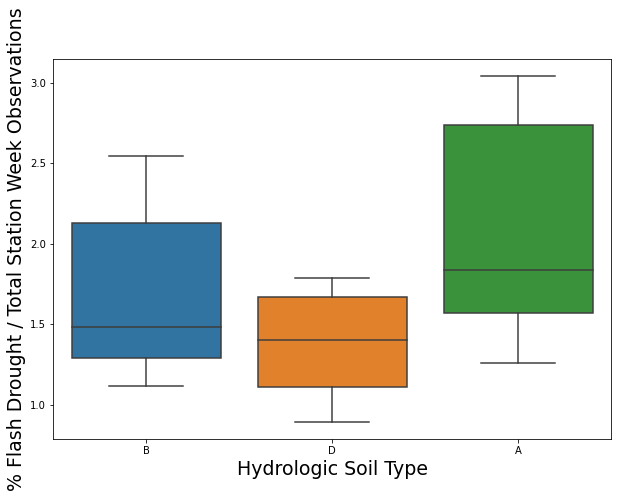

In [167]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='soilType', y='% Flash Droughts / Station Weeks', data=df)
ax.set_xlabel('Hydrologic Soil Type', fontsize=19)
ax.set_ylabel('% Flash Drought / Total Station Week Observations', fontsize=19)

Text(0, 0.5, '% Flash Drought / Total Station Week Observations')

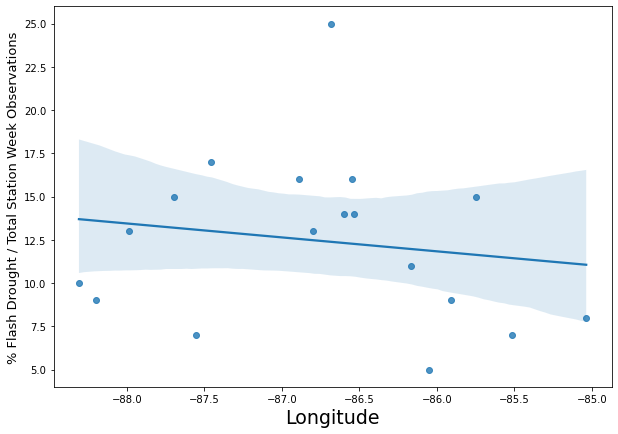

In [168]:
fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(x='longitude', y='numberDroughts', data=df)
ax.set_xlabel('Longitude', fontsize=19)
ax.set_ylabel('% Flash Drought / Total Station Week Observations', fontsize=13)

<AxesSubplot:xlabel='latitude', ylabel='numberDroughts'>

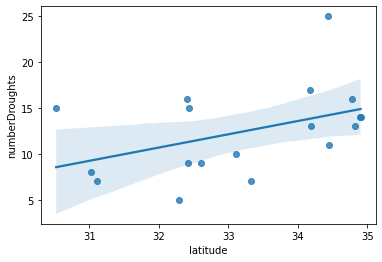

In [169]:
sns.regplot(x='latitude', y='numberDroughts', data=df)

<AxesSubplot:xlabel='longitude', ylabel='% Flash Droughts / Station Weeks'>

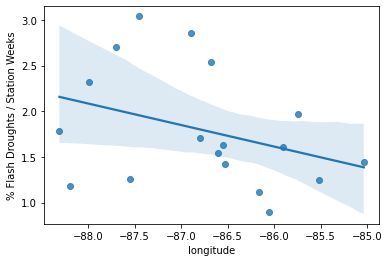

In [170]:
sns.regplot(x='longitude', y='% Flash Droughts / Station Weeks', data=df)

<AxesSubplot:xlabel='latitude', ylabel='% Flash Droughts / Station Weeks'>

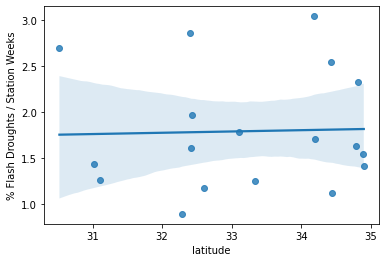

In [171]:
sns.regplot(x='latitude', y='% Flash Droughts / Station Weeks', data=df)

In [172]:
counts = {}
for c in fixed.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        numNegative = len(fixed[fixed[c]<0])
        counts[c]=str(numNegative)

In [173]:
df = pd.DataFrame.from_dict(counts, orient='index')

In [174]:
df

0
prior2esi       112
prior1esi        86
startesi        119
next1esi        119
next2esi        111
...             ...
prior2esi8_4wk  116
prior1esi8_4wk  114
startesi8_4wk   106
next1esi8_4wk   106
next2esi8_4wk   110

[80 rows x 1 columns]

In [175]:
df = df.reset_index()

In [176]:
df = df.rename(columns={0:'counts'})

In [177]:
df = df.sort_values('counts')

In [178]:
df.dtypes

index     object
counts    object
dtype: object

In [179]:
df['total']=len(fixed)

In [180]:
df['counts'] = df['counts'].astype(int)

In [181]:
df['percent']=df['counts']/df['total']*100.0

In [182]:
df.dtypes

index       object
counts       int64
total        int64
percent    float64
dtype: object

In [183]:
fixed.index.year.unique()

Int64Index([2002, 2005, 2006, 2007, 2008, 2009, 2010, 2014, 2016, 2020, 2004,
            2011, 2012, 2013, 2017, 2018, 2019, 2003, 2015],
           dtype='int64', name='Date')

In [184]:
df=df.sort_values('counts')

In [185]:
df

index  counts  total    percent
11   prior1esi_3wk      84    224  37.500000
1        prior1esi      86    224  38.392857
47   startesi4_2wk      86    224  38.392857
37   startesi2_4wk      86    224  38.392857
59   next2esi4_4wk      88    224  39.285714
..             ...     ...    ...        ...
50  prior2esi4_3wk     126    224  56.250000
14    next2esi_3wk     127    224  56.696429
55  prior2esi4_4wk     131    224  58.482143
8     next1esi_2wk     133    224  59.375000
23       next1esi2     133    224  59.375000

[80 rows x 4 columns]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

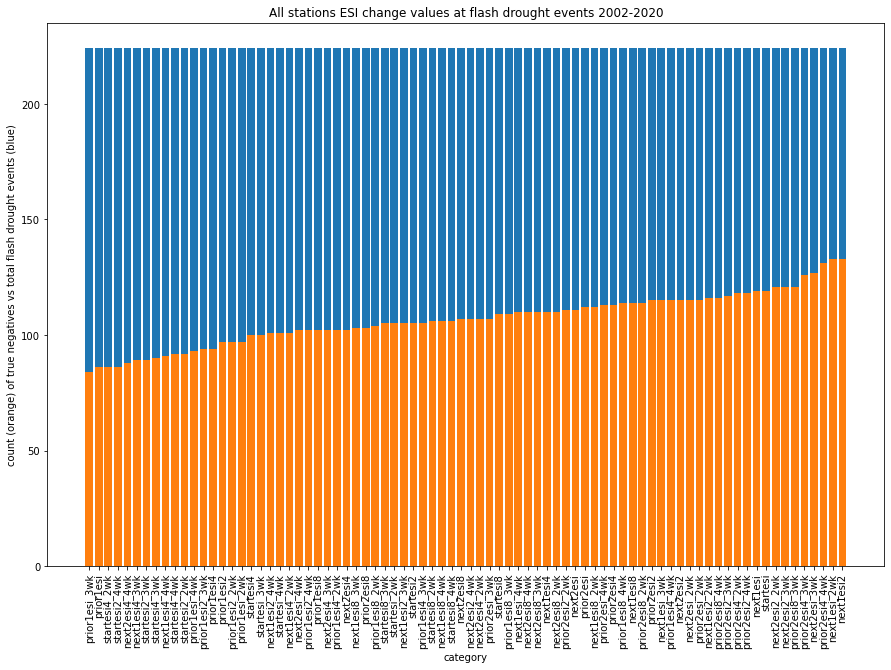

In [186]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(df['index'], df['total'])
ax.bar(df['index'],df['counts'])
ax.set_ylabel('count (orange) of true negatives vs total flash drought events (blue)')
ax.set_xlabel('category')
ax.set_title('All stations ESI change values at flash drought events 2002-2020')
plt.xticks(rotation=90)

In [187]:
goodmonths = fixed[(fixed.index.month>=5)&(fixed.index.month<=11)]

In [188]:
counts2 = {}
for c in goodmonths.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        numNegative = len(goodmonths[goodmonths[c]<0])
        print(numNegative)
        print(type(c), type(numNegative))
        counts2[c]=str(numNegative)

66
<class 'str'> <class 'int'>
41
<class 'str'> <class 'int'>
74
<class 'str'> <class 'int'>
68
<class 'str'> <class 'int'>
65
<class 'str'> <class 'int'>
67
<class 'str'> <class 'int'>
49
<class 'str'> <class 'int'>
57
<class 'str'> <class 'int'>
77
<class 'str'> <class 'int'>
65
<class 'str'> <class 'int'>
66
<class 'str'> <class 'int'>
45
<class 'str'> <class 'int'>
57
<class 'str'> <class 'int'>
62
<class 'str'> <class 'int'>
75
<class 'str'> <class 'int'>
66
<class 'str'> <class 'int'>
57
<class 'str'> <class 'int'>
56
<class 'str'> <class 'int'>
61
<class 'str'> <class 'int'>
57
<class 'str'> <class 'int'>
67
<class 'str'> <class 'int'>
49
<class 'str'> <class 'int'>
57
<class 'str'> <class 'int'>
77
<class 'str'> <class 'int'>
65
<class 'str'> <class 'int'>
70
<class 'str'> <class 'int'>
54
<class 'str'> <class 'int'>
49
<class 'str'> <class 'int'>
67
<class 'str'> <class 'int'>
68
<class 'str'> <class 'int'>
75
<class 'str'> <class 'int'>
54
<class 'str'> <class 'int'>
46
<clas

In [189]:
goodmonths_df = pd.DataFrame.from_dict(counts2, orient='index')
goodmonths_df = goodmonths_df.apply(pd.to_numeric)
goodmonths_df = goodmonths_df.reset_index()
goodmonths_df = goodmonths_df.rename(columns={0:'counts'})
goodmonths_df = goodmonths_df.sort_values('counts')
goodmonths_df['total']=len(goodmonths)

In [190]:
goodmonths_df['percent']=goodmonths_df['counts']/goodmonths_df['total']*100.0

In [191]:
goodmonths_df = goodmonths_df.sort_values('counts')

In [192]:
goodmonths_df

index  counts  total    percent
1        prior1esi      41    129  31.782946
11   prior1esi_3wk      45    129  34.883721
32   startesi2_3wk      46    129  35.658915
59   next2esi4_4wk      48    129  37.209302
6    prior1esi_2wk      49    129  37.984496
..             ...     ...    ...        ...
35  prior2esi2_4wk      75    129  58.139535
8     next1esi_2wk      77    129  59.689922
23       next1esi2      77    129  59.689922
50  prior2esi4_3wk      78    129  60.465116
55  prior2esi4_4wk      79    129  61.240310

[80 rows x 4 columns]

In [193]:
best_values = list(goodmonths_df.tail(10)['index'].unique())

In [194]:
best_values

['prior2esi8_3wk',
 'startesi',
 'prior2esi4_2wk',
 'next2esi_3wk',
 'prior2esi2_3wk',
 'prior2esi2_4wk',
 'next1esi_2wk',
 'next1esi2',
 'prior2esi4_3wk',
 'prior2esi4_4wk']

Text(0.5, 1.0, 'ESI Variables for All Flash Drought Events 2002-2020')

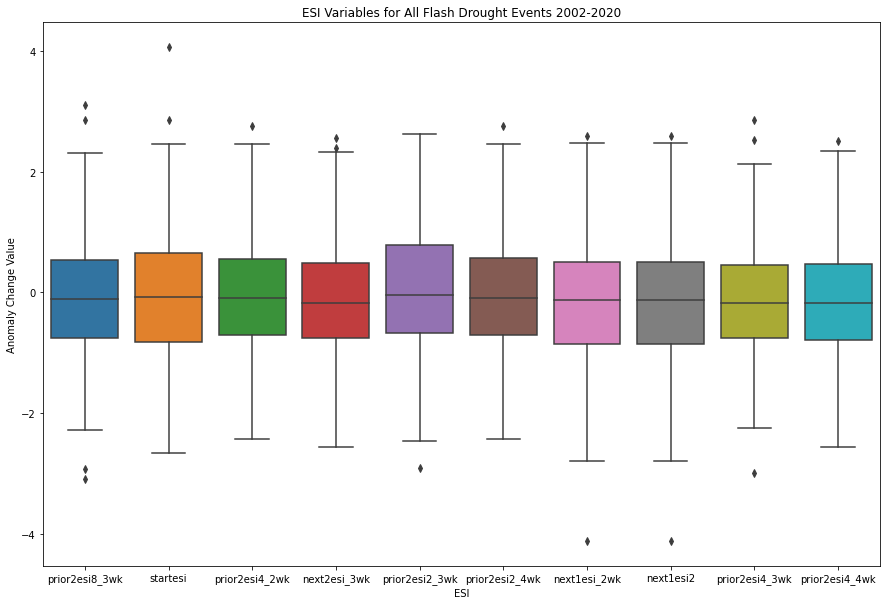

In [195]:
#plot all values for all of the top 10 most accurate columns from all flash drought events
column_names = []
values = []
for c in fixed.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        for i, r in fixed.iterrows():
            column_names.append(c)
            values.append(r[c])
data = pd.DataFrame()
data['ESI']=column_names
data['Anomaly Change Value']=values

new_store = {}
for i in best_values:
    new_data = data[data['ESI']==i]
    new_store[i]=new_data

best = pd.concat(new_store, axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='ESI', y="Anomaly Change Value", data=best)
ax.set_title('ESI Variables for All Flash Drought Events 2002-2020')

Text(0.5, 1.0, 'ESI Variables for All True Negative Flash Drought Events 2002-2020')

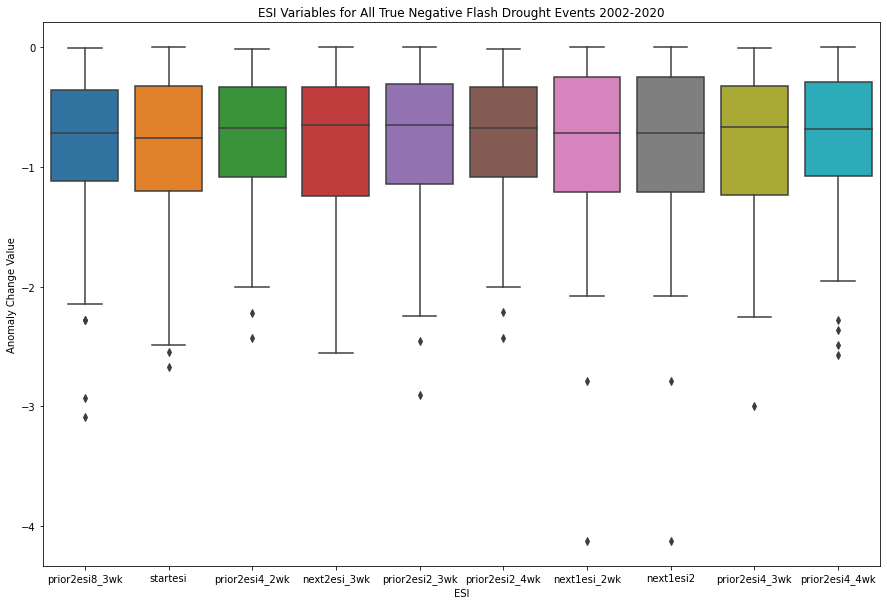

In [196]:
'Unnamed: 0'#plot all values for all of the top 10 most accurate columns with True Negative prediction 
#from all flash drought events
column_names = []
values = []
for c in fixed.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        for i, r in fixed.iterrows():
            if r[c]<0:
                column_names.append(c)
                values.append(r[c])
data = pd.DataFrame()
data['ESI']=column_names
data['Anomaly Change Value']=values

new_store = {}
for i in best_values:
    new_data = data[data['ESI']==i]
    new_store[i]=new_data

best = pd.concat(new_store, axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='ESI', y="Anomaly Change Value", data=best)
ax.set_title('ESI Variables for All True Negative Flash Drought Events 2002-2020')

Text(0.5, 1.0, 'ESI Variables for All May-October Flash Drought Events 2002-2020')

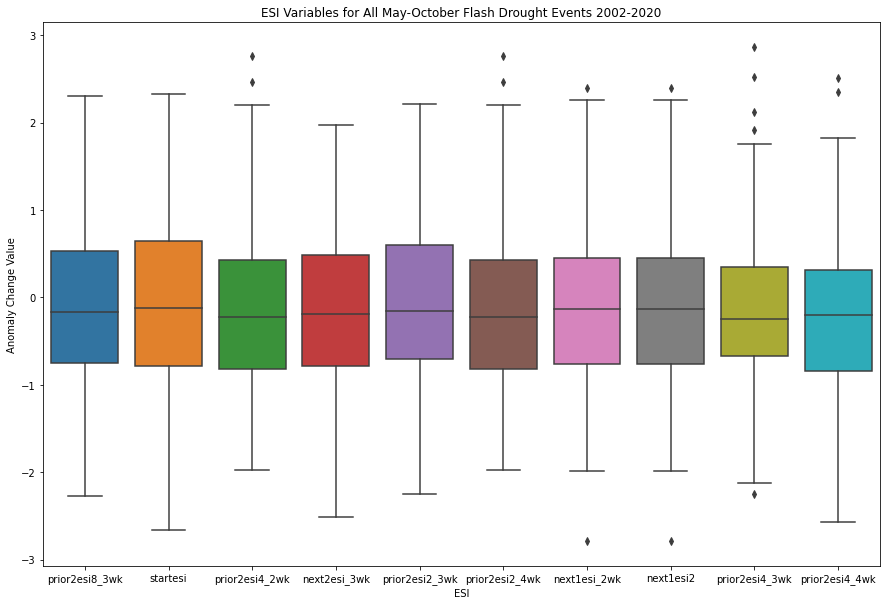

In [197]:
#plot all values for the good months May - October 
column_names = []
values = []
for c in goodmonths.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        for i, r in goodmonths.iterrows():
            column_names.append(c)
            values.append(r[c])
data = pd.DataFrame()
data['ESI']=column_names
data['Anomaly Change Value']=values

new_store = {}
for i in best_values:
    new_data = data[data['ESI']==i]
    new_store[i]=new_data

best = pd.concat(new_store, axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='ESI', y="Anomaly Change Value", data=best)
ax.set_title('ESI Variables for All May-October Flash Drought Events 2002-2020')

Text(0.5, 1.0, 'Top 10 ESI Variables for May-October True Flash Drought Detection 2002-2020')

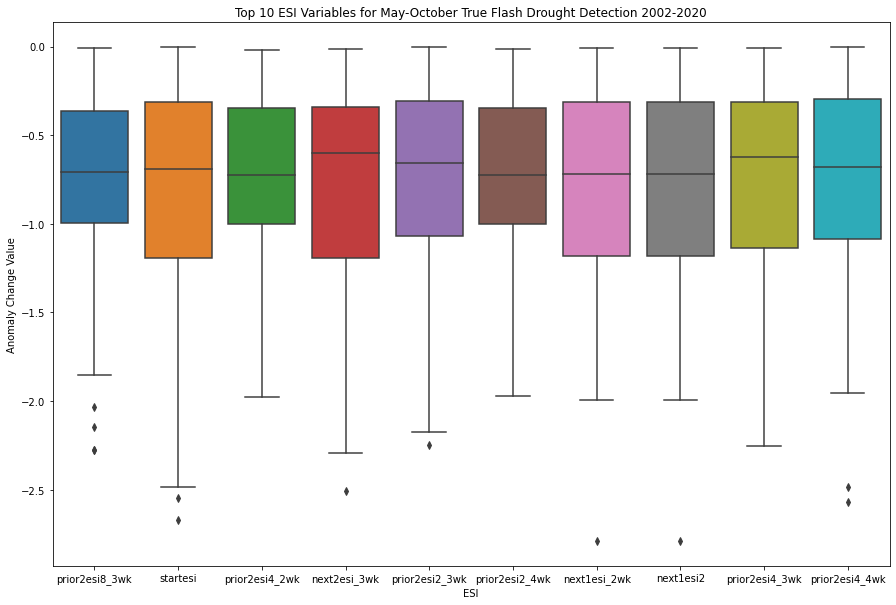

In [198]:
#plot all values for the good months May - October for True Negative predictions
column_names = []
values = []
for c in goodmonths.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        for i, r in goodmonths.iterrows():
            if r[c]<0:
                column_names.append(c)
                values.append(r[c])
data = pd.DataFrame()
data['ESI']=column_names
data['Anomaly Change Value']=values

new_store = {}
for i in best_values:
    new_data = data[data['ESI']==i]
    new_store[i]=new_data

best = pd.concat(new_store, axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='ESI', y="Anomaly Change Value", data=best)
ax.set_title('Top 10 ESI Variables for May-October True Flash Drought Detection 2002-2020')

In [199]:
goodmonths

station  prior2esi  prior1esi  startesi  next1esi  next2esi  \
Date                                                                           
2002-05-21  2053:AL:SCAN   1.683629   1.073794 -0.693332 -0.331371  0.355617   
2005-07-23  2053:AL:SCAN   0.478733  -1.047085  0.516489  0.335098 -0.153263   
2006-07-09  2053:AL:SCAN   1.784584  -1.321224 -0.575961  1.157513 -0.572678   
2006-11-12  2053:AL:SCAN  -0.549696   0.184896  0.432770  0.441798 -1.338460   
2009-05-21  2053:AL:SCAN  -0.719596   0.711012 -0.562829  0.455752 -0.145055   
...                  ...        ...        ...       ...       ...       ...   
2014-07-30  2181:AL:SCAN   1.538408   0.733387 -0.612182 -0.684101  0.843198   
2014-11-26  2181:AL:SCAN  -0.721993   1.290947  0.391581 -0.665541 -0.496185   
2015-08-13  2181:AL:SCAN  -0.046115   0.361422 -1.018173 -1.019720  0.817678   
2017-07-30  2181:AL:SCAN   0.149533  -0.093288 -1.643012  0.094628  2.105249   
2017-10-22  2181:AL:SCAN  -2.448034   2.638836  0.064469  0.443393 -0.006676   

            prior2esi_2wk  prior1esi_2wk  startesi_2wk  next1esi_2wk  ...  \
Date                                                                  ...   
2002-05-21       0.779637       2.529513      0.348007     -0.941613  ...   
2005-07-23       0.039161      -0.522788     -0.488137      0.780391  ...   
2006-07-09       1.736306       0.424088     -1.742352      0.532561  ...   
2006-11-12       0.235768      -0.335974      0.565705      0.801483  ...   
2009-05-21       0.088124      -0.009049      0.134828     -0.099443  ...   
...                   ...            ...           ...           ...  ...   
2014-07-30      -1.103881       2.069885      0.111110     -1.179950  ...   
2014-11-26      -0.980621       0.518924      1.533177     -0.248809  ...   
2015-08-13       0.415385       0.287899     -0.597459     -1.855414  ...   
2017-07-30      -0.057228       0.051945     -1.580721     -1.409565  ...   
2017-10-22      -2.805572       0.174500      2.462908      0.463281  ...   

            prior1esi8-endsum_3wk  startesi8-endsum_3wk  \
Date                                                      
2002-05-21               9.929910              8.252054   
2005-07-23               0.203213              0.584236   
2006-07-09               0.252805             -1.232753   
2006-11-12               0.728969              0.934002   
2009-05-21              -1.284734             -1.114016   
...                           ...                   ...   
2014-07-30              -5.769210             -4.492823   
2014-11-26              -0.822829              0.738823   
2015-08-13              -6.008899             -5.321946   
2017-07-30              -6.095486             -6.871651   
2017-10-22               1.925247              2.332339   

            prior2esi8-endsum_4wk  prior1esi8-endsum_4wk  \
Date                                                       
2002-05-21              13.017498              11.902030   
2005-07-23              -0.611574              -0.034651   
2006-07-09               2.602748               1.011078   
2006-11-12              -0.180324               0.304984   
2009-05-21              -0.529584              -1.359316   
...                           ...                    ...   
2014-07-30              -7.217099              -6.327445   
2014-11-26              -3.337207              -1.476668   
2015-08-13              -6.282141              -5.901367   
2017-07-30              -3.884925              -5.203131   
2017-10-22               0.404537               1.568979   

            startesi8-endsum_4wk  4in_pr_start  4in_pr_end  4in_prDelta  \
Date                                                                      
2002-05-21             10.261992     69.344898    6.585255   -62.759644   
2005-07-23              0.552230     71.536179    7.658069   -63.878110   
2006-07-09             -0.131338     97.808719   10.625428   -87.183291   
2006-11-12              0.954744     66.503081   1

In [200]:
goodmonths_df

index  counts  total    percent
1        prior1esi      41    129  31.782946
11   prior1esi_3wk      45    129  34.883721
32   startesi2_3wk      46    129  35.658915
59   next2esi4_4wk      48    129  37.209302
6    prior1esi_2wk      49    129  37.984496
..             ...     ...    ...        ...
35  prior2esi2_4wk      75    129  58.139535
8     next1esi_2wk      77    129  59.689922
23       next1esi2      77    129  59.689922
50  prior2esi4_3wk      78    129  60.465116
55  prior2esi4_4wk      79    129  61.240310

[80 rows x 4 columns]

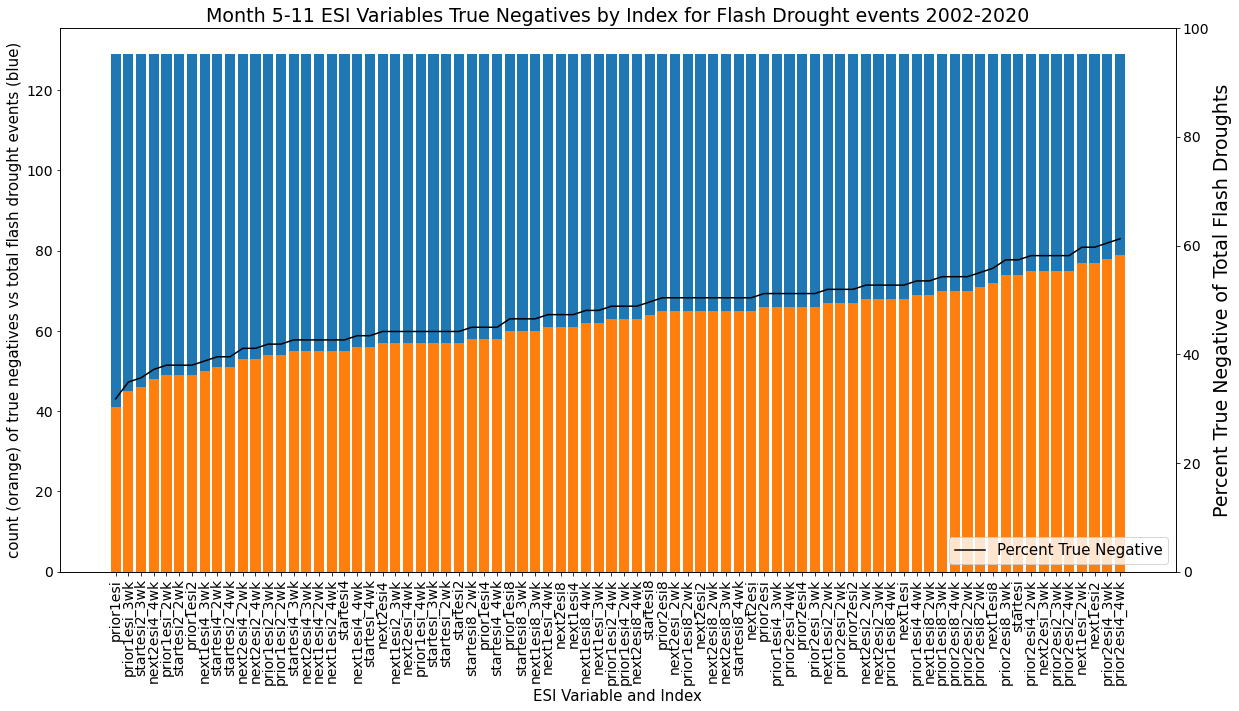

In [327]:
#plot of good months accuracy 
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(goodmonths_df['index'], goodmonths_df['total'])
ax.bar(goodmonths_df['index'],goodmonths_df['counts'])
ax.set_ylabel('count (orange) of true negatives vs total flash drought events (blue)', fontsize=15)
ax.set_xlabel('ESI Variable and Index', fontsize=15)
ax.set_title('Month 5-11 ESI Variables True Negatives by Index for Flash Drought events 2002-2020', fontsize=19)
plt.xticks(rotation=90)
ax2 = ax.twinx()
ax2.set_ylim(0.0, 100.0)
ax2.set_ylabel('Percent True Negative of Total Flash Droughts', fontsize=19)
ax2.plot(goodmonths_df['index'], goodmonths_df['percent'], color='black', label='Percent True Negative')
ax2.legend(prop={'size': 15}, loc='lower right')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=14)

In [202]:
from datasets import SCAN_SIG_READ

In [203]:
SCAN_SIG_READ = SCAN_SIG_READ.set_index('Month')

In [204]:
SCAN_SIG_READ

Unnamed: 0       station  correlation  signifigance soil resample list  \
Month                                                                           
4               1  2057:AL:SCAN     0.258694      0.022201    D            1w   
4               2  2057:AL:SCAN     0.235643      0.037812    D            1w   
4               5  2078:AL:SCAN     0.427306      0.000737    D            1w   
4               6  2078:AL:SCAN     0.422937      0.000846    B            1w   
4               8  2078:AL:SCAN     0.341136      0.008191    D            1w   
...           ...           ...          ...           ...  ...           ...   
3             967  2173:AL:SCAN     0.408104      0.034581    D            1w   
3            1002  2056:AL:SCAN     0.354088      0.024986    D            1w   
3            1010  2175:AL:SCAN     0.593118      0.019778    B            1w   
3            1011  2175:AL:SCAN     0.596247      0.018978    B            1w   
3            1013  2175:AL:SCAN     0.551667      0.033011    B            1w   

            depth  observations  
Month                            
4       SMS-4.0in            78  
4       SMS-8.0in            78  
4       SMS-2.0in            59  
4       SMS-4.0in            59  
4      SMS-20.0in            59  
...           ...           ...  
3       SMS-8.0in            27  
3       SMS-8.0in            40  
3       SMS-2.0in            15  
3       SMS-4.0in            15  
3      SMS-20.0in            15  

[340 rows x 8 columns]

In [205]:
store = {}
for s in SCAN_SIG_READ['station'].unique():
    sigFrame=SCAN_SIG_READ[(SCAN_SIG_READ['station']==s)&(SCAN_SIG_READ['depth']=='SMS-4.0in')]
    for m in sigFrame.index.unique():
        flashFrame=goodmonths[(goodmonths['station']==s)&(goodmonths.index.month==m)]
        if flashFrame.empty:
            pass
        else:
            store[s+":"+str(m)]=flashFrame

In [206]:
flashFrame = pd.concat(store, axis=0)

In [207]:
flashFrame

station  prior2esi  prior1esi  startesi  \
                Date                                                       
2057:AL:SCAN:9  2011-09-24  2057:AL:SCAN   1.258245   0.700668  0.647101   
2057:AL:SCAN:10 2003-10-08  2057:AL:SCAN   0.801307  -0.002189 -0.321152   
                2005-10-01  2057:AL:SCAN   0.048943   0.810235 -1.235839   
2078:AL:SCAN:10 2005-10-01  2078:AL:SCAN   0.548452   0.298535 -0.107479   
2078:AL:SCAN:11 2015-11-12  2078:AL:SCAN   0.402060   0.618008 -0.387321   
2113:AL:SCAN:9  2010-09-03  2113:AL:SCAN  -0.854031   0.426411  0.656594   
                2011-09-17  2113:AL:SCAN   0.279718   1.002259  0.691707   
                2012-09-23  2113:AL:SCAN   0.367109   0.938276 -0.230586   
                2016-09-02  2113:AL:SCAN   1.839501   0.473228 -1.166144   
2113:AL:SCAN:10 2006-10-29  2113:AL:SCAN  -0.217322   1.876954 -1.373699   
2174:AL:SCAN:9  2016-09-30  2174:AL:SCAN  -0.444759  -0.357528 -0.697314   
2174:AL:SCAN:10 2011-10-01  2174:AL:SCAN  -0.122419   0.486537 -1.760702   
2173:AL:SCAN:9  2011-09-24  2173:AL:SCAN   0.785588   0.733445  0.923277   
2180:AL:SCAN:11 2019-11-05  2180:AL:SCAN   0.545355   1.060108  0.718025   
2056:AL:SCAN:8  2004-08-26  2056:AL:SCAN  -1.649776   0.855740  1.088757   
                2010-08-27  2056:AL:SCAN  -0.895393  -0.630424  1.490887   
                2018-08-13  2056:AL:SCAN  -2.076064   2.656751 -1.970077   
2056:AL:SCAN:9  2007-09-24  2056:AL:SCAN   0.223711  -1.301419  1.282029   
                2011-09-24  2056:AL:SCAN  -0.345972   1.878209  0.784822   
                2019-09-03  2056:AL:SCAN  -1.073078   0.621165 -0.402083   
2056:AL:SCAN:10 2005-10-01  2056:AL:SCAN  -0.086458   0.802747 -0.929683   
                2013-10-01  2056:AL:SCAN  -0.393511   0.018750 -0.084900   
                2020-10-14  2056:AL:SCAN   0.339051   0.812878 -0.082562   
2056:AL:SCAN:11 2007-11-05  2056:AL:SCAN  -1.475987   0.798850  0.936011   
2175:AL:SCAN:10 2011-10-08  2175:AL:SCAN  -0.029954  -0.214070 -0.156483   
2053:AL:SCAN:5  2002-05-21  2053:AL:SCAN   1.683629   1.073794 -0.693332   
                2009-05-21  2053:AL:SCAN  -0.719596   0.711012 -0.562829   
2053:AL:SCAN:6  2014-06-18  2053:AL:SCAN   1.246157   0.739739 -0.317417   
                2020-06-03  2053:AL:SCAN  -0.480751   0.852185 -0.619462   
2053:AL:SCAN:7  2005-07-23  2053:AL:SCAN   0.478733  -1.047085  0.516489   
                2006-07-09  2053:AL:SCAN   1.784584  -1.321224 -0.575961   
2053:AL:SCAN:10 2020-10-14  2053:AL:SCAN   0.141395   0.269436 -0.140951   
2053:AL:SCAN:11 2006-11-12  2053:AL:SCAN  -0.549696   0.184896  0.432770   
2114:AL:SCAN:5  2009-05-21  2114:AL:SCAN  -1.834171   2.663488 -0.006292   
                2014-05-07  2114:AL:SCAN  -1.368088  -1.159782  0.965800   
2114:AL:SCAN:9  2008-09-09  2114:AL:SCAN  -0.337844  -0.387317  0.802627   
2114:AL:SCAN:10 2011-10-01  2114:AL:SCAN   1.245276   0.668965 -1.675338   
2114:AL:SCAN:11 2010-11-12  2114:AL:SCAN   0.004124   0.499717  0.924139   
2176:AL:SCAN:5  2014-05-21  2176:AL:SCAN   0.204391   1.332600 -0.337934   
2176:AL:SCAN:7  2010-07-09  2176:AL:SCAN  -0.636854   0.074575 -0.226907   
2176:AL:SCAN:9  2011-09-17  2176:AL:SCAN  -0.635146   1.493162 -0.133815   
                2016-09-30  2176:AL:SCAN   0.982437   0.034434  0.191581   
2176:AL:SCAN:10 2020-10-14  2176:AL:SCAN   0.203537   0.247948 -2.549086   
2115:AL:SCAN:5  2017-05-28  2115:AL:SCAN   1.236772  -0.969545  1.577258   
2115:AL:SCAN:11 2019-11-05  2115:AL:SCAN   0.702089   0.469394  0.764539   
2055:AL:SCAN:7  2005-07-23  2055:AL:SCAN   1.274499   0.605753 -0.674771   
2055:AL:SCAN:10 2007-10-15  2055:AL:SCAN   0.147539   0.003057  1.119284   
                2014-10-22  2055:AL:SCAN  -0.324711   0.090571  0.928567   
2182:AL:SCAN:10 2014-10-22  2182:AL:SCAN   0.588633  -0.130078 -0.888192   
                2016-10-07  2182:AL:SCAN  -1.486330   0.941684 -0.307392   
                2017-10-22  2182:AL:SCAN  -0.759738   0.367188 -0.993004   
2178:

In [208]:
flashFrame.index = flashFrame.index.get_level_values('Date')

In [209]:
counts3 = {}
for c in flashFrame.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        numNegative = len(flashFrame[flashFrame[c]<0])
        counts3[c]=str(numNegative)
        numNegative = len(flashFrame[flashFrame[c]<0])
        counts3[c]=str(numNegative)
df = pd.DataFrame.from_dict(counts3, orient='index')
df = df.apply(pd.to_numeric)
df = df.reset_index()
df = df.rename(columns={0:'counts'})
df = df.sort_values('counts')
df['percent']=df['counts']/len(flashFrame)*100.0

In [210]:
df['total']=len(flashFrame)

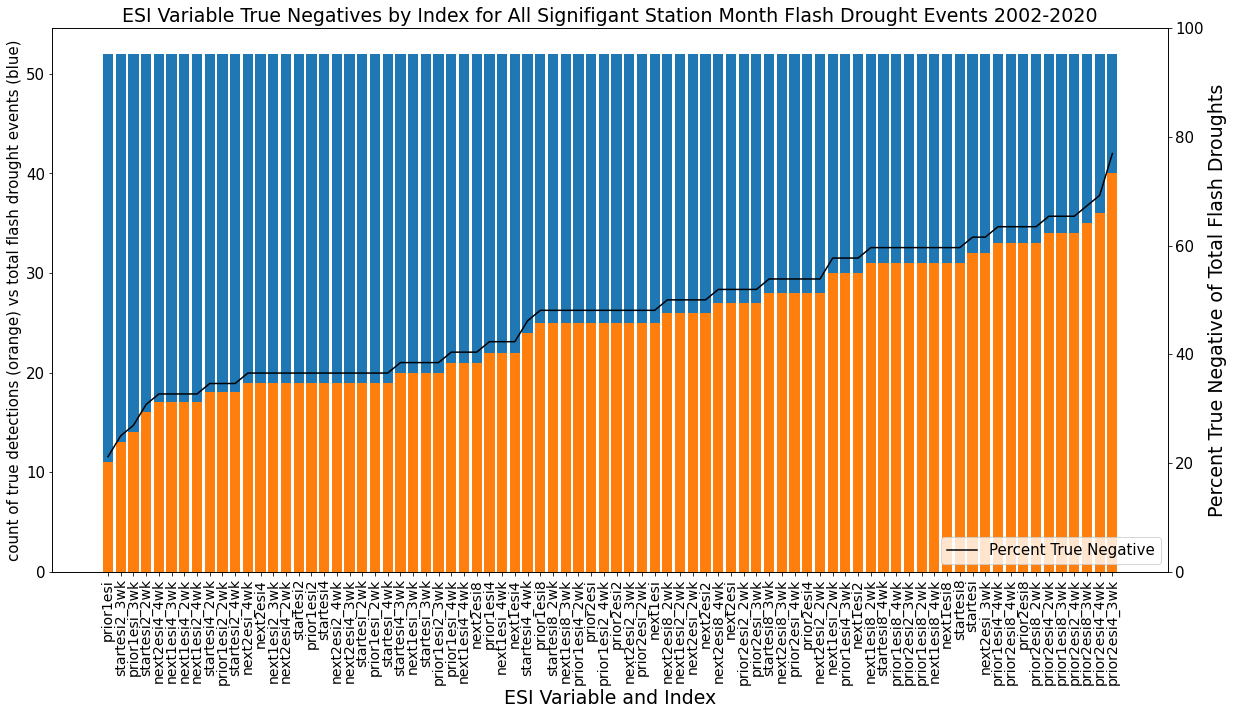

In [329]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df['index'], df['total'])
ax.bar(df['index'],df['counts'])
ax.set_ylabel('count of true detections (orange) vs total flash drought events (blue)', fontsize=15)
ax.set_xlabel('ESI Variable and Index', fontsize=19)
ax.set_title('ESI Variable True Negatives by Index for All Signifigant Station Month Flash Drought Events 2002-2020', fontsize=19)
plt.xticks(rotation=90)
ax2 = ax.twinx()
ax2.set_ylim(0.0, 100.0)
ax2.set_ylabel('Percent True Negative of Total Flash Droughts', fontsize=19)
ax2.plot(df['index'], df['percent'], color='black', label='Percent True Negative')
ax2.legend(prop={'size': 15}, loc='lower right')
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=15)

In [319]:
df.tail(10)

index  counts    percent  total
56  prior1esi4_4wk      33  63.461538     52
75  prior2esi8_4wk      33  63.461538     52
60      prior2esi8      33  63.461538     52
65  prior2esi8_2wk      33  63.461538     52
45  prior2esi4_2wk      34  65.384615     52
71  prior1esi8_3wk      34  65.384615     52
35  prior2esi2_4wk      34  65.384615     52
70  prior2esi8_3wk      35  67.307692     52
55  prior2esi4_4wk      36  69.230769     52
50  prior2esi4_3wk      40  76.923077     52

In [213]:
best_values = list(df.tail(10)['index'].unique())

In [214]:
best_values

['prior1esi4_4wk',
 'prior2esi8_4wk',
 'prior2esi8',
 'prior2esi8_2wk',
 'prior2esi4_2wk',
 'prior1esi8_3wk',
 'prior2esi2_4wk',
 'prior2esi8_3wk',
 'prior2esi4_4wk',
 'prior2esi4_3wk']

Text(0.5, 1.0, 'Top 10 Accurate ESI Variables for True Flash Drought Dections at Signifigant Station Months 2002-2020')

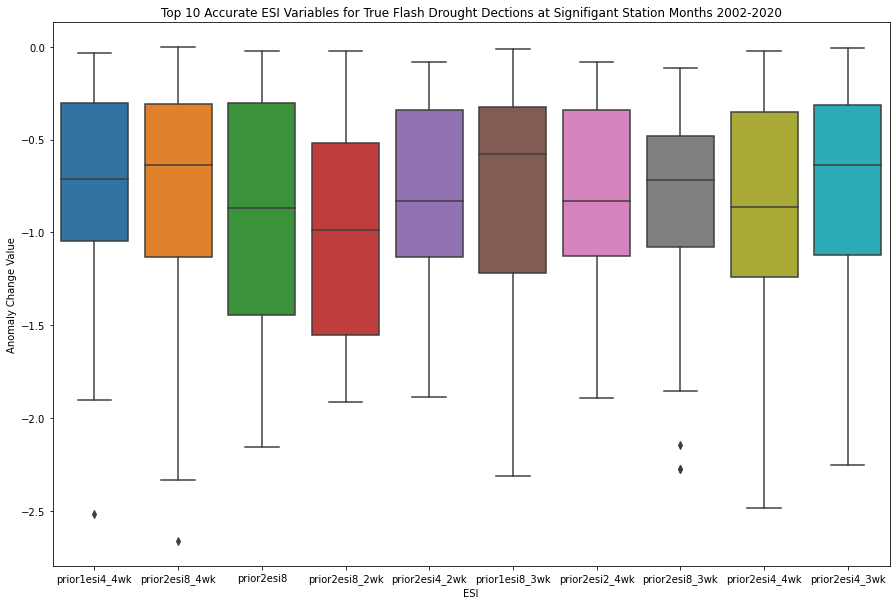

In [215]:
#plot the top 10 true negative detections during the signifigant station months
column_names = []
negs = []
for c in flashFrame.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        for i, r in flashFrame.iterrows():
            if r[c]<0:
                column_names.append(c)
                negs.append(r[c])
data = pd.DataFrame()
data['ESI']=column_names
data['Anomaly Change Value']=negs

new_store = {}
for i in best_values:
    new_data = data[data['ESI']==i]
    new_store[i]=new_data

best = pd.concat(new_store, axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='ESI', y="Anomaly Change Value", data=best)
ax.set_title('Top 10 Accurate ESI Variables for True Flash Drought Dections at Signifigant Station Months 2002-2020')

In [216]:
data

ESI  Anomaly Change Value
0         prior2esi             -0.854031
1         prior2esi             -0.217322
2         prior2esi             -0.444759
3         prior2esi             -0.122419
4         prior2esi             -1.649776
...             ...                   ...
1981  next2esi8_4wk             -0.795229
1982  next2esi8_4wk             -0.788648
1983  next2esi8_4wk             -1.630626
1984  next2esi8_4wk             -0.236417
1985  next2esi8_4wk             -0.853393

[1986 rows x 2 columns]

In [217]:
best

ESI  Anomaly Change Value
0    prior1esi4_4wk             -0.680299
1    prior1esi4_4wk             -1.106032
2    prior1esi4_4wk             -0.033652
3    prior1esi4_4wk             -1.044106
4    prior1esi4_4wk             -0.271302
..              ...                   ...
340  prior2esi4_3wk             -0.844019
341  prior2esi4_3wk             -1.915793
342  prior2esi4_3wk             -0.184732
343  prior2esi4_3wk             -0.659000
344  prior2esi4_3wk             -0.016290

[345 rows x 2 columns]

Text(0.5, 1.0, 'Top 10 Accurate ESI Variables for All Flash Droughts at Signifigant Station Months 2002-2020')

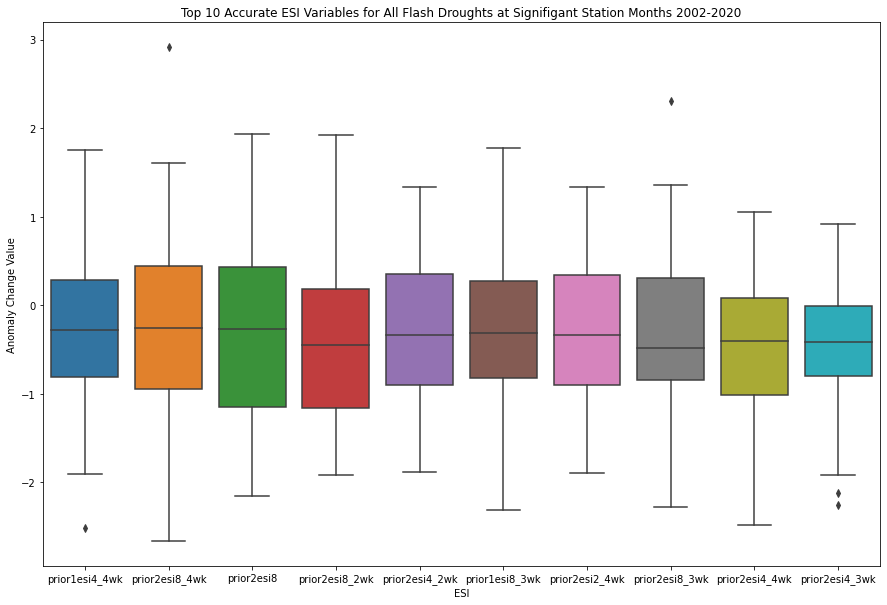

In [218]:
#plot all the values for the signifigant station months
column_names = []
values = []
for c in flashFrame.columns:
    if type(c) == int:
        pass
    elif c == 'station':
        pass
    elif c == 'USDM_cat':
        pass
    elif c == '4in_pr_end':
        pass
    elif c == '4in_pr_start':
        pass
    elif c == 'drought_duration':
        pass
    elif c == '4in_prDelta':
        pass
    elif 'endsum' in c:
        pass
    else:
        for i, r in flashFrame.iterrows():
            column_names.append(c)
            values.append(r[c])
data = pd.DataFrame()
data['ESI']=column_names
data['Anomaly Change Value']=values

new_store = {}
for i in best_values:
    new_data = data[data['ESI']==i]
    new_store[i]=new_data

best = pd.concat(new_store, axis=0, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='ESI', y="Anomaly Change Value", data=best)
ax.set_title('Top 10 Accurate ESI Variables for All Flash Droughts at Signifigant Station Months 2002-2020')

In [219]:
flashFrame['prior2esi4_3wk'].describe()

count    52.000000
mean     -0.478040
std       0.760255
min      -2.254112
25%      -0.800688
50%      -0.415521
75%      -0.013931
max       0.913057
Name: prior2esi4_3wk, dtype: float64

In [220]:
case1 = flashFrame[flashFrame['prior2esi4_3wk']==flashFrame['prior2esi4_3wk'].min()] #representing flash drought where minimum esi4_3wk occured 2 weeks prior
case2 = goodmonths[(goodmonths['USDM_cat']==4)&(goodmonths['drought_duration']==7)&(goodmonths['station']=='2180:AL:SCAN')] #representing long flash drought event that went to D4 in growing season

In [221]:
case1

station  prior2esi  prior1esi  startesi  next1esi  next2esi  \
Date                                                                           
2016-09-30  2174:AL:SCAN  -0.444759  -0.357528 -0.697314  1.048969 -1.073654   

            prior2esi_2wk  prior1esi_2wk  startesi_2wk  next1esi_2wk  ...  \
Date                                                                  ...   
2016-09-30       0.414076      -0.717457     -0.944811       0.32134  ...   

            prior1esi8-endsum_3wk  startesi8-endsum_3wk  \
Date                                                      
2016-09-30             -16.497612            -16.004114   

            prior2esi8-endsum_4wk  prior1esi8-endsum_4wk  \
Date                                                       
2016-09-30             -18.071677             -17.984986   

            startesi8-endsum_4wk  4in_pr_start  4in_pr_end  4in_prDelta  \
Date                                                                      
2016-09-30             -17.10678     38.027848    3.583657   -34.444191   

            drought_duration  USDM_cat  
Date                                    
2016-09-30               7.0       3.0  

[1 rows x 134 columns]

In [222]:
case2

station  prior2esi  prior1esi  startesi  next1esi  next2esi  \
Date                                                                           
2016-09-16  2180:AL:SCAN  -0.838452   0.391417  0.786442 -0.861258  1.100832   

            prior2esi_2wk  prior1esi_2wk  startesi_2wk  next1esi_2wk  ...  \
Date                                                                  ...   
2016-09-16       0.240025      -0.399915      1.036172     -0.070947  ...   

            prior1esi8-endsum_3wk  startesi8-endsum_3wk  \
Date                                                      
2016-09-16              -6.649607             -6.187898   

            prior2esi8-endsum_4wk  prior1esi8-endsum_4wk  \
Date                                                       
2016-09-16              -5.710606               -5.67193   

            startesi8-endsum_4wk  4in_pr_start  4in_pr_end  4in_prDelta  \
Date                                                                      
2016-09-16             -5.206367     93.814198     2.85323   -90.960968   

            drought_duration  USDM_cat  
Date                                    
2016-09-16               7.0       4.0  

[1 rows x 134 columns]

In [223]:
location = testFrame[(testFrame['station']==case1['station'].item())&(testFrame['Date']==case1.index.item())].index.item()

In [224]:
location2 = testFrame[(testFrame['station']==case2['station'].item())&(testFrame['Date']==case2.index.item())].index.item()

In [225]:
location2

9133

In [226]:
caseFrame = testFrame[(testFrame.index>=location-10)&(testFrame.index<=(location+case1['drought_duration'].item()+3))]

In [227]:
caseFrame2 = testFrame[(testFrame.index>=location2-10)&(testFrame.index<=(location2+case1['drought_duration'].item()+3))]

In [228]:
caseFrame = caseFrame.set_index('Date')

In [229]:
caseFrame2 = caseFrame2.set_index('Date')

In [230]:
startFlash = testFrame[testFrame.index==location]['Date'].item()

In [231]:
startFlash2 = testFrame[testFrame.index==location2]['Date'].item()

In [232]:
endFlash = testFrame[testFrame.index==location+case1['drought_duration'].item()]['Date'].item()

In [233]:
endFlash2 = testFrame[testFrame.index==location2+case2['drought_duration'].item()]['Date'].item()

In [234]:
endFlash

Timestamp('2016-11-25 00:00:00')

In [235]:
startFlash

Timestamp('2016-09-30 00:00:00')

In [236]:
endFlash2

Timestamp('2016-11-04 00:00:00')

In [237]:
startFlash2

Timestamp('2016-09-16 00:00:00')

In [238]:
caseFrame

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2016-06-24 -0.311  2174:AL:SCAN      25      25 -0.343077 -0.096882  0.189697   
2016-07-01 -0.507  2174:AL:SCAN      26      26 -0.893587 -0.522352 -0.485091   
2016-07-15  1.731  2174:AL:SCAN      28      28 -0.561866 -0.332297 -0.267630   
2016-07-22  2.007  2174:AL:SCAN      29      29  0.214940  0.269163  0.534090   
2016-08-05  1.101  2174:AL:SCAN      31      31  0.247206  0.267168  0.596647   
2016-08-12  1.064  2174:AL:SCAN      32      32 -0.005983  0.064068 -0.297137   
2016-09-02 -0.872  2174:AL:SCAN      35      35 -0.772314 -0.510082 -0.802449   
2016-09-09  0.217  2174:AL:SCAN      36      36 -0.902131 -0.770897 -1.170523   
2016-09-16 -0.312  2174:AL:SCAN      37      37 -0.845050 -0.552366 -0.828741   
2016-09-23 -0.736  2174:AL:SCAN      38      38 -0.958681 -0.494896 -0.920816   
2016-09-30 -1.569  2174:AL:SCAN      39      39 -0.914790 -0.285497 -0.631920   
2016-10-07 -0.300  2174:AL:SCAN      40      40 -0.797164 -0.435737 -0.919556   
2016-10-14 -1.586  2174:AL:SCAN      41      41 -1.118441 -0.789109 -1.390752   
2016-10-21 -1.168  2174:AL:SCAN      42      42 -1.126865 -0.785786 -1.437777   
2016-10-28 -1.807  2174:AL:SCAN      43      43 -1.268061 -1.016440 -1.601410   
2016-11-11 -1.834  2174:AL:SCAN      45      45 -1.428441 -1.318202 -1.854035   
2016-11-18 -1.340  2174:AL:SCAN      46      46 -1.530953 -1.404314 -1.870509   
2016-11-25 -1.542  2174:AL:SCAN      47      47 -1.665912 -1.583182 -2.052342   
2016-12-02 -0.529  2174:AL:SCAN      48      48 -1.884817 -1.748277 -1.862358   
2016-12-09 -0.950  2174:AL:SCAN      49      49 -0.321599 -0.049946  0.177549   
2016-12-16 -0.364  2174:AL:SCAN      50      50 -0.764482 -0.552570 -0.364561   

            20inANOM  40inANOM     2in_pr  ...  esi2_change_anom_3wk  \
Date                                       ...                         
2016-06-24  0.409823  0.317007  36.613097  ...              1.598751   
2016-07-01  0.127583  0.115841  19.558325  ...             -0.072928   
2016-07-15  0.647772  0.372793  29.659998  ...             -0.374710   
2016-07-22  0.694524  0.894014  55.373346  ...              1.359303   
2016-08-05  0.647452  0.473238  56.466601  ...              1.939617   
2016-08-12  0.567393  0.560375  47.600306  ...              0.462860   
2016-09-02  0.169060  0.015724  22.936482  ...             -1.756974   
2016-09-09  0.106477 -0.157760  19.317809  ...             -1.864330   
2016-09-16  0.252745 -0.101467  20.957691  ...             -1.120757   
2016-09-23  0.120251 -0.209202  17.809118  ...             -0.616137   
2016-09-30  0.260280  0.031900  19.055428  ...             -0.818974   
2016-10-07  0.252524  0.020227  22.335192  ...             -0.880320   
2016-10-14  0.214432 -0.195555  13.709413  ...             -0.417257   
2016-10-21  0.197820 -0.022987  13.479829  ...             -0.224809   
2016-10-28  0.101210  0.014608  10.145403  ...             -0.549843   
2016-11-11 -0.021404 -0.120025   7.204548  ...             -0.870920   
2016-11-18 -0.174888 -0.075340   5.859845  ...             -0.210461   
2016-11-25 -0.447239 -0.222933   3.990379  ...              0.043333   
2016-12-02 -0.886827  0.014401   2.219307  ...              0.774043   
2016-12-09  0.131794  0.506583  37.236252  ...              0.835884   
2016-12-16  0.150555  0.416142  23.198863  ...              0.773053   

            esi2_change_anom_4wk  esi4_change_anom  esi4_change_anom_2wk  \
Date                                                                       
2016-06-24              1.439975          0.432573              1.437015   
2016-07-01              0.700041          0.631854              0.697044   
2016-07-15              0.929150          0.784335              0.926165   
2016-07-22              0.861303          0.527685              0.858314   
2016-08-05              1.038788     

<AxesSubplot:xlabel='Date'>

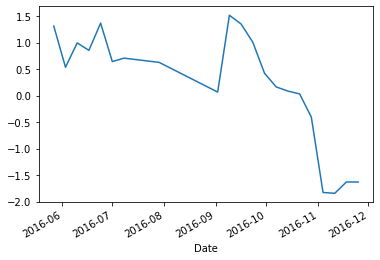

In [239]:
caseFrame2['4inANOM'].plot() #greater than 90 percentile fall in soil moisture at month 9

In [240]:
caseFrame2['esi8_change_anom_4wk_cumsum']=caseFrame2['esi8_change_anom_4wk'].cumsum()
caseFrame2['esi4_change_anom_4wk_cumsum']=caseFrame2['esi4_change_anom_4wk'].cumsum()
caseFrame2['esi2_change_anom_4wk_cumsum']=caseFrame2['esi2_change_anom_4wk'].cumsum()
caseFrame2['esi1_change_anom_4wk_cumsum']=caseFrame2['esi1_change_anom_4wk'].cumsum()
caseFrame2['esi8_change_anom_3wk_cumsum']=caseFrame2['esi8_change_anom_3wk'].cumsum()
caseFrame2['esi4_change_anom_3wk_cumsum']=caseFrame2['esi4_change_anom_3wk'].cumsum()
caseFrame2['esi2_change_anom_3wk_cumsum']=caseFrame2['esi2_change_anom_3wk'].cumsum()
caseFrame2['esi1_change_anom_3wk_cumsum']=caseFrame2['esi1_change_anom_3wk'].cumsum()
caseFrame2['esi8_change_anom_2wk_cumsum']=caseFrame2['esi8_change_anom_2wk'].cumsum()
caseFrame2['esi4_change_anom_2wk_cumsum']=caseFrame2['esi4_change_anom_2wk'].cumsum()
caseFrame2['esi2_change_anom_2wk_cumsum']=caseFrame2['esi2_change_anom_2wk'].cumsum()
caseFrame2['esi1_change_anom_2wk_cumsum']=caseFrame2['esi1_change_anom_2wk'].cumsum()

<AxesSubplot:xlabel='Date'>

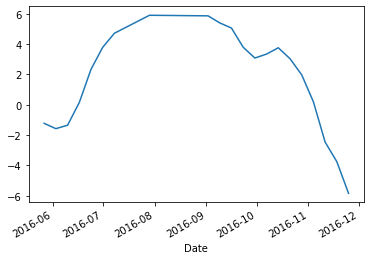

In [241]:
caseFrame2['esi8_change_anom_4wk_cumsum'].plot()

Text(0.5, 1.0, '2174:AL:SCAN D3 Flash Drought Event (red)')

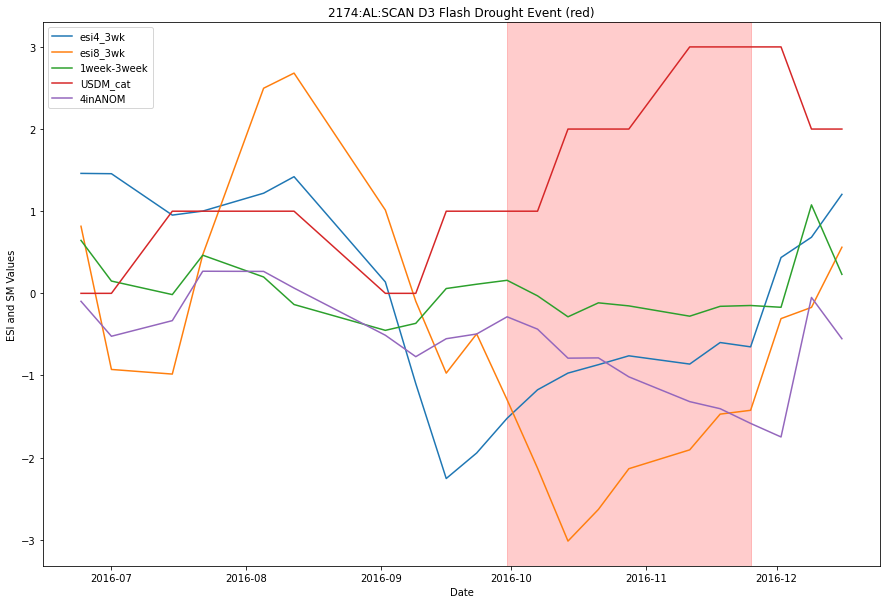

In [242]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(caseFrame['esi4_change_anom_3wk'], label='esi4_3wk')
ax.plot(caseFrame['esi8_change_anom_3wk'], label='esi8_3wk')
ax.plot(caseFrame['1pentad-3pentad'], label='1week-3week')
ax.plot(caseFrame['Category'], label='USDM_cat')
ax.plot(caseFrame['4inANOM'], label='4inANOM')
plt.axvspan(startFlash, endFlash, color='red', alpha=0.20)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('ESI and SM Values')
ax.set_title('2174:AL:SCAN D3 Flash Drought Event (red)')

In [243]:
testFrame

Date    ESI       station  week_x  week_y   2inANOM   4inANOM  \
0    2002-02-12 -1.326  2053:AL:SCAN       7       7  0.834835 -0.643664   
1    2002-02-19 -1.577  2053:AL:SCAN       8       8  0.164259 -1.027176   
2    2002-02-26 -1.735  2053:AL:SCAN       9       9  0.106221 -1.050136   
3    2002-03-05 -0.752  2053:AL:SCAN      10      10 -0.309406 -1.455401   
4    2002-03-12 -2.121  2053:AL:SCAN      11      11 -0.113839 -1.455137   
...         ...    ...           ...     ...     ...       ...       ...   
9669 2020-12-02 -0.337  2181:AL:SCAN      49      49  1.621483  1.227094   
9670 2020-12-09  0.266  2181:AL:SCAN      50      50  1.309197  0.938780   
9671 2020-12-16 -0.068  2181:AL:SCAN      51      51  0.807112  0.612089   
9672 2020-12-23  0.715  2181:AL:SCAN      52      52  0.490286  0.302427   
9673 2020-12-30 -1.414  2181:AL:SCAN      53      53       NaN       NaN   

       8inANOM  20inANOM  40inANOM  ...  esi2_change_anom_3wk  \
0     0.542349 -0.382594 -1.350406  ...                   NaN   
1     0.290153 -0.570702 -0.278074  ...                   NaN   
2     0.179310 -0.718167 -1.268593  ...                   NaN   
3     0.104532 -1.160224 -1.585050  ...                   NaN   
4     0.076642 -1.003007 -1.445378  ...              0.008230   
...        ...       ...       ...  ...                   ...   
9669  1.383636  1.925959  1.081761  ...              0.729035   
9670  0.903196  0.887784  0.855720  ...              1.064996   
9671  0.423563  0.223647  0.281672  ...              1.105831   
9672 -0.436928 -1.622440 -1.132620  ...              0.692376   
9673       NaN       NaN       NaN  ...             -0.295088   

      esi2_change_anom_4wk  esi4_change_anom  esi4_change_anom_2wk  \
0                      NaN               NaN                   NaN   
1                      NaN               NaN                   NaN   
2                      NaN         -0.275622                   NaN   
3                      NaN          0.560553              0.181687   
4                      NaN         -0.573135             -0.009710   
...                    ...               ...                   ...   
9669              0.187488          0.957390              0.174247   
9670              1.048639          0.656259              1.027343   
9671              1.142494          1.103457              1.120319   
9672              1.261703          0.841784              1.238413   
9673              0.066945         -0.755944              0.054831   

      esi4_change_anom_3wk  esi4_change_anom_4wk  esi8_change_anom  \
0                      NaN                   NaN               NaN   
1                      NaN                   NaN               NaN   
2                      NaN                   NaN         -0.542363   
3                      NaN                   NaN          1.107115   
4                -0.147293                   NaN         -0.881266   
...                    ...                   ...               ...   
9669             -0.537732             -1.029559          0.084918   
9670              0.471145             -0.171152         -0.662214   
9671              1.369083              0.884961         -0.237599   
9672              1.311005              1.541198          0.159294   
9673              0.601558              0.804271          0.201890   

      esi8_change_anom_2wk  esi8_change_anom_3wk  esi8_change_anom_4wk  
0                      NaN                   NaN                   NaN  
1                      NaN                   NaN                   NaN  
2                      NaN                   NaN                   NaN  
3                 0.353747                   NaN                   NaN  
4                 0.141264             -0.152916                   NaN  
...                    ...                   ...                   ...  
9669              0.088477             -0.660622             -0.198891  
9670             -0.363338             -0.253150   

In [244]:
tops = list(goodmonths_df.tail(5)['index'])

In [245]:
for i in tops:
    print(i[i.index('e'):])

esi2_4wk
ext1esi_2wk
ext1esi2
esi4_3wk
esi4_4wk


In [246]:
for i in tops:
    print(i)

prior2esi2_4wk
next1esi_2wk
next1esi2
prior2esi4_3wk
prior2esi4_4wk


In [247]:
values = []
columns = []
for i in tops:
    #give me the phrase that describes which esi I want
    esi_phrase = i[i.index('esi'):]
    #give me the index of esi in the context of 'where' along the flash drought
    for j in ['prior2', 'prior1', 'start', 'next1', 'next2']:
        #name of column
        drought_index = j+esi_phrase
        for i,r in goodmonths.iterrows():
            #give me the column name and the values
            columns.append(drought_index)
            values.append(r[drought_index])
            
plotFrame = pd.DataFrame()
plotFrame['values']=values
plotFrame['columns']=columns

<AxesSubplot:xlabel='columns', ylabel='values'>

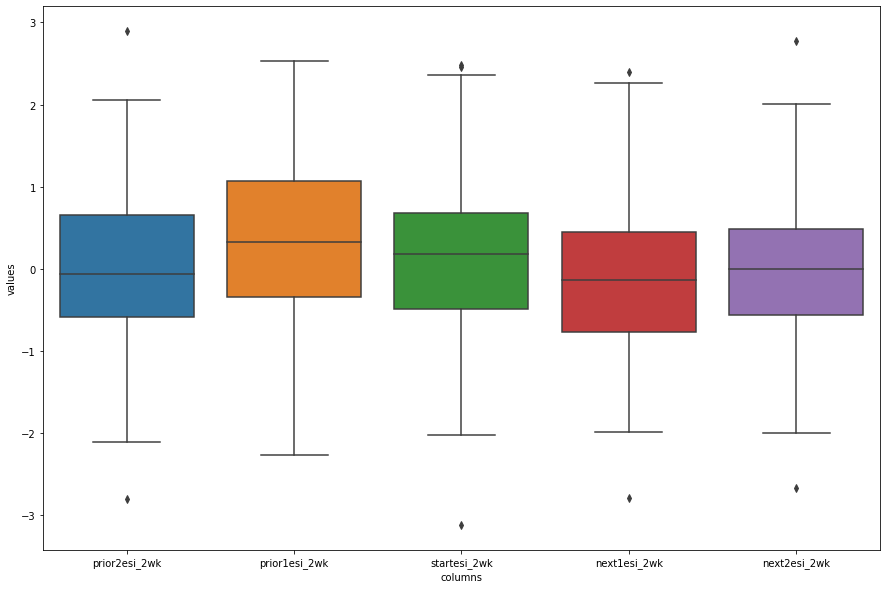

In [248]:
data=plotFrame[plotFrame['columns'].str.contains('esi_2wk')]
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='columns', y="values", data=data)

In [249]:
values = []
columns = []
for i in tops:
    #give me the phrase that describes which esi I want
    esi_phrase = i[i.index('esi'):]
    #give me the index of esi in the context of 'where' along the flash drought
    for j in ['prior2', 'prior1', 'start', 'next1', 'next2']:
        #name of column
        drought_index = j+esi_phrase
        for i,r in goodmonths.iterrows():
            #give me the column name and the values
            if r[drought_index]<0:
                columns.append(drought_index)
                values.append(r[drought_index])
            
plotFrame = pd.DataFrame()
plotFrame['values']=values
plotFrame['columns']=columns

In [250]:
data=plotFrame[plotFrame['columns'].str.contains('esi_2wk')]

In [251]:
for i in data['columns'].unique():
    columnFrame = len(data[data['columns']==i])
    print(i, columnFrame, columnFrame/len(goodmonths)*100.0)

prior2esi_2wk 67 51.93798449612403
prior1esi_2wk 49 37.98449612403101
startesi_2wk 57 44.18604651162791
next1esi_2wk 77 59.68992248062015
next2esi_2wk 65 50.3875968992248


<AxesSubplot:xlabel='columns', ylabel='values'>

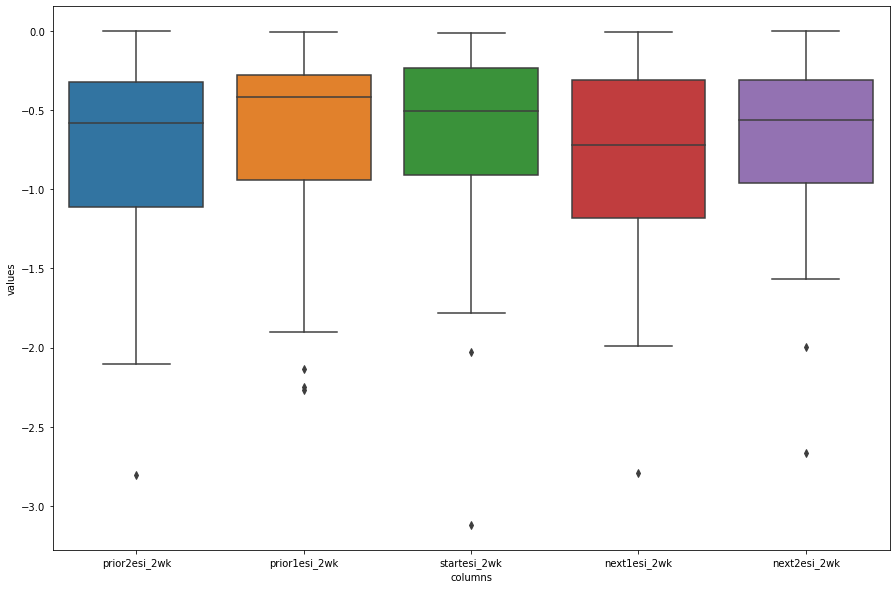

In [252]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='columns', y="values", data=data)

In [253]:
store = {}

count=0
for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    store[count]=droughtFrame
        
            
allDroughts = pd.concat(store, axis=0, ignore_index=True)
allDroughts

Date    ESI       station  week_x  week_y   2inANOM   4inANOM  \
0   2002-05-21  1.019  2053:AL:SCAN      21      21  0.833767  0.592069   
1   2002-05-28  0.616  2053:AL:SCAN      22      22  0.525797  0.340599   
2   2002-06-04  1.050  2053:AL:SCAN      23      23  0.397847  0.120181   
3   2002-06-11  0.375  2053:AL:SCAN      24      24  0.530284  0.008501   
4   2002-06-18  0.326  2053:AL:SCAN      25      25  0.557770 -0.556707   
..         ...    ...           ...     ...     ...       ...       ...   
867 2017-10-29  1.245  2181:AL:SCAN      43      43  1.287823  1.102059   
868 2017-11-05  1.240  2181:AL:SCAN      44      44  0.638504  1.008676   
869 2017-11-12  0.503  2181:AL:SCAN      45      45  0.079383  0.366460   
870 2017-11-19 -0.044  2181:AL:SCAN      46      46 -0.094473  0.296514   
871 2017-11-26  0.025  2181:AL:SCAN      47      47 -0.837934 -0.632105   

      8inANOM  20inANOM  40inANOM  ...  esi2_change_anom_3wk  \
0    1.289427  0.107729  0.793055  ...              2.275100   
1    1.097857  0.305185  0.729185  ...              1.203566   
2    0.765955 -0.138867  0.481980  ...             -0.358014   
3    0.915167  0.396501  0.827600  ...             -0.689087   
4    0.471189 -0.018916  0.809864  ...             -0.443830   
..        ...       ...       ...  ...                   ...   
867  1.240796  1.388071       NaN  ...              2.047819   
868  0.639408       NaN       NaN  ...              2.195382   
869  0.003918       NaN       NaN  ...              0.225558   
870  0.005803       NaN       NaN  ...             -0.678380   
871 -0.258806       NaN       NaN  ...             -1.165615   

     esi2_change_anom_4wk  esi4_change_anom  esi4_change_anom_2wk  \
0                1.608649          1.066396              1.610503   
1                1.648987          1.502320              1.650894   
2                1.187387          0.347942              1.188697   
3               -0.463737         -1.067563             -0.464563   
4               -1.008764         -0.500362             -1.010294   
..                    ...               ...                   ...   
867              0.195940          0.625107              0.182619   
868              2.219377          2.810561              2.187130   
869              1.776347         -0.064380              1.748244   
870             -0.352955         -0.503270             -0.361141   
871             -0.860927         -0.854937             -0.864362   

     esi4_change_anom_3wk  esi4_change_anom_4wk  esi8_change_anom  \
0                1.616545              0.487502          2.199261   
1                2.021756              2.040234         -0.566289   
2                1.470669              1.887683          1.034634   
3                0.393348              0.800338          0.368228   
4               -0.617698              0.120825          0.559635   
..                    ...                   ...               ...   
867              1.473066              0.279341          0.761732   
868              1.560008              2.477020          0.504800   
869              1.697724              1.314909          2.518339   
870              1.130861              1.244045         -0.817050   
871             -0.710573              0.607460         -0.219344   

     esi8_change_anom_2wk  esi8_change_anom_3wk  esi8_change_anom_4wk  
0                2.525783              2.717828              2.293859  
1                1.023491              1.671741              2.046614  
2                0.293303              1.287824              1.817861  
3                0.879218              0.403797              1.226918  
4                0.581407              0.947396              0.563992  
..                    ...                   ...                   ...  
867             -0.013310             -0.356452             -0.777380  
868              0.807860              0.249523             -0.079881  
869              1.923655         

In [254]:
allDroughts['sequenceNeg'].max()

31

<AxesSubplot:xlabel='sequenceNeg', ylabel='ESI'>

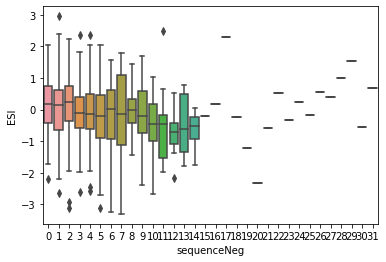

In [255]:
sns.boxplot(x='sequenceNeg', y='ESI', data=allDroughts)

In [256]:
newPlot = allDroughts[allDroughts['sequenceNeg']<14]

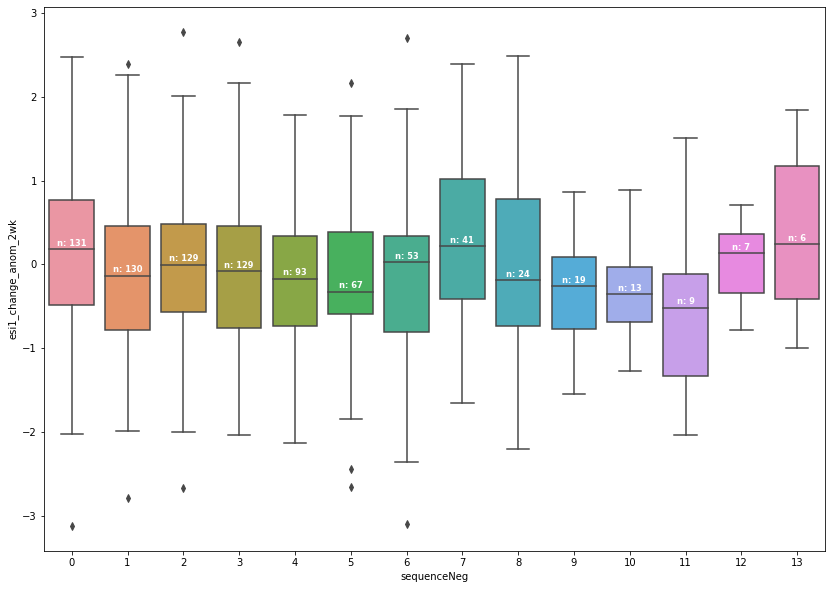

In [257]:
fig, ax = plt.subplots(figsize=(14,10))
g = sns.boxplot(x='sequenceNeg', y='esi1_change_anom_2wk', data=newPlot)
nobs = newPlot['sequenceNeg'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
medians = newPlot.groupby(['sequenceNeg'])['esi1_change_anom_2wk'].median().values
pos = range(len(nobs))
for tick,label in zip(pos,g.get_xticklabels()):
    g.text(pos[tick],
            medians[tick] + 0.04,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='w',
            weight='semibold')

In [258]:
test = newPlot[newPlot['esi1_change_anom_2wk']<0]

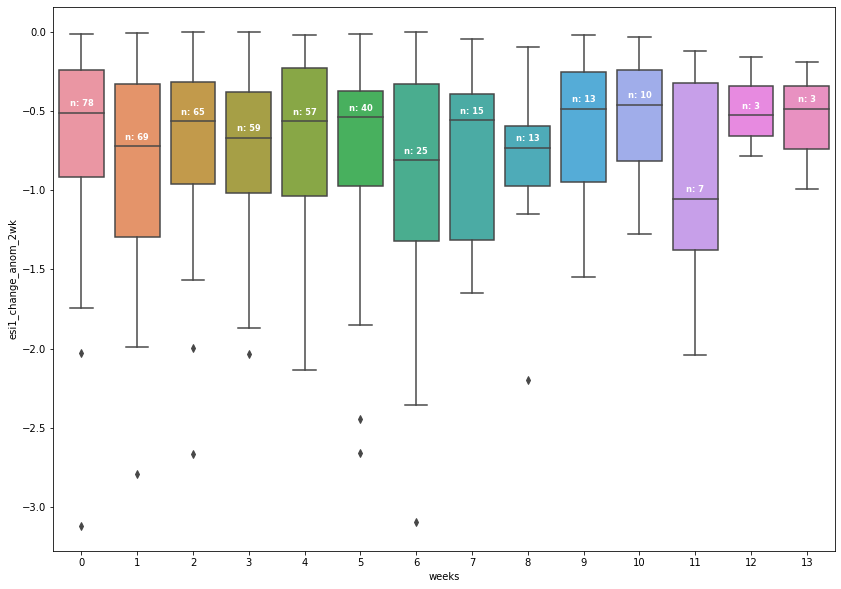

In [259]:
fig, ax = plt.subplots(figsize=(14,10))
g = sns.boxplot(x='sequenceNeg', y='esi1_change_anom_2wk', data=test)
g.set_xlabel('weeks')
nobs = test['sequenceNeg'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
medians = test.groupby(['sequenceNeg'])['esi1_change_anom_2wk'].median().values
pos = range(len(nobs))
for tick,label in zip(pos,g.get_xticklabels()):
    g.text(pos[tick],
            medians[tick] + 0.04,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='w',
            weight='semibold')

In [260]:
store = {}

for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
    droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
    store[count]=droughtFrame
        
            
allDroughts = pd.concat(store, axis=0, ignore_index=True)
allDroughts

/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/3044186300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Date    ESI       station  week_x  week_y   2inANOM   4inANOM  \
0   2002-05-21  1.019  2053:AL:SCAN      21      21  0.833767  0.592069   
1   2002-05-28  0.616  2053:AL:SCAN      22      22  0.525797  0.340599   
2   2002-06-04  1.050  2053:AL:SCAN      23      23  0.397847  0.120181   
3   2002-06-11  0.375  2053:AL:SCAN      24      24  0.530284  0.008501   
4   2002-06-18  0.326  2053:AL:SCAN      25      25  0.557770 -0.556707   
..         ...    ...           ...     ...     ...       ...       ...   
867 2017-10-29  1.245  2181:AL:SCAN      43      43  1.287823  1.102059   
868 2017-11-05  1.240  2181:AL:SCAN      44      44  0.638504  1.008676   
869 2017-11-12  0.503  2181:AL:SCAN      45      45  0.079383  0.366460   
870 2017-11-19 -0.044  2181:AL:SCAN      46      46 -0.094473  0.296514   
871 2017-11-26  0.025  2181:AL:SCAN      47      47 -0.837934 -0.632105   

      8inANOM  20inANOM  40inANOM  ...  esi4_change_anom  \
0    1.289427  0.107729  0.793055  ...          1.066396   
1    1.097857  0.305185  0.729185  ...          1.502320   
2    0.765955 -0.138867  0.481980  ...          0.347942   
3    0.915167  0.396501  0.827600  ...         -1.067563   
4    0.471189 -0.018916  0.809864  ...         -0.500362   
..        ...       ...       ...  ...               ...   
867  1.240796  1.388071       NaN  ...          0.625107   
868  0.639408       NaN       NaN  ...          2.810561   
869  0.003918       NaN       NaN  ...         -0.064380   
870  0.005803       NaN       NaN  ...         -0.503270   
871 -0.258806       NaN       NaN  ...         -0.854937   

     esi4_change_anom_2wk  esi4_change_anom_3wk  esi4_change_anom_4wk  \
0                1.610503              1.616545              0.487502   
1                1.650894              2.021756              2.040234   
2                1.188697              1.470669              1.887683   
3               -0.464563              0.393348              0.800338   
4               -1.010294             -0.617698              0.120825   
..                    ...                   ...                   ...   
867              0.182619              1.473066              0.279341   
868              2.187130              1.560008              2.477020   
869              1.748244              1.697724              1.314909   
870             -0.361141              1.130861              1.244045   
871             -0.864362             -0.710573              0.607460   

     esi8_change_anom  esi8_change_anom_2wk  esi8_change_anom_3wk  \
0            2.199261              2.525783              2.717828   
1           -0.566289              1.023491              1.671741   
2            1.034634              0.293303              1.287824   
3            0.368228              0.879218              0.403797   
4            0.559635              0.581407              0.947396   
..                ...                   ...                   ...   
867          0.761732             -0.013310             -0.356452   
868          0.504800              0.807860              0.249523   
869          2.518339              1.923655              1.900342   
870         -0.817050              1.084017              1.112068   
871         -0.219344             -0.654957              0.750508   

     esi8_change_anom_4wk  esi1_change_anom_2wk_cumsum  \
0                2.293859                     0.348007   
1                2.046614                    -0.593606   
2                1.817861                    -0.572524   
3                1.226918                    -0.756335   
4                0.563992                    -1.303981   
..                    ...                          ...   
867             -0.777380                     2.926189   
868             -0.079881                     3.324670   
869              1.259823                     2.797646   
870              1.247754                     1.888867   
871              0.840481                   

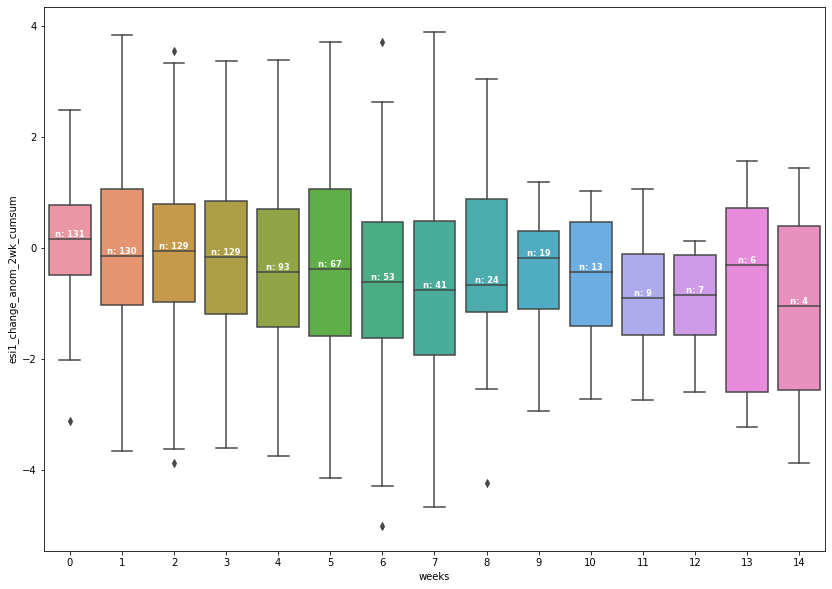

In [261]:
newPlot = allDroughts[allDroughts['sequenceNeg']<15]
fig, ax = plt.subplots(figsize=(14,10))
g = sns.boxplot(x='sequenceNeg', y='esi1_change_anom_2wk_cumsum', data=newPlot)
g.set_xlabel('weeks')
nobs = newPlot['sequenceNeg'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
medians = newPlot.groupby(['sequenceNeg'])['esi1_change_anom_2wk_cumsum'].median().values
pos = range(len(nobs))
for tick,label in zip(pos,g.get_xticklabels()):
    g.text(pos[tick],
            medians[tick] + 0.04,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='w',
            weight='semibold')

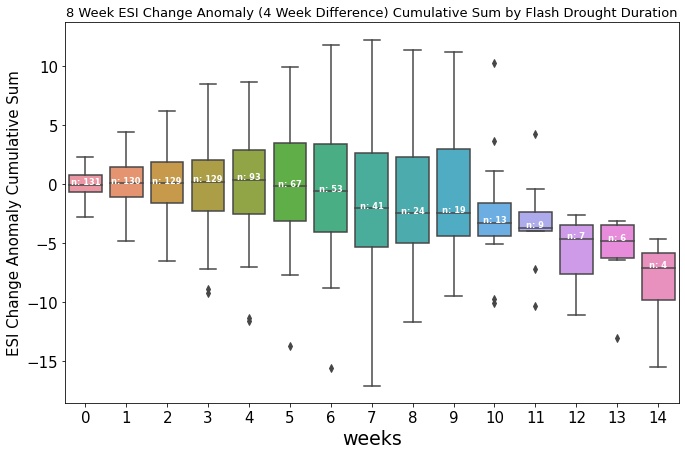

In [262]:
newPlot = allDroughts[allDroughts['sequenceNeg']<15]
fig, ax = plt.subplots(figsize=(11,7))
g = sns.boxplot(x='sequenceNeg', y='esi8_change_anom_4wk_cumsum', data=newPlot)
g.set_xlabel('weeks', fontsize=19)
nobs = newPlot['sequenceNeg'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
medians = newPlot.groupby(['sequenceNeg'])['esi8_change_anom_4wk_cumsum'].median().values
pos = range(len(nobs))
for tick,label in zip(pos,g.get_xticklabels()):
    g.text(pos[tick],
            medians[tick] + 0.04,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='w',
            weight='semibold')
ax.set_title('8 Week ESI Change Anomaly (4 Week Difference) Cumulative Sum by Flash Drought Duration', fontsize=13)
ax.set_ylabel('ESI Change Anomaly Cumulative Sum', fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

In [263]:
allDroughts.columns

Index(['Date', 'ESI', 'station', 'week_x', 'week_y', '2inANOM', '4inANOM',
       '8inANOM', '20inANOM', '40inANOM', '2in_pr', '4in_pr', '8in_pr',
       '20in_pr', '40in_pr', '2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC',
       '40inSMSDC', 'point', 'Category', 'Station Name', '4in3pentad',
       '1pentad-3pentad', 'numNegative', 'sequenceNeg', 'ESI2week', 'ESI4week',
       'ESI8week', 'esi1_change', 'esi1_change_2wk', 'esi1_change_3wk',
       'esi1_change_4wk', 'esi2_change', 'esi2_change_2wk', 'esi2_change_3wk',
       'esi2_change_4wk', 'esi4_change', 'esi4_change_2wk', 'esi4_change_3wk',
       'esi4_change_4wk', 'esi8_change', 'esi8_change_2wk', 'esi8_change_3wk',
       'esi8_change_4wk', 'esi1_change_anom', 'esi1_change_anom_2wk',
       'esi1_change_anom_3wk', 'esi1_change_anom_4wk', 'esi2_change_anom',
       'esi2_change_anom_2wk', 'esi2_change_anom_3wk', 'esi2_change_anom_4wk',
       'esi4_change_anom', 'esi4_change_anom_2wk', 'esi4_change_anom_3wk',
       'esi4_cha

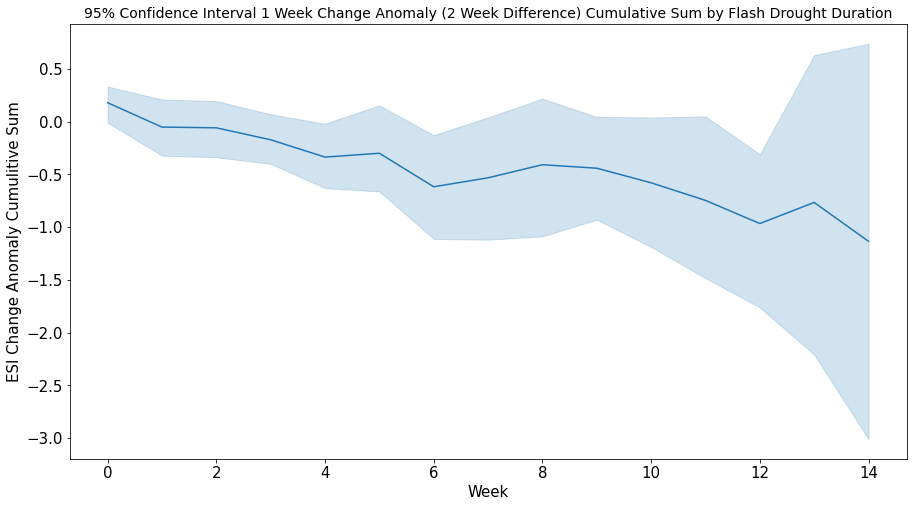

In [264]:
fig, ax = plt.subplots(figsize=(15,8))
g = sns.lineplot(x='sequenceNeg', y='esi1_change_anom_2wk_cumsum', data=newPlot)
ax.set_title('95% Confidence Interval 1 Week Change Anomaly (2 Week Difference) Cumulative Sum by Flash Drought Duration', fontsize=14)
ax.set_ylabel('ESI Change Anomaly Cumulitive Sum', fontsize=15)
ax.set_xlabel('Week', fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

In [265]:
deltas = []
drought_lengths = []

count=0
for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
    delta = droughtFrame['esi1_change_anom_2wk_cumsum'][endLoc]-droughtFrame['esi1_change_anom_2wk_cumsum'][startLoc]
    deltas.append(delta)
    drought_lengths.append(drought_length)
        
deltaFrame = pd.DataFrame()
deltaFrame['weeks']=drought_lengths
deltaFrame['esi1_change_anom_2wk_cumsum_delta']=deltas

/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi1_change_anom_2wk_cumsum']=droughtFrame['esi1_change_anom_2wk'].cumsum()
/tmp/ipykernel_18989/267647889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [266]:
deltaFrame

weeks  esi1_change_anom_2wk_cumsum_delta
0     10.0                          -2.604949
1      6.0                          -0.276514
2      4.0                           0.162670
3      5.0                          -0.124341
4      3.0                          -1.066677
..     ...                                ...
124    3.0                          -0.078712
125    3.0                          -1.588822
126    3.0                          -0.755585
127    7.0                          -1.251444
128    5.0                          -0.915119

[129 rows x 2 columns]

In [267]:
deltas = []
drought_lengths = []

count=0
for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
    delta = droughtFrame['esi4_change_anom_3wk_cumsum'][endLoc]-droughtFrame['esi4_change_anom_3wk_cumsum'][startLoc]
    deltas.append(delta)
    drought_lengths.append(drought_length)
        
deltaFrame = pd.DataFrame()
deltaFrame['weeks']=drought_lengths
deltaFrame['esi4_change_anom_3wk_cumsum_delta']=deltas

/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/78447417.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [268]:
deltas = []
drought_lengths = []

count=0
for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
    delta = droughtFrame['esi8_change_anom_3wk_cumsum'][endLoc]-droughtFrame['esi8_change_anom_3wk_cumsum'][startLoc]
    deltas.append(delta)
    drought_lengths.append(drought_length)
        
deltaFrame = pd.DataFrame()
deltaFrame['weeks']=drought_lengths
deltaFrame['esi8_change_anom_3wk_cumsum_delta']=deltas

/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/4042513668.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [269]:
store = {}

for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
    droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
    droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
    droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
    store[count]=droughtFrame
        
            
allDroughts = pd.concat(store, axis=0, ignore_index=True)
allDroughts

/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi4_change_anom_3wk_cumsum']=droughtFrame['esi4_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/1484248749.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_4wk_cumsum']=droughtFrame['esi8_change_anom_4wk'].cumsum()
/tmp/ipykernel_18989/1484248749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/1484248749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Date    ESI       station  week_x  week_y   2inANOM   4inANOM  \
0   2002-05-21  1.019  2053:AL:SCAN      21      21  0.833767  0.592069   
1   2002-05-28  0.616  2053:AL:SCAN      22      22  0.525797  0.340599   
2   2002-06-04  1.050  2053:AL:SCAN      23      23  0.397847  0.120181   
3   2002-06-11  0.375  2053:AL:SCAN      24      24  0.530284  0.008501   
4   2002-06-18  0.326  2053:AL:SCAN      25      25  0.557770 -0.556707   
..         ...    ...           ...     ...     ...       ...       ...   
867 2017-10-29  1.245  2181:AL:SCAN      43      43  1.287823  1.102059   
868 2017-11-05  1.240  2181:AL:SCAN      44      44  0.638504  1.008676   
869 2017-11-12  0.503  2181:AL:SCAN      45      45  0.079383  0.366460   
870 2017-11-19 -0.044  2181:AL:SCAN      46      46 -0.094473  0.296514   
871 2017-11-26  0.025  2181:AL:SCAN      47      47 -0.837934 -0.632105   

      8inANOM  20inANOM  40inANOM  ...  esi4_change_anom_3wk  \
0    1.289427  0.107729  0.793055  ...              1.616545   
1    1.097857  0.305185  0.729185  ...              2.021756   
2    0.765955 -0.138867  0.481980  ...              1.470669   
3    0.915167  0.396501  0.827600  ...              0.393348   
4    0.471189 -0.018916  0.809864  ...             -0.617698   
..        ...       ...       ...  ...                   ...   
867  1.240796  1.388071       NaN  ...              1.473066   
868  0.639408       NaN       NaN  ...              1.560008   
869  0.003918       NaN       NaN  ...              1.697724   
870  0.005803       NaN       NaN  ...              1.130861   
871 -0.258806       NaN       NaN  ...             -0.710573   

     esi4_change_anom_4wk  esi8_change_anom  esi8_change_anom_2wk  \
0                0.487502          2.199261              2.525783   
1                2.040234         -0.566289              1.023491   
2                1.887683          1.034634              0.293303   
3                0.800338          0.368228              0.879218   
4                0.120825          0.559635              0.581407   
..                    ...               ...                   ...   
867              0.279341          0.761732             -0.013310   
868              2.477020          0.504800              0.807860   
869              1.314909          2.518339              1.923655   
870              1.244045         -0.817050              1.084017   
871              0.607460         -0.219344             -0.654957   

     esi8_change_anom_3wk  esi8_change_anom_4wk  esi4_change_anom_3wk_cumsum  \
0                2.717828              2.293859                     1.616545   
1                1.671741              2.046614                     3.638301   
2                1.287824              1.817861                     5.108971   
3                0.403797              1.226918                     5.502319   
4                0.947396              0.563992                     4.884621   
..                    ...                   ...                          ...   
867             -0.356452             -0.777380                     1.477157   
868              0.249523             -0.079881                     3.037165   
869              1.900342              1.259823                     4.734889   
870              1.112068              1.247754                     5.865750   
871              0.750508              0.840481                     5.155177   

     esi8_change_anom_3wk_cumsum  esi8_change_anom_4wk_cumsum  4inANOM_cumsum  
0                       2.717828                     2.293859        0.592069  
1                       4.389569                     4.340473        0.932668  
2                       5.677393                     6.158334        1.052850  
3                       6.081190                     7.385253        1.061351  
4                       7.028586                     7.949245        0.504644  
..                           ...                          ...         

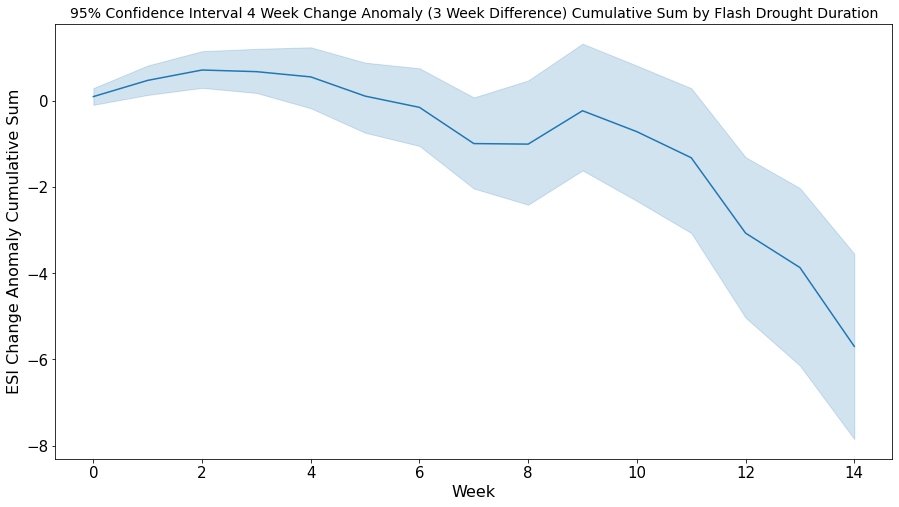

In [270]:
fig, ax = plt.subplots(figsize=(15,8))
g = sns.lineplot(x='sequenceNeg', y='esi4_change_anom_3wk_cumsum', data=allDroughts[allDroughts['sequenceNeg']<15])
ax.set_ylabel('ESI Change Anomaly Cumulative Sum', fontsize=16)
ax.set_title('95% Confidence Interval 4 Week Change Anomaly (3 Week Difference) Cumulative Sum by Flash Drought Duration', fontsize=14)
ax.set_xlabel('Week', fontsize=16)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

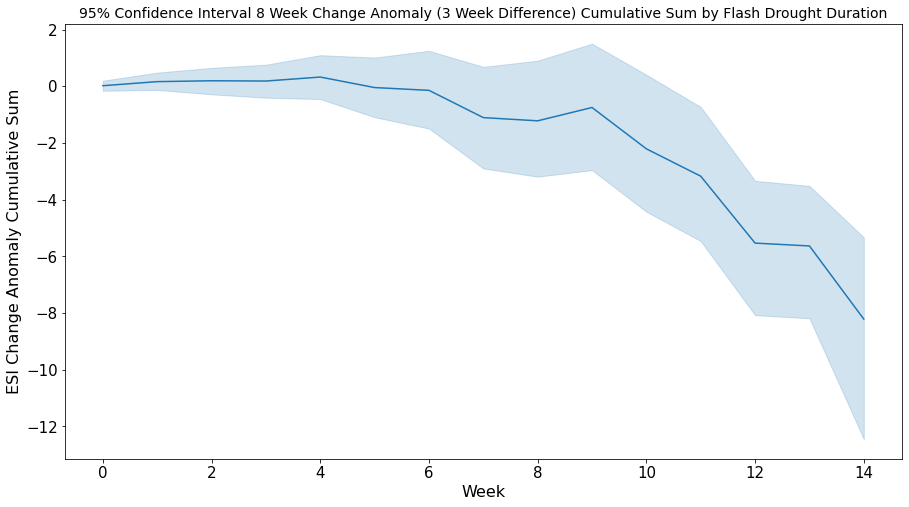

In [271]:
fig, ax = plt.subplots(figsize=(15,8))
g = sns.lineplot(x='sequenceNeg', y='esi8_change_anom_3wk_cumsum', data=allDroughts[allDroughts['sequenceNeg']<15])
g.set_xlabel('week')
ax.set_ylabel('ESI Change Anomaly Cumulative Sum', fontsize=16)
ax.set_title('95% Confidence Interval 8 Week Change Anomaly (3 Week Difference) Cumulative Sum by Flash Drought Duration', fontsize=14)
ax.set_xlabel('Week', fontsize=16)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

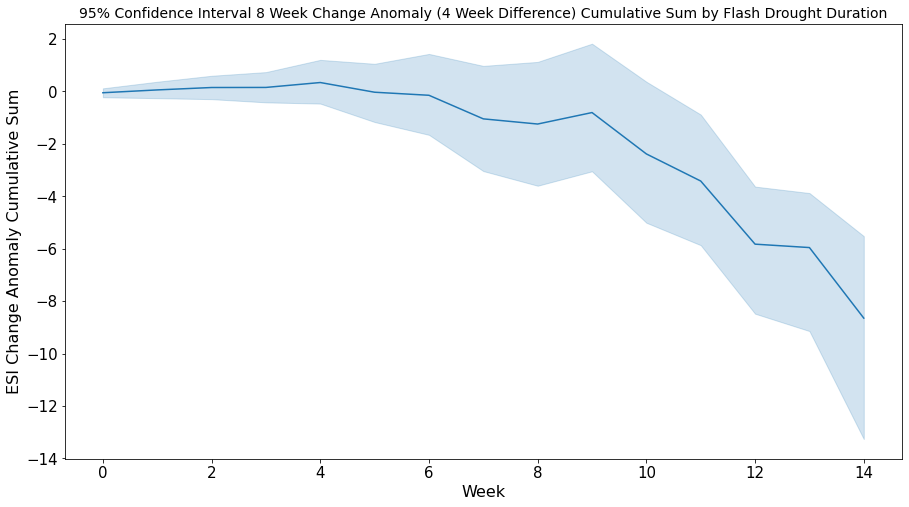

In [272]:
fig, ax = plt.subplots(figsize=(15, 8))
g = sns.lineplot(x='sequenceNeg', y='esi8_change_anom_4wk_cumsum', data=allDroughts[allDroughts['sequenceNeg']<15])
ax.set_ylabel('ESI Change Anomaly Cumulative Sum', fontsize=16)
ax.set_title('95% Confidence Interval 8 Week Change Anomaly (4 Week Difference) Cumulative Sum by Flash Drought Duration', fontsize=14)
ax.set_xlabel('Week', fontsize=16)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

In [273]:
store = {}

for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
    store[count]=droughtFrame
        
            
allDroughts = pd.concat(store, axis=0, ignore_index=True)
allDroughts

/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/1433706343.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Date    ESI       station  week_x  week_y   2inANOM   4inANOM  \
0   2002-05-21  1.019  2053:AL:SCAN      21      21  0.833767  0.592069   
1   2002-05-28  0.616  2053:AL:SCAN      22      22  0.525797  0.340599   
2   2002-06-04  1.050  2053:AL:SCAN      23      23  0.397847  0.120181   
3   2002-06-11  0.375  2053:AL:SCAN      24      24  0.530284  0.008501   
4   2002-06-18  0.326  2053:AL:SCAN      25      25  0.557770 -0.556707   
..         ...    ...           ...     ...     ...       ...       ...   
867 2017-10-29  1.245  2181:AL:SCAN      43      43  1.287823  1.102059   
868 2017-11-05  1.240  2181:AL:SCAN      44      44  0.638504  1.008676   
869 2017-11-12  0.503  2181:AL:SCAN      45      45  0.079383  0.366460   
870 2017-11-19 -0.044  2181:AL:SCAN      46      46 -0.094473  0.296514   
871 2017-11-26  0.025  2181:AL:SCAN      47      47 -0.837934 -0.632105   

      8inANOM  20inANOM  40inANOM  ...  esi2_change_anom_4wk  \
0    1.289427  0.107729  0.793055  ...              1.608649   
1    1.097857  0.305185  0.729185  ...              1.648987   
2    0.765955 -0.138867  0.481980  ...              1.187387   
3    0.915167  0.396501  0.827600  ...             -0.463737   
4    0.471189 -0.018916  0.809864  ...             -1.008764   
..        ...       ...       ...  ...                   ...   
867  1.240796  1.388071       NaN  ...              0.195940   
868  0.639408       NaN       NaN  ...              2.219377   
869  0.003918       NaN       NaN  ...              1.776347   
870  0.005803       NaN       NaN  ...             -0.352955   
871 -0.258806       NaN       NaN  ...             -0.860927   

     esi4_change_anom  esi4_change_anom_2wk  esi4_change_anom_3wk  \
0            1.066396              1.610503              1.616545   
1            1.502320              1.650894              2.021756   
2            0.347942              1.188697              1.470669   
3           -1.067563             -0.464563              0.393348   
4           -0.500362             -1.010294             -0.617698   
..                ...                   ...                   ...   
867          0.625107              0.182619              1.473066   
868          2.810561              2.187130              1.560008   
869         -0.064380              1.748244              1.697724   
870         -0.503270             -0.361141              1.130861   
871         -0.854937             -0.864362             -0.710573   

     esi4_change_anom_4wk  esi8_change_anom  esi8_change_anom_2wk  \
0                0.487502          2.199261              2.525783   
1                2.040234         -0.566289              1.023491   
2                1.887683          1.034634              0.293303   
3                0.800338          0.368228              0.879218   
4                0.120825          0.559635              0.581407   
..                    ...               ...                   ...   
867              0.279341          0.761732             -0.013310   
868              2.477020          0.504800              0.807860   
869              1.314909          2.518339              1.923655   
870              1.244045         -0.817050              1.084017   
871              0.607460         -0.219344             -0.654957   

     esi8_change_anom_3wk  esi8_change_anom_4wk  esi8_change_anom_3wk_cumsum  
0                2.717828              2.293859                     2.717828  
1                1.671741              2.046614                     4.389569  
2                1.287824              1.817861                     5.677393  
3                0.403797              1.226918                     6.081190  
4                0.947396              0.563992                     7.028586  
..                    ...                   ...                          ...  
867             -0.356452             -0.777380                    -1.680103  
868              0.249523             -0.079881   

In [274]:
store = {}

count=0
for i,r in goodmonths.iterrows():
    count+=1
    #date
    date = i
    station = r['station']
    drought_length = r['drought_duration']
    startLoc = testFrame[(testFrame['station']==station)&(testFrame['Date']==date)].index.item()
    endLoc = startLoc+drought_length
    droughtFrame = testFrame.loc[startLoc:endLoc]
    droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
    droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
    store[count]=droughtFrame

xf = pd.concat(store, axis=0, ignore_index=True)

/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['4inANOM_cumsum']=droughtFrame['4inANOM'].cumsum()
/tmp/ipykernel_18989/2164924798.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droughtFrame['esi8_change_anom_3wk_cumsum']=droughtFrame['esi8_change_anom_3wk'].cumsum()
/tmp/ipykernel_18989/2164924798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [275]:
caseFrame['esi8_change_anom_3wk_cumsum']=caseFrame['esi8_change_anom_3wk'].cumsum()

In [276]:
caseFrame

ESI       station  week_x  week_y   2inANOM   4inANOM   8inANOM  \
Date                                                                            
2016-06-24 -0.311  2174:AL:SCAN      25      25 -0.343077 -0.096882  0.189697   
2016-07-01 -0.507  2174:AL:SCAN      26      26 -0.893587 -0.522352 -0.485091   
2016-07-15  1.731  2174:AL:SCAN      28      28 -0.561866 -0.332297 -0.267630   
2016-07-22  2.007  2174:AL:SCAN      29      29  0.214940  0.269163  0.534090   
2016-08-05  1.101  2174:AL:SCAN      31      31  0.247206  0.267168  0.596647   
2016-08-12  1.064  2174:AL:SCAN      32      32 -0.005983  0.064068 -0.297137   
2016-09-02 -0.872  2174:AL:SCAN      35      35 -0.772314 -0.510082 -0.802449   
2016-09-09  0.217  2174:AL:SCAN      36      36 -0.902131 -0.770897 -1.170523   
2016-09-16 -0.312  2174:AL:SCAN      37      37 -0.845050 -0.552366 -0.828741   
2016-09-23 -0.736  2174:AL:SCAN      38      38 -0.958681 -0.494896 -0.920816   
2016-09-30 -1.569  2174:AL:SCAN      39      39 -0.914790 -0.285497 -0.631920   
2016-10-07 -0.300  2174:AL:SCAN      40      40 -0.797164 -0.435737 -0.919556   
2016-10-14 -1.586  2174:AL:SCAN      41      41 -1.118441 -0.789109 -1.390752   
2016-10-21 -1.168  2174:AL:SCAN      42      42 -1.126865 -0.785786 -1.437777   
2016-10-28 -1.807  2174:AL:SCAN      43      43 -1.268061 -1.016440 -1.601410   
2016-11-11 -1.834  2174:AL:SCAN      45      45 -1.428441 -1.318202 -1.854035   
2016-11-18 -1.340  2174:AL:SCAN      46      46 -1.530953 -1.404314 -1.870509   
2016-11-25 -1.542  2174:AL:SCAN      47      47 -1.665912 -1.583182 -2.052342   
2016-12-02 -0.529  2174:AL:SCAN      48      48 -1.884817 -1.748277 -1.862358   
2016-12-09 -0.950  2174:AL:SCAN      49      49 -0.321599 -0.049946  0.177549   
2016-12-16 -0.364  2174:AL:SCAN      50      50 -0.764482 -0.552570 -0.364561   

            20inANOM  40inANOM     2in_pr  ...  esi2_change_anom_4wk  \
Date                                       ...                         
2016-06-24  0.409823  0.317007  36.613097  ...              1.439975   
2016-07-01  0.127583  0.115841  19.558325  ...              0.700041   
2016-07-15  0.647772  0.372793  29.659998  ...              0.929150   
2016-07-22  0.694524  0.894014  55.373346  ...              0.861303   
2016-08-05  0.647452  0.473238  56.466601  ...              1.038788   
2016-08-12  0.567393  0.560375  47.600306  ...              1.461607   
2016-09-02  0.169060  0.015724  22.936482  ...             -0.512367   
2016-09-09  0.106477 -0.157760  19.317809  ...             -2.164803   
2016-09-16  0.252745 -0.101467  20.957691  ...             -1.579739   
2016-09-23  0.120251 -0.209202  17.809118  ...             -1.584656   
2016-09-30  0.260280  0.031900  19.055428  ...             -1.232635   
2016-10-07  0.252524  0.020227  22.335192  ...             -0.601848   
2016-10-14  0.214432 -0.195555  13.709413  ...             -0.885530   
2016-10-21  0.197820 -0.022987  13.479829  ...             -0.843739   
2016-10-28  0.101210  0.014608  10.145403  ...             -0.334390   
2016-11-11 -0.021404 -0.120025   7.204548  ...             -0.876188   
2016-11-18 -0.174888 -0.075340   5.859845  ...             -0.638230   
2016-11-25 -0.447239 -0.222933   3.990379  ...             -0.067916   
2016-12-02 -0.886827  0.014401   2.219307  ...              0.439467   
2016-12-09  0.131794  0.506583  37.236252  ...              1.057963   
2016-12-16  0.150555  0.416142  23.198863  ...              0.909484   

            esi4_change_anom  esi4_change_anom_2wk  esi4_change_anom_3wk  \
Date                                                                       
2016-06-24          0.432573              1.437015              1.460283   
2016-07-01          0.631854              0.697044              1.456416   
2016-07-15          0.784335              0.926165              0.952474   
2016-07-22          0.527685              0.858314              1.001205   
2016-08-05          1.056837         

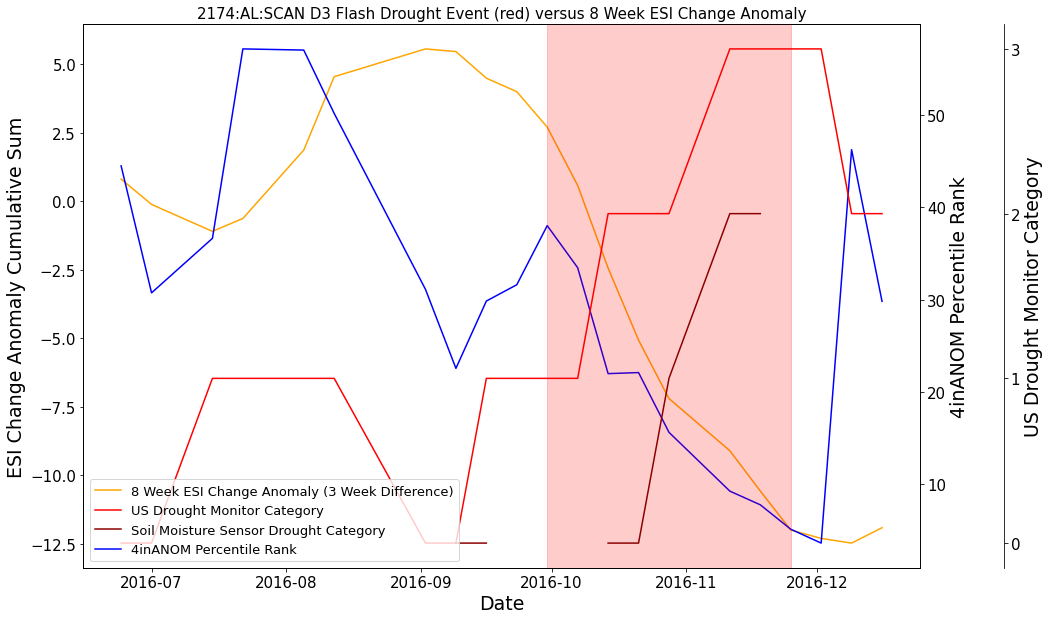

In [277]:
fig, ax = plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines.right.set_position(("axes", 1.1))
ESI_h, = ax.plot(caseFrame['esi8_change_anom_3wk_cumsum'], label='8 Week ESI Change Anomaly (3 Week Difference)', color='orange')
#ax2.plot(caseFrame['1pentad-3pentad'], label='1week-3week', color='green')
USDM_h, = ax3.plot(caseFrame['Category'], label='US Drought Monitor Category', color='red')
SMUSDM_h, = ax3.plot(caseFrame['4inSMSDC'], label='Soil Moisture Sensor Drought Category', color='darkred')
SM_h, = ax2.plot(caseFrame['4in_pr'], label='4inANOM Percentile Rank', color='blue')
plt.axvspan(startFlash, endFlash, color='red', alpha=0.20)
ax.set_xlabel('Date', fontsize=19)
ax.set_ylabel('ESI Change Anomaly Cumulative Sum', fontsize=19)
ax2.set_ylabel('4inANOM Percentile Rank', fontsize=19)
ax3.set_ylabel('US Drought Monitor Category', fontsize=19)
ax.set_title('2174:AL:SCAN D3 Flash Drought Event (red) versus 8 Week ESI Change Anomaly', fontsize=15)
ax3.legend(handles=[ESI_h, USDM_h, SMUSDM_h, SM_h], loc='lower left', prop={'size': 13})
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.locator_params(axis='y', nbins=5)
ax2.yaxis.set_tick_params(labelsize=15)

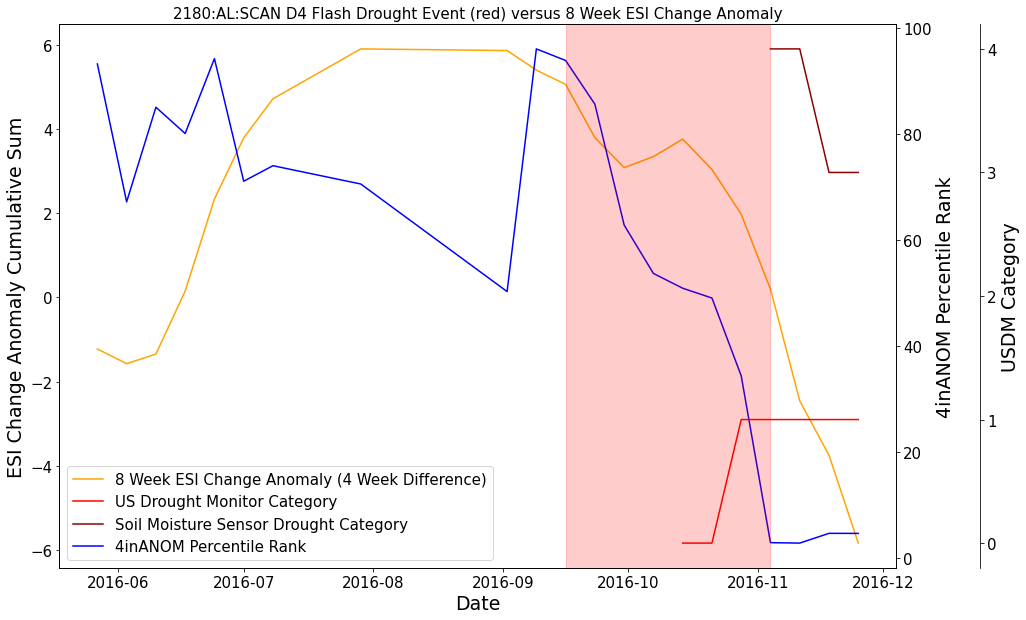

In [278]:
fig, ax = plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines.right.set_position(("axes", 1.1))
ESI_h, = ax.plot(caseFrame2['esi8_change_anom_4wk_cumsum'], label='8 Week ESI Change Anomaly (4 Week Difference)', color='orange')
#ax2.plot(caseFrame['1pentad-3pentad'], label='1week-3week', color='green')
USDM_h, = ax3.plot(caseFrame2['Category'], label='US Drought Monitor Category', color='red')
SMUSDM_h, = ax3.plot(caseFrame2['4inSMSDC'], label='Soil Moisture Sensor Drought Category', color='darkred')
SM_h, = ax2.plot(caseFrame2['4in_pr'], label='4inANOM Percentile Rank', color='blue')
plt.axvspan(startFlash2, endFlash2, color='red', alpha=0.20)
ax.set_xlabel('Date', fontsize=19)
ax.set_ylabel('ESI Change Anomaly Cumulative Sum', fontsize=19)
ax2.set_ylabel('4inANOM Percentile Rank', fontsize=19)
ax3.set_ylabel('USDM Category', fontsize=19)
ax3.yaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
ax3.locator_params(axis='y', nbins=5)
ax.set_title('2180:AL:SCAN D4 Flash Drought Event (red) versus 8 Week ESI Change Anomaly', fontsize=15)
ax3.legend(handles=[ESI_h, USDM_h, SMUSDM_h, SM_h], loc='lower left', prop={'size': 15})
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

In [279]:
caseFrame2['4in_pr']

Date
2016-05-27    93.152248
2016-06-03    67.165031
2016-06-10    85.003424
2016-06-17    80.050217
2016-06-24    94.167998
2016-07-01    71.056836
2016-07-08    73.978544
2016-07-29    70.531842
2016-09-02    50.262497
2016-09-09    95.994065
2016-09-16    93.814198
2016-09-23    85.574070
2016-09-30    62.793883
2016-10-07    53.674960
2016-10-14    50.890208
2016-10-21    49.041315
2016-10-28    34.375713
2016-11-04     2.933120
2016-11-11     2.853230
2016-11-18     4.690710
2016-11-25     4.679297
Name: 4in_pr, dtype: float64

In [280]:
months=[]
counts=[]
for m in goodmonths.index.month.unique():
    lengthFrame = goodmonths[goodmonths.index.month==m]
    length = len(lengthFrame)
    months.append(m)
    counts.append(length)
countsFrame = pd.DataFrame()
countsFrame['months']=months
countsFrame['counts']=counts

In [281]:
countsFrame = countsFrame.sort_values('months')

<AxesSubplot:xlabel='months'>

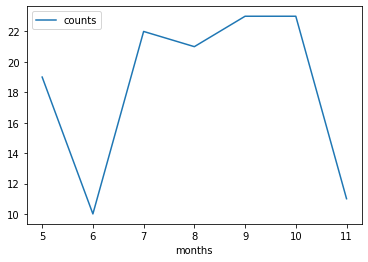

In [282]:
countsFrame.set_index('months').plot()

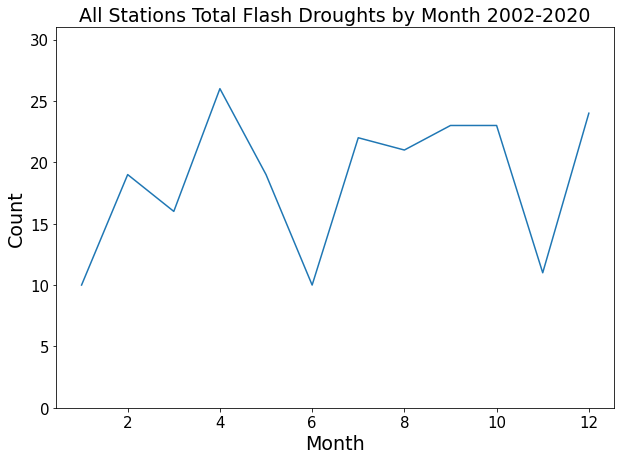

In [283]:
months=[]
counts=[]
for m in fixed.index.month.unique():
    lengthFrame = fixed[fixed.index.month==m]
    length = len(lengthFrame)
    months.append(m)
    counts.append(length)
countsFrame = pd.DataFrame()
countsFrame['months']=months
countsFrame['counts']=counts
countsFrame = countsFrame.sort_values('months')
countsFrame = countsFrame.set_index('months')
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(countsFrame['counts'])
ax.set_ylim(0, countsFrame['counts'].max()+5)
ax.set_ylabel('Count', fontsize=19)
ax.set_xlabel('Month', fontsize=19)
ax.set_title('All Stations Total Flash Droughts by Month 2002-2020', fontsize=19)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

In [284]:
fixed.index.max()

Timestamp('2020-10-14 00:00:00')

In [287]:
newPlot.columns

Index(['Date', 'ESI', 'station', 'week_x', 'week_y', '2inANOM', '4inANOM',
       '8inANOM', '20inANOM', '40inANOM', '2in_pr', '4in_pr', '8in_pr',
       '20in_pr', '40in_pr', '2inSMSDC', '4inSMSDC', '8inSMSDC', '20inSMSDC',
       '40inSMSDC', 'point', 'Category', 'Station Name', '4in3pentad',
       '1pentad-3pentad', 'numNegative', 'sequenceNeg', 'ESI2week', 'ESI4week',
       'ESI8week', 'esi1_change', 'esi1_change_2wk', 'esi1_change_3wk',
       'esi1_change_4wk', 'esi2_change', 'esi2_change_2wk', 'esi2_change_3wk',
       'esi2_change_4wk', 'esi4_change', 'esi4_change_2wk', 'esi4_change_3wk',
       'esi4_change_4wk', 'esi8_change', 'esi8_change_2wk', 'esi8_change_3wk',
       'esi8_change_4wk', 'esi1_change_anom', 'esi1_change_anom_2wk',
       'esi1_change_anom_3wk', 'esi1_change_anom_4wk', 'esi2_change_anom',
       'esi2_change_anom_2wk', 'esi2_change_anom_3wk', 'esi2_change_anom_4wk',
       'esi4_change_anom', 'esi4_change_anom_2wk', 'esi4_change_anom_3wk',
       'esi4_cha

/tmp/ipykernel_18989/2870834715.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dayFrame=fixed[fixed.index.week==d]
/tmp/ipykernel_18989/2870834715.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dayFrame=fixed[fixed.index.week==d]
/tmp/ipykernel_18989/2870834715.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dayFrame=fixed[fixe

Text(0.5, 0, 'Day')

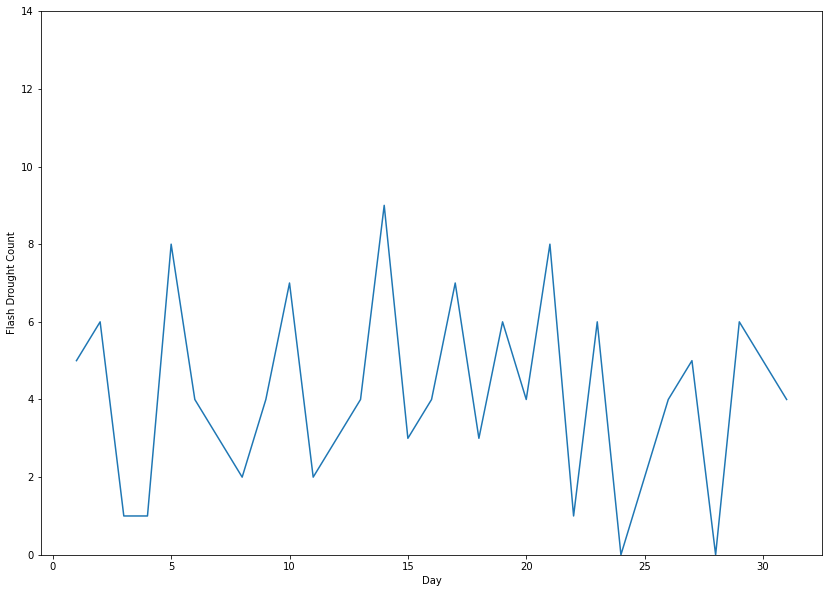

In [288]:
days=[]
counts=[]
for d in fixed.index.day.unique():
    dayFrame=fixed[fixed.index.week==d]
    length = len(dayFrame)
    days.append(d)
    counts.append(length)
countsFrame = pd.DataFrame()
countsFrame['days']=days
countsFrame['counts']=counts
countsFrame = countsFrame.sort_values('days')
countsFrame = countsFrame.set_index('days')
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(countsFrame['counts'])
ax.set_ylim(0, countsFrame['counts'].max()+5)
ax.set_ylabel('Flash Drought Count')
ax.set_xlabel('Day')

In [289]:
goodmonths = goodmonths.merge(soils, on=['station'])

In [290]:
soiltypes=[]
counts = []
for i in goodmonths['4insoils'].unique():
    soils = goodmonths[goodmonths['4insoils']==i]
    soiltypes.append(i)
    counts.append(len(soils))
soilsPlot = pd.DataFrame()
soilsPlot['soiltypes']=soiltypes
soilsPlot['count']=counts
soilsPlot = soilsPlot.sort_values('soiltypes')

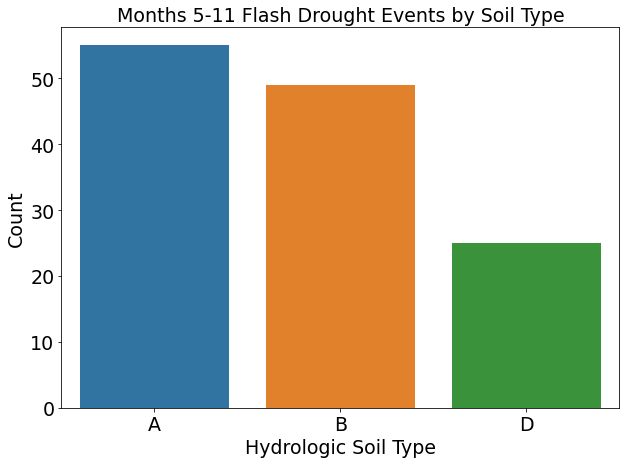

In [291]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='soiltypes', y='count', data=soilsPlot, ax=ax)
ax.set_title('Months 5-11 Flash Drought Events by Soil Type', fontsize=19)
ax.set_ylabel('Count', fontsize=19)
ax.set_xlabel('Hydrologic Soil Type', fontsize=19)
ax.xaxis.set_tick_params(labelsize=19)
ax.yaxis.set_tick_params(labelsize=19)

In [295]:
soilsPlot

soiltypes  count
2         A     55
0         B     49
1         D     25

In [304]:
goodmonths = goodmonths.merge(LANDREAD, on='station')

In [307]:
goodmonths

station  prior2esi  prior1esi  startesi  next1esi  next2esi  \
0    2053:AL:SCAN   1.683629   1.073794 -0.693332 -0.331371  0.355617   
1    2053:AL:SCAN   0.478733  -1.047085  0.516489  0.335098 -0.153263   
2    2053:AL:SCAN   1.784584  -1.321224 -0.575961  1.157513 -0.572678   
3    2053:AL:SCAN  -0.549696   0.184896  0.432770  0.441798 -1.338460   
4    2053:AL:SCAN  -0.719596   0.711012 -0.562829  0.455752 -0.145055   
..            ...        ...        ...       ...       ...       ...   
124  2181:AL:SCAN   1.538408   0.733387 -0.612182 -0.684101  0.843198   
125  2181:AL:SCAN  -0.721993   1.290947  0.391581 -0.665541 -0.496185   
126  2181:AL:SCAN  -0.046115   0.361422 -1.018173 -1.019720  0.817678   
127  2181:AL:SCAN   0.149533  -0.093288 -1.643012  0.094628  2.105249   
128  2181:AL:SCAN  -2.448034   2.638836  0.064469  0.443393 -0.006676   

     prior2esi_2wk  prior1esi_2wk  startesi_2wk  next1esi_2wk  ...  \
0         0.779637       2.529513      0.348007     -0.941613  ...   
1         0.039161      -0.522788     -0.488137      0.780391  ...   
2         1.736306       0.424088     -1.742352      0.532561  ...   
3         0.235768      -0.335974      0.565705      0.801483  ...   
4         0.088124      -0.009049      0.134828     -0.099443  ...   
..             ...            ...           ...           ...  ...   
124      -1.103881       2.069885      0.111110     -1.179950  ...   
125      -0.980621       0.518924      1.533177     -0.248809  ...   
126       0.415385       0.287899     -0.597459     -1.855414  ...   
127      -0.057228       0.051945     -1.580721     -1.409565  ...   
128      -2.805572       0.174500      2.462908      0.463281  ...   

     prior1esi8-endsum_4wk  startesi8-endsum_4wk  4in_pr_start  4in_pr_end  \
0                11.902030             10.261992     69.344898    6.585255   
1                -0.034651              0.552230     71.536179    7.658069   
2                 1.011078             -0.131338     97.808719   10.625428   
3                 0.304984              0.954744     66.503081   15.259073   
4                -1.359316             -1.474340     78.304040   20.942707   
..                     ...                   ...           ...         ...   
124              -6.327445             -5.263206     77.721981   18.762840   
125              -1.476668              0.145289     88.609906   15.281899   
126              -5.901367             -5.078516     64.437343    5.398311   
127              -5.203131             -6.258897     93.962566   14.163433   
128               1.568979              1.832147     95.412006    4.142890   

     4in_prDelta  drought_duration  USDM_cat  4insoils  dominant_land_x  \
0     -62.759644              10.0       2.0         B           agland   
1     -63.878110               6.0       2.0         B           agland   
2     -87.183291               4.0       4.0         B           agland   
3     -51.244008               5.0       1.0         B           agland   
4     -57.361333               3.0       4.0         B           agland   
..           ...               ...       ...       ...              ...   
124   -58.959142               3.0       1.0         A           agland   
125   -73.328007               3.0       1.0         A           agland   
126   -59.039032               3.0       4.0         A           agland   
127   -79.799133               7.0       1.0         A           agland   
128   -91.269117               5.0       3.0         A           agland   

     dominant_land_y  
0             agland  
1             agland  
2             agland  
3             agland  
4             agland  
..               ...  
124           agland  
125           agland  
126           agland  
127           agland  
128           agland  

[129 rows x 137 columns]

In [314]:
land = []
counts = []
for i in goodmonths['dominant_land_x'].unique():
    type_land = goodmonths[goodmonths['dominant_land_x']==i]
    land.append(i)
    counts.append(len(type_land))
    print(i, len(type_land))
landsPlot = pd.DataFrame()
landsPlot['dominant_land']=land
landsPlot['count']=counts
landsPlot = landsPlot.sort_values('count')

agland 41
forest 88


In [311]:
landsPlot

dominant_land  count
0        agland     41
1        forest     88

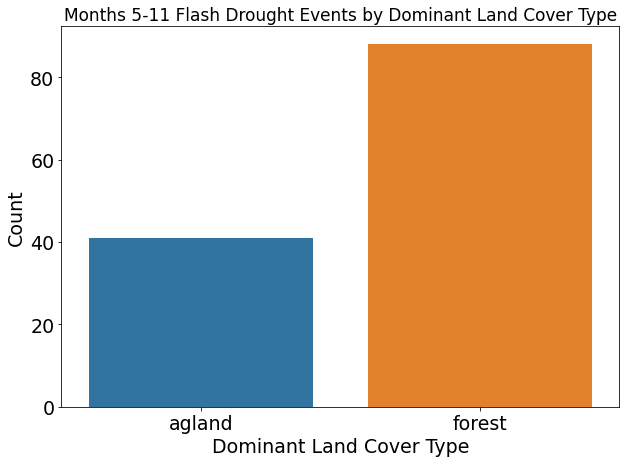

In [316]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='dominant_land', y='count', data=landsPlot, ax=ax)
ax.set_title('Months 5-11 Flash Drought Events by Dominant Land Cover Type', fontsize=17)
ax.set_ylabel('Count', fontsize=19)
ax.set_xlabel('Dominant Land Cover Type', fontsize=19)
ax.xaxis.set_tick_params(labelsize=19)
ax.yaxis.set_tick_params(labelsize=19)

In [318]:
LANDREAD.rename(columns={'dominant_land':'Dominant Land Cover', 'station':'Station'})

Dominant Land Cover       Station
0               agland  2177:AL:SCAN
1               agland  2053:AL:SCAN
2               agland  2174:AL:SCAN
3               agland  2078:AL:SCAN
4               agland  2180:AL:SCAN
5               agland  2178:AL:SCAN
6               agland  2181:AL:SCAN
7               forest  2179:AL:SCAN
8               forest  2173:AL:SCAN
9               forest  2175:AL:SCAN
10              forest  2114:AL:SCAN
11              forest  2055:AL:SCAN
12              forest  2113:AL:SCAN
13              forest  2057:AL:SCAN
14              forest  2056:AL:SCAN
15              forest  2115:AL:SCAN
16              forest  2182:AL:SCAN
17              forest  2176:AL:SCAN

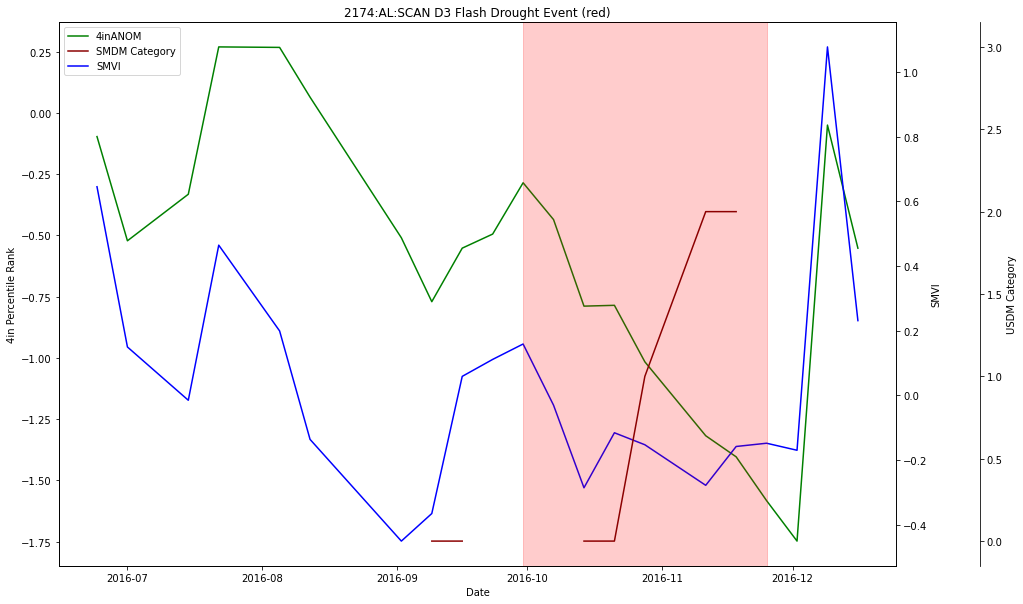

In [292]:
fig, ax = plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines.right.set_position(("axes", 1.1))
SMUSDM_h, = ax3.plot(caseFrame['4inSMSDC'], label='SMDM Category', color='darkred')
SM_h, = ax.plot(caseFrame['4inANOM'], label='4inANOM', color='green')
SMVI, =ax2.plot(caseFrame['1pentad-3pentad'], label='SMVI', color='blue')
plt.axvspan(startFlash, endFlash, color='red', alpha=0.20)
ax.set_xlabel('Date')
ax.set_ylabel('4in Percentile Rank')
ax2.set_ylabel('SMVI')
ax3.set_ylabel('USDM Category')
ax.set_title('2174:AL:SCAN D3 Flash Drought Event (red)')
ax3.legend(handles=[SM_h, SMUSDM_h, SMVI], loc='upper left')

In [293]:
endFlash

Timestamp('2016-11-25 00:00:00')

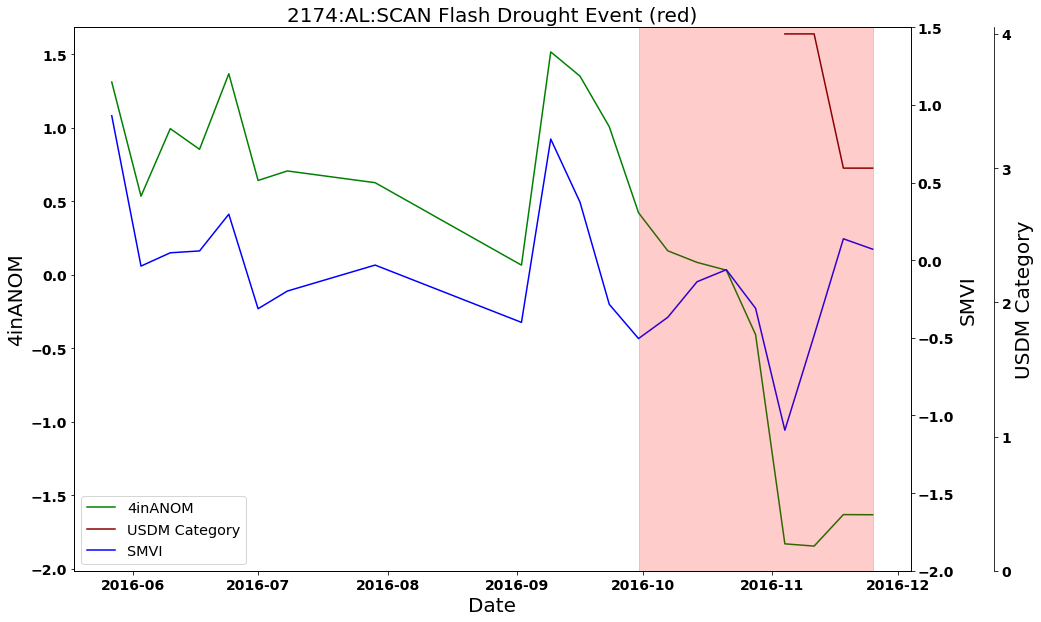

In [294]:
fig, ax = plt.subplots(figsize=(15,10))
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines.right.set_position(("axes", 1.1))
#ESI_h, = ax.plot(caseFrame['esi8_change_anom_3wk_cumsum'], label='esi8_change_anom_3wk Cumsum', color='orange')
#ax2.plot(caseFrame['1pentad-3pentad'], label='1week-3week', color='green')
#USDM_h, = ax3.plot(caseFrame['Category'], label='USDM Category', color='red')
SMUSDM_h, = ax3.plot(caseFrame2['4inSMSDC'], label='USDM Category', color='darkred')
#SM_h, = ax.plot(caseFrame['4inANOM'], label='4inANOM', color='blue')
#SM_pr, = ax.plot(caseFrame2['4in_pr'], label='4in_pr', color='red')
SM_h, = ax.plot(caseFrame2['4inANOM'], label='4inANOM', color='green')
SMVI, =ax2.plot(caseFrame2['1pentad-3pentad'], label='SMVI', color='blue')
plt.axvspan(startFlash, endFlash, color='red', alpha=0.20)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('4inANOM', fontsize=20)
ax.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('SMVI', fontsize=20)
ax.yaxis.set_ticks(np.arange(-2.0, 2.0, 0.5))
ax2.yaxis.set_ticks(np.arange(-2.0, 2.0, 0.5))
ax3.set_ylabel('USDM Category', fontsize=20)
ax3.yaxis.set_ticks(np.arange(0.0, 5.0, 1.0))
for l in ax.get_xticklabels():
    l.set_fontsize(14)
    l.set_weight('bold')
for l in ax.get_yticklabels():
    l.set_fontsize(14)
    l.set_weight('bold')
for l in ax2.get_yticklabels():
    l.set_fontsize(14)
    l.set_weight('bold')
for l in ax3.get_yticklabels():
    l.set_fontsize(14)
    l.set_weight('bold')
ax.set_title('2174:AL:SCAN Flash Drought Event (red)', fontsize=20)
ax3.legend(handles=[SM_h, SMUSDM_h, SMVI], loc='lower left', fontsize='x-large')

In [ ]:
caseFrame